# DeepLearning and MIKE21 Spectral Wave Model & Result Analysis

## Setup / Imports

In [9]:
import arcpy
from arcpy.sa import *
print(arcpy.GetInstallInfo()["InstallType"])

N/A


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import re
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import unicodedata

In [4]:
import mikeio
from mikeio import Grid2D, DataArray, Dataset, Dfs2, Dfs0
from mikeio import ItemInfo, EUMType, EUMUnit

In [5]:
print(mikeio.__version__)

1.7.1


In [6]:
import sys
print(sys.version)

3.11.11 (main, Mar  3 2025, 15:29:37) [MSC v.1938 64 bit (AMD64)]


In [7]:
%matplotlib inline

## 1. Define Paths & Environment

In [10]:
# ==== 1. SET UP PATHS ====
# Get current working directory
current_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.dirname(current_dir)

# Source folder for .asc and .vel input files
source_folder = Path(parent_dir) / "windninja" / "windninja_output"

# Source folder for Spectral Wave models from MIKE 21 SW results
source_folder_mike21sw = os.path.join(parent_dir, r"MIKE21\SW_results")
os.makedirs(source_folder_mike21sw, exist_ok=True)

# Destination folder for lv95 tif output from ArcGis
destination_folder_tif = os.path.join(parent_dir, r"MIKE21\wind_tif_lv95")
os.makedirs(destination_folder_tif, exist_ok=True)

# Destination folder for lv95 ASCII output from ArcGis
destination_folder_asc = os.path.join(parent_dir, r"MIKE21\wind_asc_lv95")
os.makedirs(destination_folder_asc, exist_ok=True)

# Destination folder for DFS2 output
destination_folder_dfs2 = os.path.join(parent_dir, r"MIKE21\wind_dfs2")
os.makedirs(destination_folder_dfs2, exist_ok=True)

# Geodatabase to hold intermediates
gdb_path = os.path.join(parent_dir, r"MIKE21\wind_arcgis_gdb\wind.gdb")
os.makedirs(os.path.dirname(gdb_path), exist_ok=True)
if not arcpy.Exists(gdb_path):
    arcpy.management.CreateFileGDB(os.path.dirname(gdb_path), Path(gdb_path).name, "CURRENT")


In [11]:
# Paths for deeplearning results

# Source folder finetuned model results
source_folder_deepL = Path(parent_dir) / "results"


In [12]:
base_root = Path(source_folder)
if not base_root.exists():
    raise FileNotFoundError(f"Source root not found: {base_root}")

In [13]:
# ---- ArcGIS env ----
arcpy.CheckOutExtension("Spatial")
arcpy.env.overwriteOutput = True
arcpy.env.workspace = gdb_path

# Comparison of two MIKE 21 Areaparameters

In [14]:
# USER INPUT
# -------------------------------------------------------------------
name_dfsu_A = r"06_SW-areaparameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfsu"
name_dfsu_B = r"05_SW-areaparameters - 2025-10-23-0200-2300-uv-wind_10min_growth3_0.2Hz.dfsu"  # <- second run to compare

file_dfsu_A = os.path.join(source_folder_mike21sw, name_dfsu_A)
file_dfsu_B = os.path.join(source_folder_mike21sw, name_dfsu_B)

item_index_A = 0
item_index_B = 0

start = pd.Timestamp("2025-10-23 11:00")
end   = pd.Timestamp("2025-10-23 11:00")

dfsu_A = mikeio.open(file_dfsu_A)

selected_time_indices = [
    i for i, t in enumerate(dfsu_A.time)
    if (t >= start) and (t <= end)
]

print("Selected indices:", selected_time_indices)

Selected indices: [54]


In [15]:
# GEOMETRY COMPATIBILITY CHECK
# -------------------------------------------------------------------

def geometries_compatible(g1, g2, rtol=1e-6, atol=1e-8):
    """Check if two mikeio geometries are compatible for direct element-wise comparison."""
    # same type?
    if type(g1) is not type(g2):
        return False

    # same number of elements and nodes?
    if getattr(g1, "n_elements", None) != getattr(g2, "n_elements", None):
        return False
    if getattr(g1, "n_nodes", None) != getattr(g2, "n_nodes", None):
        return False

    # same coordinates (within numerical tolerance)?
    if hasattr(g1, "x") and hasattr(g2, "x"):
        if not np.allclose(g1.x, g2.x, rtol=rtol, atol=atol):
            return False
    if hasattr(g1, "y") and hasattr(g2, "y"):
        if not np.allclose(g1.y, g2.y, rtol=rtol, atol=atol):
            return False

    return True

In [16]:
# READ FILES
# -------------------------------------------------------------------
ds_A = mikeio.read(file_dfsu_A)
ds_B = mikeio.read(file_dfsu_B)

print(ds_A)
print(ds_B)

da_A = ds_A[item_index_A]  # mikeio.DataArray
da_B = ds_B[item_index_B]

# basic consistency checks
if not geometries_compatible(ds_A.geometry, ds_B.geometry):
    raise ValueError("DFSU geometries do not match (content-wise) – cannot compare directly.")

if len(ds_A.time) != len(ds_B.time) or not np.all(ds_A.time == ds_B.time):
    raise ValueError("Time axes differ – consider interpolating first.")

nt, ne = da_A.values.shape
# make sure indices are valid
selected_time_indices = [i for i in selected_time_indices if 0 <= i < nt]
if not selected_time_indices:
    raise ValueError("No valid time indices selected.")

<mikeio.Dataset>
dims: (time:132, element:8597)
time: 2025-10-23 02:00:00 - 2025-10-23 23:50:00 (132 records)
geometry: Dfsu2D (8597 elements, 4737 nodes)
number of items: 11
<mikeio.Dataset>
dims: (time:132, element:8597)
time: 2025-10-23 02:00:00 - 2025-10-23 23:50:00 (132 records)
geometry: Dfsu2D (8597 elements, 4737 nodes)
number of items: 11


In [17]:
# COMPUTE DIFFERENCE ONLY ON SELECTED TIMES
# -------------------------------------------------------------------
vals_A = da_A.values[selected_time_indices, :]  # (nt_sel, ne)
vals_B = da_B.values[selected_time_indices, :]

diff_sel = vals_B - vals_A                      # (nt_sel, ne)
mean_diff_sel = np.nanmean(diff_sel, axis=0)    # (ne,)

# global stats over selected times
valid = ~np.isnan(diff_sel)
print("\n=== GLOBAL STATS (B - A) over selected timesteps ===")
print(f"Selected indices: {selected_time_indices}")
print(f"Mean bias: {diff_sel[valid].mean():.4f}")
print(f"RMS diff: {np.sqrt((diff_sel[valid]**2).mean()):.4f}")
print(f"Min diff: {diff_sel[valid].min():.4f}")
print(f"Max diff: {diff_sel[valid].max():.4f}")


=== GLOBAL STATS (B - A) over selected timesteps ===
Selected indices: [54]
Mean bias: 0.4195
RMS diff: 0.6233
Min diff: -0.0036
Max diff: 1.7726


<Figure size 800x500 with 0 Axes>

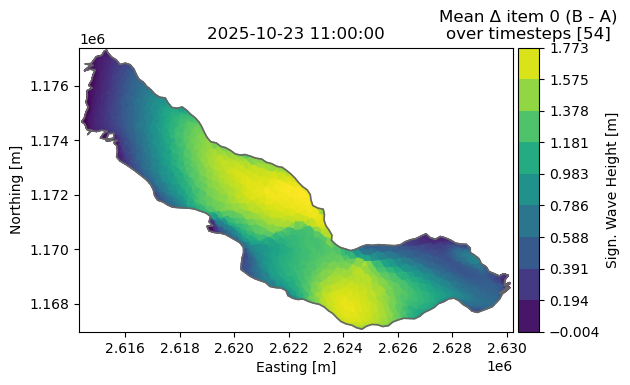

In [19]:
# PLOT MEAN DIFFERENCE MAP
# -------------------------------------------------------------------
da_diff_mean = mikeio.DataArray(
    data=mean_diff_sel,
    time=[ds_A.time[selected_time_indices[0]]],  # dummy single time
    item=da_A.item,
    geometry=ds_A.geometry,
)

plt.figure(figsize=(8, 5))
da_diff_mean.plot()
plt.title(
    f"Mean Δ item {item_index_A} (B - A)\n"
    f"over timesteps {selected_time_indices}"
)
plt.tight_layout()
plt.show()

# Comparison of two MIKE 21 Pointparameter

In [24]:
# USER INPUT
# -------------------------------------------------------------------

time_start = pd.Timestamp("2025-10-23 02:00")
time_end   = pd.Timestamp("2025-10-23 23:50")

# 2025-10-23: 0.2Hz
name_dfs0_A = r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0"  # speed & direction
name_dfs0_B = r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0"  # U-V components

# 2025-10-23: 0.15Hz
#name_dfs0_A = r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0"  # speed & direction
#name_dfs0_B = r"12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0"  # U-V components

#time_start = pd.Timestamp("2025-08-09 02:00")
#time_end   = pd.Timestamp("2025-08-09 23:50")

# 2025-08-09: 0.2Hz
#name_dfs0_A = r"18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0"  # speed & direction
#name_dfs0_B = r"17_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0"  # U-V components

# 2025-08-09: 0.15Hz
#name_dfs0_A = r"19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0"  # speed & direction
#name_dfs0_B = r"16_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0"  # U-V components

#time_start = pd.Timestamp("2025-08-24 02:00")
#time_end   = pd.Timestamp("2025-08-24 23:50")

# 2025-08-24: 0.2Hz
#name_dfs0_A = r"32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0"  # speed & direction
#name_dfs0_B = r"26_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0"  # U-V components

# 2025-08-24: 0.15Hz
#name_dfs0_A = r"31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0"  # speed & direction
#name_dfs0_B = r"25_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0"  # U-V components

file_dfs0_A = os.path.join(source_folder_mike21sw, name_dfs0_A)
file_dfs0_B = os.path.join(source_folder_mike21sw, name_dfs0_B)

item_index = 0




In [26]:
# READ DFS0 FILES
# -------------------------------------------------------------------
ds0_A = mikeio.read(file_dfs0_A)
ds0_B = mikeio.read(file_dfs0_B)

print("File A:")
print(ds0_A)
print("\nFile B:")
print(ds0_B)


da0_A = ds0_A[item_index]
da0_B = ds0_B[item_index]

param_name = da0_A.name
param_unit = da0_A.unit.name if hasattr(da0_A.unit, "name") else str(da0_A.unit)
print(f"\nComparing item {item_index}: {param_name} [{param_unit}]")

File A:
<mikeio.Dataset>
dims: (time:132)
time: 2025-10-23 02:00:00 - 2025-10-23 23:50:00 (132 records)
geometry: GeometryUndefined()
number of items: 12

File B:
<mikeio.Dataset>
dims: (time:132)
time: 2025-10-23 02:00:00 - 2025-10-23 23:50:00 (132 records)
geometry: GeometryUndefined()
number of items: 12

Comparing item 0: SUP-2025-08-31-06:50: Sign. Wave Height [meter]


In [27]:
# CHECK & ALIGN TIME
# -------------------------------------------------------------------
time_A = ds0_A.time
time_B = ds0_B.time

if len(time_A) != len(time_B) or not np.all(time_A == time_B):
    raise ValueError("Time axes of the two dfs0 files differ. "
                     "Resampling/interpolation would be needed to compare.")

time = time_A

values_A = da0_A.values  # shape (nt,) or (nt, npoints) – usually (nt,)
values_B = da0_B.values

# Ensure 1D (single point) for simplicity – extend if needed later
if values_A.ndim > 1:
    # take first point if there are multiple points in one item
    values_A = values_A[:, 0]
if values_B.ndim > 1:
    values_B = values_B[:, 0]

In [28]:
# OPTIONAL: RESTRICT TO TIME WINDOW
# -------------------------------------------------------------------
if time_start is not None or time_end is not None:
    time_index = pd.DatetimeIndex(time)
    mask = np.ones(len(time), dtype=bool)
    if time_start is not None:
        mask &= time_index >= time_start
    if time_end is not None:
        mask &= time_index <= time_end

    time = time_index[mask].to_pydatetime()
    values_A = values_A[mask]
    values_B = values_B[mask]

In [29]:
# COMPUTE DIFFERENCES
# -------------------------------------------------------------------
diff = values_B - values_A
valid = ~np.isnan(diff)

bias = diff[valid].mean()
rmse = np.sqrt((diff[valid] ** 2).mean())
min_diff = diff[valid].min()
max_diff = diff[valid].max()

print("\n=== POINT PARAMETER COMPARISON (B - A) ===")
print(f"Parameter: {param_name} [{param_unit}]")
print(f"Bias (mean diff): {bias:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"Min diff:         {min_diff:.4f}")
print(f"Max diff:         {max_diff:.4f}")


=== POINT PARAMETER COMPARISON (B - A) ===
Parameter: SUP-2025-08-31-06:50: Sign. Wave Height [meter]
Bias (mean diff): -0.1361
RMSE:             0.2126
Min diff:         -0.4985
Max diff:         0.0830


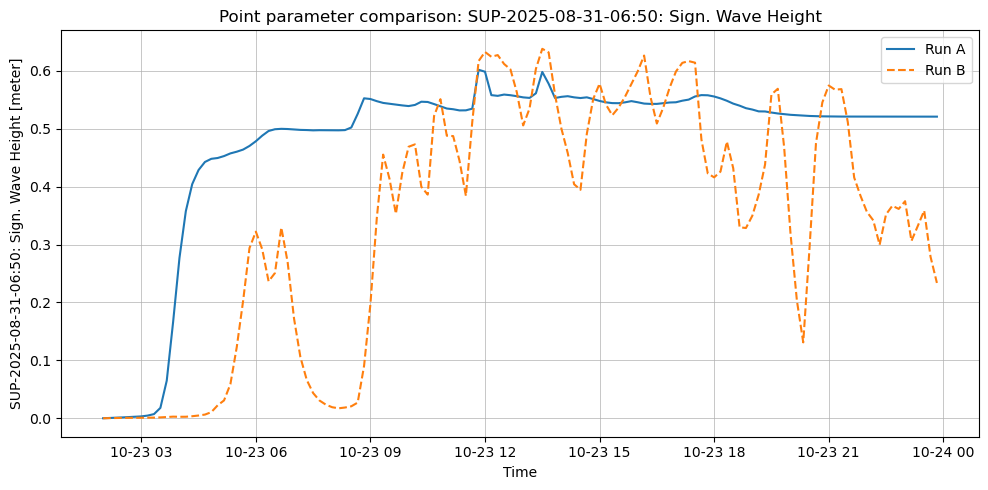

In [30]:
# PLOT 1: TIME SERIES OF BOTH RUNS
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(time, values_A, label="Run A", linewidth=1.5)
plt.plot(time, values_B, label="Run B", linewidth=1.5, linestyle="--")
plt.xlabel("Time")
plt.ylabel(f"{param_name} [{param_unit}]")
plt.title(f"Point parameter comparison: {param_name}")
plt.grid(True, linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

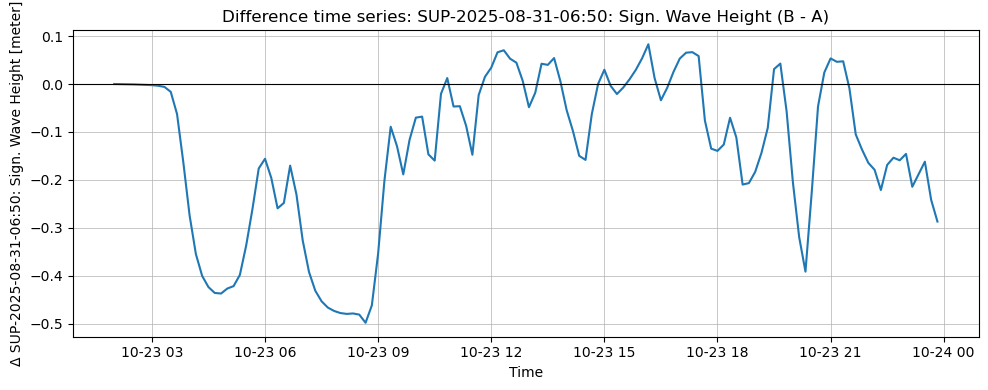

In [31]:
# PLOT 2: TIME SERIES OF DIFFERENCE (B - A)
# -------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(time, diff, label="B - A", linewidth=1.5)
plt.axhline(0.0, color="k", linewidth=0.8)
plt.xlabel("Time")
plt.ylabel(f"Δ {param_name} [{param_unit}]")
plt.title(f"Difference time series: {param_name} (B - A)")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

In [35]:
A = values_A[valid]
B = values_B[valid]

corr = np.corrcoef(A, B)[0, 1]

# Scatter Index (SI): RMSE normalized by mean observed/reference
# Here we normalize by Run A mean (common choice)
mean_A = np.nanmean(A)

si = rmse / mean_A if mean_A != 0 else np.nan

print(f"Correlation:   {corr:.3f}")
print(f"Scatter Index:{si:.3f}")
print(f"Scatter Index:    {si:.3f}")

Correlation:   0.652
Scatter Index:0.445
Scatter Index:    0.445


# Comparison of MULTIPLE MIKE 21 Pointparameter

## Comparison different Sprectral Discretization Minimum Frequency 0.05 -> 0.2 Hz  

## (Speed & Direction)

In [24]:
# USER INPUT — LIST ALL DFS0 FILES YOU WANT TO COMPARE
# ---------------------------------------------------------

# 2025-10-23
#time_start = pd.Timestamp("2025-10-23 02:00")
#time_end   = pd.Timestamp("2025-10-23 23:50")

#files = [
#    r"10_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.05Hz.dfs0",  # Run A
#    r"08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
#    r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",  # Run C
#    r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
#    r"30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
#]

# 2025-08-09
#time_start = pd.Timestamp("2025-08-09 02:00")
#time_end   = pd.Timestamp("2025-08-09 23:50")

#files = [
#    r"20_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",      # Run A
#    r"20_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",      # Run B
#    r"19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",     # Run C
#    r"18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",      # Run D
#    r"29_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0"      # Run E
#]

# 2025-08-24
time_start = pd.Timestamp("2025-08-24 02:00")
time_end   = pd.Timestamp("2025-08-24 23:50")

files = [
    r"33_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",    # Run A
    r"33_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",    # Run B
    r"31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",   # Run C
    r"32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",    # Run D
    r"34_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
]

labels = [
    "Run A (0.05 Hz)",
    "Run B (0.10 Hz)",
    "Run C (0.15 Hz)",
    "Run D (0.20 Hz)",
    "Run E (0.25 Hz)",
    #"Run F",
]

# Folder where dfs0 files are stored
file_paths = [os.path.join(source_folder_mike21sw, f) for f in files]

# Which item to compare (0 = Significant wave height, in your example)
item_index = 0


In [25]:
# LOAD ALL DFS0 FILES
# ---------------------------------------------------------
datasets = [mikeio.read(fp) for fp in file_paths]

# Sanity check: labels vs files
if len(labels) != len(datasets):
    raise ValueError("Number of labels must match number of dfs0 files!")

print("Loaded dfs0 files:")
for lab, fp in zip(labels, file_paths):
    print(f"  {lab}: {fp}")

Loaded dfs0 files:
  Run A (0.05 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\33_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0
  Run B (0.10 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\33_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0
  Run C (0.15 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0
  Run D (0.20 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0
  Run E (0.25 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\34_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0


In [26]:
# CHECK / ALIGN TIME AXES
# ---------------------------------------------------------
base_time = datasets[0].time
for i, ds in enumerate(datasets[1:], start=1):
    if len(ds.time) != len(base_time) or not np.all(ds.time == base_time):
        raise ValueError(f"Time axis of file {files[i]} does not match Run A!")

time_full = pd.DatetimeIndex(base_time)

In [27]:
# EXTRACT VALUES FOR EACH RUN
# ---------------------------------------------------------
all_values = []

for ds in datasets:
    da = ds[item_index]
    vals = da.values
    # if there are multiple points in one item, take the first
    if vals.ndim > 1:
        vals = vals[:, 0]
    all_values.append(vals)

# Parameter metadata (from first dataset)
da0 = datasets[0][item_index]
param_name = da0.name
param_unit = da0.unit.name if hasattr(da0.unit, "name") else str(da0.unit)
print(f"\nParameter: {param_name} [{param_unit}]")



Parameter: SUP-2025-08-31-06:50: Sign. Wave Height [meter]


In [28]:
# APPLY TIME RESTRICTION
# ---------------------------------------------------------
mask = (time_full >= time_start) & (time_full <= time_end)

time = time_full[mask]
all_values = [vals[mask] for vals in all_values]


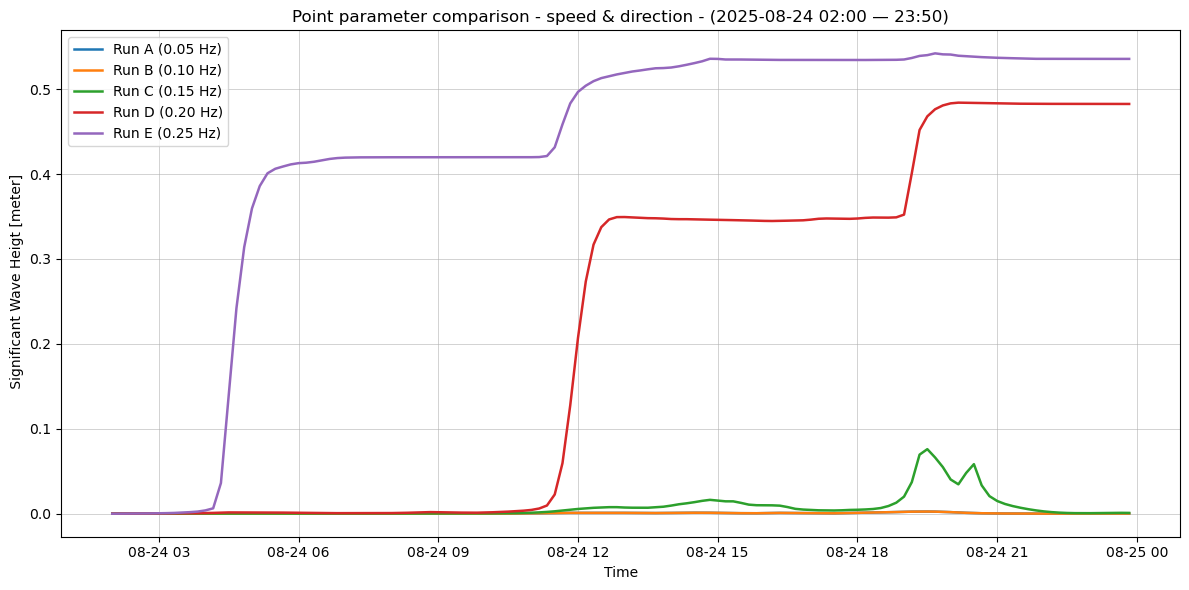

In [29]:
# PLOT 1: ALL RUNS IN ONE LINE PLOT
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

for vals, label in zip(all_values, labels):
    plt.plot(time, vals, linewidth=1.8, label=label)

plt.xlabel("Time")
plt.ylabel(f" Significant Wave Heigt [{param_unit}]")
plt.title(
    f"Point parameter comparison - speed & direction - ({time_start:%Y-%m-%d %H:%M} — {time_end:%H:%M})"
)
plt.grid(True, linewidth=0.4)
plt.legend()

save_plot = os.path.join(source_folder_mike21sw, "DATE_compare_MIKESW21_SD.png")
plt.savefig(save_plot, dpi=300)

plt.tight_layout()
plt.show()

In [30]:
# DIFFERENCE ANALYSIS VS REFERENCE (Run A)
# ---------------------------------------------------------
ref_vals = all_values[0]
diff_metrics = []

for idx in range(1, len(all_values)):
    vals = all_values[idx]
    label = labels[idx]

    diff = vals - ref_vals
    valid = ~np.isnan(diff)

    if not valid.any():
        bias = rmse = min_diff = max_diff = np.nan
    else:
        bias     = diff[valid].mean()
        rmse     = np.sqrt((diff[valid] ** 2).mean())
        min_diff = diff[valid].min()
        max_diff = diff[valid].max()

    diff_metrics.append({
        "run": label,
        "ref": labels[0],
        "bias (mean diff)": bias,
        "RMSE": rmse,
        "min diff": min_diff,
        "max diff": max_diff,
    })

diff_df = pd.DataFrame(diff_metrics)
print("\n=== Difference statistics vs reference (Run A) ===")
display(diff_df)


=== Difference statistics vs reference (Run A) ===


run              ref  bias (mean diff)      RMSE  min diff  \
0  Run B (0.10 Hz)  Run A (0.05 Hz)          0.000000  0.000000       0.0   
1  Run C (0.15 Hz)  Run A (0.05 Hz)          0.007151  0.015415       0.0   
2  Run D (0.20 Hz)  Run A (0.05 Hz)          0.217900  0.297026       0.0   
3  Run E (0.25 Hz)  Run A (0.05 Hz)          0.428562  0.459453       0.0   

   max diff  
0  0.000000  
1  0.073496  
2  0.483142  
3  0.539776

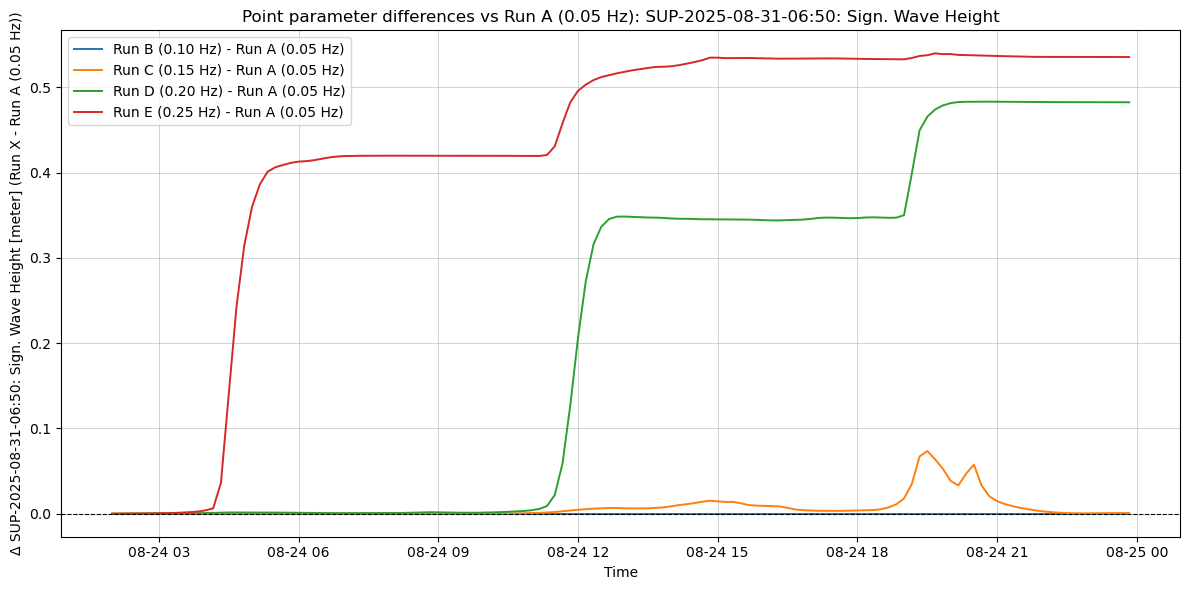

In [31]:
# PLOT 2: TIME SERIES OF DIFFERENCES (Run X – Run A)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

for idx in range(1, len(all_values)):
    vals = all_values[idx]
    label = labels[idx]
    diff = vals - ref_vals
    plt.plot(time, diff, linewidth=1.4, label=f"{label} - {labels[0]}")

plt.axhline(0.0, color="k", linewidth=0.8, linestyle="--")
plt.xlabel("Time")
plt.ylabel(f"Δ {param_name} [{param_unit}] (Run X - {labels[0]})")
plt.title(f"Point parameter differences vs {labels[0]}: {param_name}")
plt.grid(True, linewidth=0.4)
plt.legend()
plt.tight_layout()
plt.show()

## Comparison different Sprectral Discretization Minimum Frequency 0.05 -> 0.2 Hz  

## (U and V windcomponents)

In [1005]:
# USER INPUT — LIST ALL DFS0 FILES YOU WANT TO COMPARE
# ---------------------------------------------------------

# 2025-10-23
#time_start = pd.Timestamp("2025-10-23 02:00")
#time_end   = pd.Timestamp("2025-10-23 23:50")

#files = [
#    r"11_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.05Hz.dfs0",  # Run A
#    r"13_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
#    r"12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",  # Run C
#    r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
#    r"14_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",  # Run E
#    r"15_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0",   # Run F
#]

# 2025-08-09
#time_start = pd.Timestamp("2025-08-09 02:00")
#time_end   = pd.Timestamp("2025-08-09 23:50")

#files = [
#    r"21_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run A
#    r"21_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
#    r"16_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",  # Run C
#    r"17_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
#    r"22_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
#    r"23_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0",   # Run F
#]

# 2025-08-24
time_start = pd.Timestamp("2025-08-24 02:00")
time_end   = pd.Timestamp("2025-08-24 23:50")

files = [
    r"24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run A
    r"24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
    r"25_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",   # Run C
    r"26_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
    r"27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
    r"28_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0",   # Run DF
]

labels = [
    "Run A (0.05 Hz)",
    "Run B (0.10 Hz)",
    "Run C (0.15 Hz)",
    "Run D (0.20 Hz)",
    "Run E (0.25 Hz)",
    "Run F (0.30 Hz)",
]

# Folder where dfs0 files are stored
file_paths = [os.path.join(source_folder_mike21sw, f) for f in files]

# Which item to compare (0 = Significant wave height, in your example)
item_index = 0


In [1006]:
# LOAD ALL DFS0 FILES
# ---------------------------------------------------------
datasets = [mikeio.read(fp) for fp in file_paths]

# Sanity check: labels vs files
if len(labels) != len(datasets):
    raise ValueError("Number of labels must match number of dfs0 files!")

print("Loaded dfs0 files:")
for lab, fp in zip(labels, file_paths):
    print(f"  {lab}: {fp}")

Loaded dfs0 files:
  Run A (0.05 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0
  Run B (0.1 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0
  Run C (0.15 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\25_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0
  Run D (0.2 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\26_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0
  Run E (0.25 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0
  Run F (0.3 Hz): C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\28_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.3

In [1007]:
# CHECK / ALIGN TIME AXES
# ---------------------------------------------------------
base_time = datasets[0].time
for i, ds in enumerate(datasets[1:], start=1):
    if len(ds.time) != len(base_time) or not np.all(ds.time == base_time):
        raise ValueError(f"Time axis of file {files[i]} does not match Run A!")

time_full = pd.DatetimeIndex(base_time)

In [1008]:
# EXTRACT VALUES FOR EACH RUN
# ---------------------------------------------------------
all_values = []

for ds in datasets:
    da = ds[item_index]
    vals = da.values
    # if there are multiple points in one item, take the first
    if vals.ndim > 1:
        vals = vals[:, 0]
    all_values.append(vals)

# Parameter metadata (from first dataset)
da0 = datasets[0][item_index]
param_name = da0.name
param_unit = da0.unit.name if hasattr(da0.unit, "name") else str(da0.unit)
print(f"\nParameter: {param_name} [{param_unit}]")



Parameter: SUP-2025-08-31-06:50: Sign. Wave Height [meter]


In [1009]:
# APPLY TIME RESTRICTION
# ---------------------------------------------------------
mask = (time_full >= time_start) & (time_full <= time_end)

time = time_full[mask]
all_values = [vals[mask] for vals in all_values]


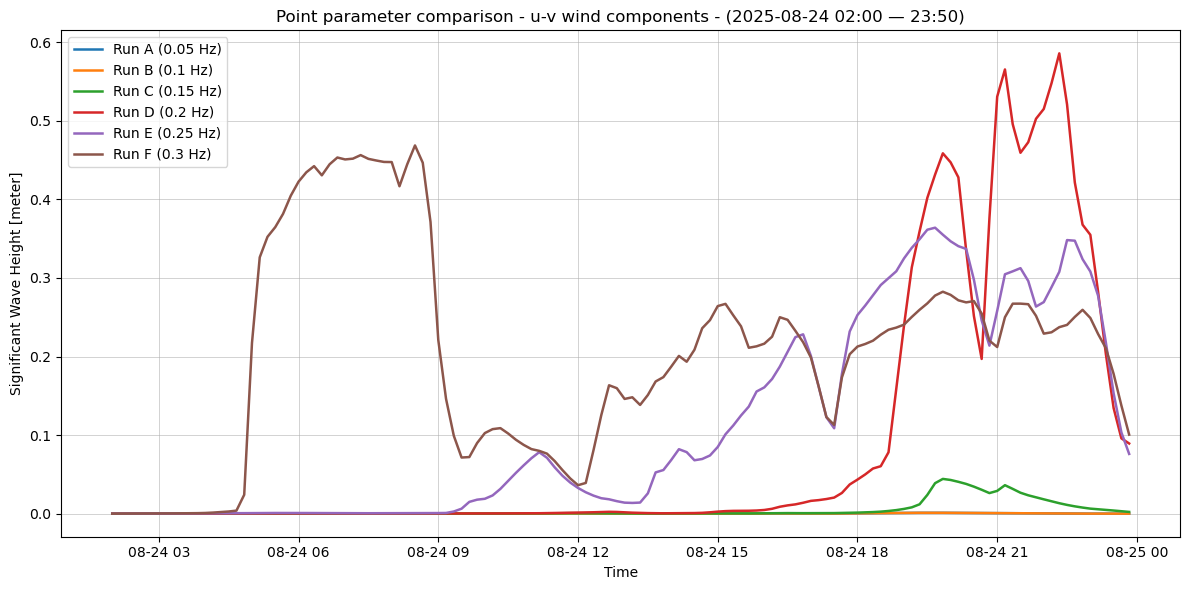

In [1010]:
# PLOT 1: ALL RUNS IN ONE LINE PLOT
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

for vals, label in zip(all_values, labels):
    plt.plot(time, vals, linewidth=1.8, label=label)

plt.xlabel("Time")
plt.ylabel(f"Significant Wave Height [{param_unit}]")
plt.title(
    f"Point parameter comparison - u-v wind components - ({time_start:%Y-%m-%d %H:%M} — {time_end:%H:%M})"
)
plt.grid(True, linewidth=0.4)
plt.legend()

save_plot = os.path.join(source_folder_mike21sw, "DATE_compare_MIKESW21_UV.png")
plt.savefig(save_plot, dpi=300)

plt.tight_layout()
plt.show()

In [823]:
# DIFFERENCE ANALYSIS VS REFERENCE (Run A)
# ---------------------------------------------------------
ref_vals = all_values[0]
diff_metrics = []

for idx in range(1, len(all_values)):
    vals = all_values[idx]
    label = labels[idx]

    diff = vals - ref_vals
    valid = ~np.isnan(diff)

    if not valid.any():
        bias = rmse = min_diff = max_diff = np.nan
    else:
        bias     = diff[valid].mean()
        rmse     = np.sqrt((diff[valid] ** 2).mean())
        min_diff = diff[valid].min()
        max_diff = diff[valid].max()

    diff_metrics.append({
        "run": label,
        "ref": labels[0],
        "bias (mean diff)": bias,
        "RMSE": rmse,
        "min diff": min_diff,
        "max diff": max_diff,
    })

diff_df = pd.DataFrame(diff_metrics)
print("\n=== Difference statistics vs reference (Run A) ===")
display(diff_df)


=== Difference statistics vs reference (Run A) ===


run              ref  bias (mean diff)      RMSE  min diff  \
0   Run B (0.1 Hz)  Run A (0.05 Hz)          0.000000  0.000000       0.0   
1  Run C (0.15 Hz)  Run A (0.05 Hz)          0.001214  0.002888       0.0   
2   Run D (0.2 Hz)  Run A (0.05 Hz)          0.108662  0.210954       0.0   
3  Run E (0.25 Hz)  Run A (0.05 Hz)          0.135910  0.223919       0.0   
4   Run F (0.3 Hz)  Run A (0.05 Hz)          0.218138  0.264612       0.0   

   max diff  
0  0.000000  
1  0.014636  
2  0.514577  
3  0.555551  
4  0.535219

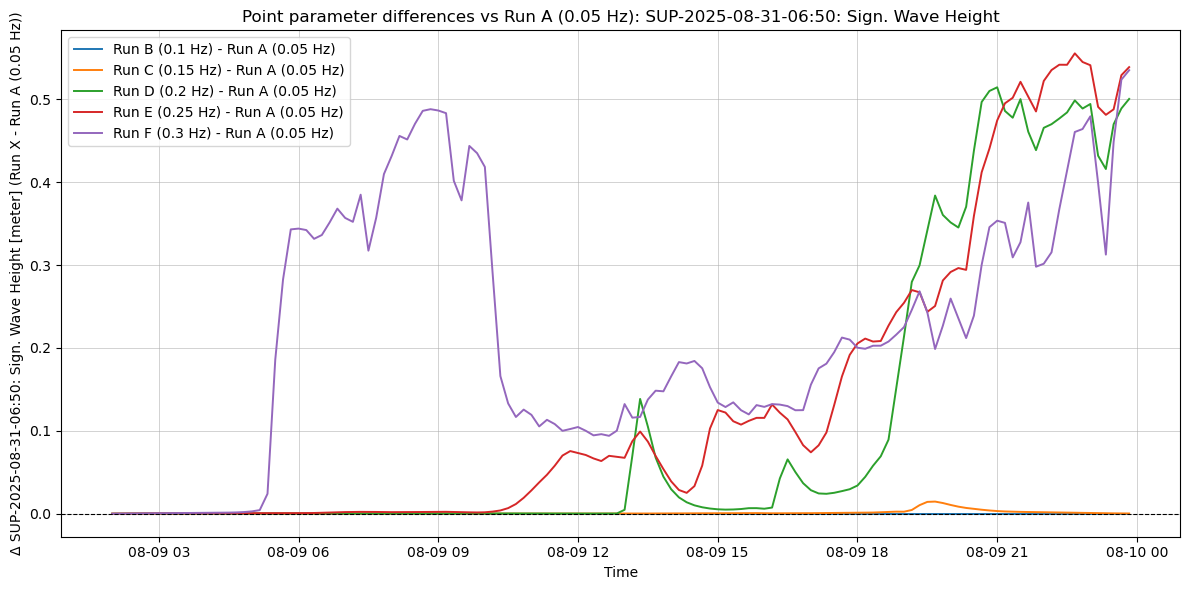

In [824]:
# PLOT 2: TIME SERIES OF DIFFERENCES (Run X – Run A)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

for idx in range(1, len(all_values)):
    vals = all_values[idx]
    label = labels[idx]
    diff = vals - ref_vals
    plt.plot(time, diff, linewidth=1.4, label=f"{label} - {labels[0]}")

plt.axhline(0.0, color="k", linewidth=0.8, linestyle="--")
plt.xlabel("Time")
plt.ylabel(f"Δ {param_name} [{param_unit}] (Run X - {labels[0]})")
plt.title(f"Point parameter differences vs {labels[0]}: {param_name}")
plt.grid(True, linewidth=0.4)
plt.legend()
plt.tight_layout()
plt.show()

## Comparing DL Detected Significant Wave Height with Mike21 SW

In [270]:
# 1. READ WEBCAM SUMMARY CSV (per-image Hs + wave counts)
# -------------------------------------------------------------------

#2025-08-09
#Yolo8S - 5000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_5000_wave_stat\summary_04_waves_yolov8s-5000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#Yolo8S - 1000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_1000_wave_stat\summary_03_waves_yolov8s-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_wave_stat\waves_03_waves_yolov8s-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#Yolo8N - 150
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-150_wave_stat\summary_02_waves_yolov8n-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-150_wave_stat\waves_02_waves_yolov8n-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#Yolo8N - 50
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-50_wave_stat\summary_02_waves_yolov8n-1000_50e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-50_wave_stat\waves_02_waves_yolov8n-1000_50e_2025-08-09_02-00_2025-08-09_23-50.csv")

#2025-08-24
#Yolo8S - 5000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_5000_wave_stat\summary_04_waves_yolov8s-5000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#Yolo8S - 1000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_1000_wave_stat\summary_03_waves_yolov8s-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_1000_wave_stat\waves_03_waves_yolov8s-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#Yolo8N - 150
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-150_wave_stat\summary_02_waves_yolov8n-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-150_wave_stat\waves_02_waves_yolov8n-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#Yolo8N - 50
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-50_wave_stat\summary_02_waves_yolov8n-1000_50e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-50_wave_stat\waves_02_waves_yolov8n-1000_50e_2025-08-24_02-00_2025-08-24_23-50.csv")


#2025-10-23
#Yolo8S - 5000
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_5000_wave_stat\summary_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#Yolo8S - 1000
summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_1000_wave_stat\summary_03_waves_yolov8s-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_1000_wave_stat\waves_03_waves_yolov8s-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#Yolo8N - 150
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-150_wave_stat\summary_02_waves_yolov8n-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-150_wave_stat\waves_02_waves_yolov8n-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#Yolo8N - 50
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-50_wave_stat\summary_02_waves_yolov8n-1000_50e_2025-10-23_02-00_2025-10-23_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-50_wave_stat\waves_02_waves_yolov8n-1000_50e_2025-10-23_02-00_2025-10-23_23-50.csv")

summary = pd.read_csv(summary_csv)
waves_df = pd.read_csv(waves_csv)





In [271]:
waves_df.head()
summary.head()

image  number_of_waves  mean_height_m  max_height_m
0  img_2025_10_23_02_40_00.png              185       0.087582      0.175807
1  img_2025_10_23_03_00_00.png               63       0.079731      0.116341
2  img_2025_10_23_03_40_00.png              157       0.104259      0.202947
3  img_2025_10_23_04_00_00.png               67       0.081688      0.124415
4  img_2025_10_23_04_20_00.png              215       0.090705      0.168305

In [272]:
summary.head()

image  number_of_waves  mean_height_m  max_height_m
0  img_2025_10_23_02_40_00.png              185       0.087582      0.175807
1  img_2025_10_23_03_00_00.png               63       0.079731      0.116341
2  img_2025_10_23_03_40_00.png              157       0.104259      0.202947
3  img_2025_10_23_04_00_00.png               67       0.081688      0.124415
4  img_2025_10_23_04_20_00.png              215       0.090705      0.168305

In [273]:
print("Summary columns:", list(summary.columns))
print("Waves columns:", list(waves_df.columns))

Summary columns: ['image', 'number_of_waves', 'mean_height_m', 'max_height_m']
Waves columns: ['image', 'wave_id', 'x1_crop_px', 'y1_crop_px', 'x2_crop_px', 'y2_crop_px', 'y_mid_full_px', 'height_px', 'ppm_at_y', 'height_m']


In [274]:
# 1. Compute per-image Hs_m from waves_df (height_m)
# -------------------------------------------------------------
def per_image_stats(group):
    heights = group["height_m"].dropna().values
    n = len(heights)
    if n == 0:
        return pd.Series({
            "number_of_waves": 0,
            "mean_height_m": np.nan,
            "max_height_m": np.nan,
            "Hs_m": np.nan,
        })
    heights_sorted = np.sort(heights)[::-1]   # descending
    n_top = max(1, n // 3)                    # highest 1/3
    Hs = heights_sorted[:n_top].mean()
    return pd.Series({
        "number_of_waves": n,
        "mean_height_m": heights.mean(),
        "max_height_m": heights.max(),
        "Hs_m": Hs,
    })

per_image = waves_df.groupby("image").apply(per_image_stats).reset_index()

# If your existing summary already has some of these columns,
# merge and prefer the recomputed ones when necessary.
summary = summary.merge(per_image, on="image", how="outer",
                        suffixes=("_old", ""))

# Clean up potential duplicates (keep the recomputed ones)
for col in ["number_of_waves", "mean_height_m", "max_height_m"]:
    old_col = col + "_old"
    if old_col in summary.columns:
        summary[col] = summary[col].fillna(summary[old_col])
        summary.drop(columns=[old_col], inplace=True)

C:\Users\A\AppData\Local\Temp\ipykernel_15284\2859372661.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_image = waves_df.groupby("image").apply(per_image_stats).reset_index()


In [275]:
# 2. Parse time from image names: img_YYYY_MM_DD_HH_MM_SS.png
# -------------------------------------------------------------
def parse_time_from_name(name):
    base = os.path.basename(name)    # img_2025_08_31_06_50_00.png
    stem = os.path.splitext(base)[0]
    parts = stem.split("_")
    y, m, d, H, M, S = map(int, parts[-6:])
    return pd.to_datetime(f"{y}-{m:02d}-{d:02d} {H:02d}:{M:02d}:{S:02d}")

summary["time"] = summary["image"].apply(parse_time_from_name)
summary = summary.sort_values("time").reset_index(drop=True)

In [276]:
# 3. Restrict webcam data to same time window as MIKE (optional)
# -------------------------------------------------------------
if (time_start is not None) or (time_end is not None):
    mask_w = np.ones(len(summary), dtype=bool)
    if time_start is not None:
        mask_w &= summary["time"] >= time_start
    if time_end is not None:
        mask_w &= summary["time"] <= time_end
    summary = summary[mask_w].reset_index(drop=True)

print("Final summary columns:", summary.columns)


Final summary columns: Index(['image', 'number_of_waves', 'mean_height_m', 'max_height_m', 'Hs_m',
       'time'],
      dtype='object')


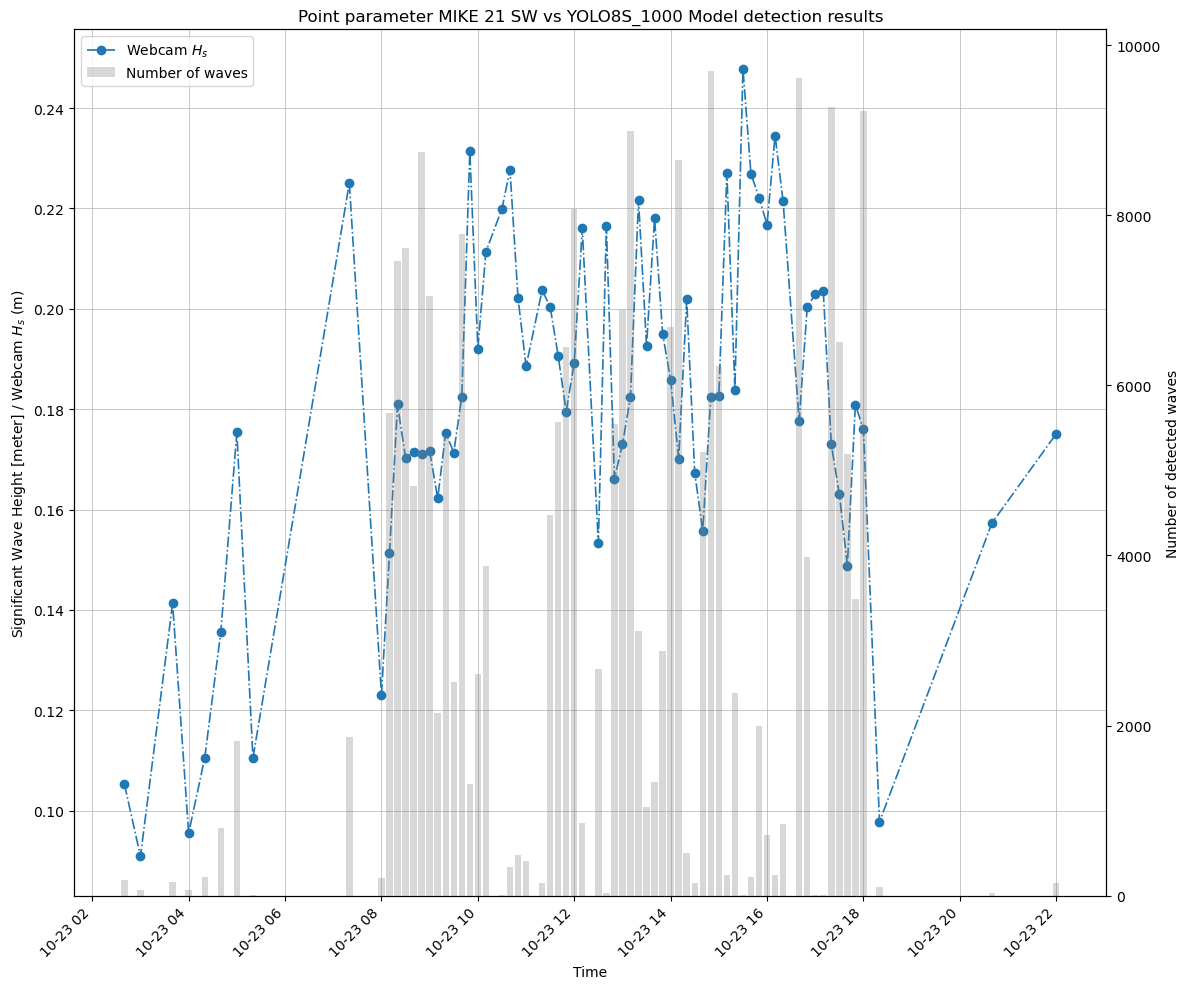

In [277]:
# 4. Plot: MIKE A/B + webcam Hs + wave count bars
# -------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 10))

# MIKE runs
#ax1.plot(time, values_A, label="MIKE run A: SD-0.15 Hz", linewidth=1.5)
#ax1.plot(time, values_B, label="MIKE run B: UV-0.15 Hz", linewidth=1.5, linestyle="--")

# Webcam Hs
ax1.plot(
    summary["time"],
    summary["Hs_m"],
    marker="o",
    linestyle="-.",
    linewidth=1.2,
    label="Webcam $H_s$",
)

ax1.set_xlabel("Time")
ax1.set_ylabel(f"Significant Wave Height [{param_unit}] / Webcam $H_s$ (m)")
ax1.set_title(f"Point parameter MIKE 21 SW vs YOLO8S_1000 Model detection results")
ax1.grid(True, linewidth=0.5)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Second axis: number of waves as bars
ax2 = ax1.twinx()
bar_width = 8 / (24 * 60)  # ≈ 8 minutes in days (for datetime x-axis)
ax2.bar(
    summary["time"],
    summary["number_of_waves"],
    width=bar_width,
    alpha=0.3,
    color="gray",
    label="Number of waves",
)
ax2.set_ylabel("Number of detected waves")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

save_plot = os.path.join(source_folder_deepL, "DATE_compare_MIKESW21_YOLO8S-1000.png")
plt.savefig(save_plot, dpi=300)

plt.tight_layout()
plt.show()

# Extract Model results as DFS0 format

In [124]:
# Search for any type containing "Height" or "Wave"
print("--- Available Types ---")
for e in EUMType:
    if "Height" in e.name or "Wave" in e.name or "Sign" in e.name or "Max" in e.name:
        print(f"Name: {e.name}, ID: {e.value}")

--- Available Types ---
Name: Wave_height, ID: 100084
Name: Wave_period, ID: 100085
Name: Wave_frequency, ID: 100086
Name: Wave_direction, ID: 100095
Name: Significant_wave_height, ID: 100097
Name: Wave_Disturbance_Coefficient, ID: 100106
Name: Max_Water, ID: 100193
Name: Height_Above_Ground, ID: 100364
Name: Cell_Height, ID: 100367
Name: Mean_Wave_Direction, ID: 100407
Name: Wave_amplitude, ID: 100460
Name: Active_Beach_Height, ID: 100509
Name: Maximum_wave_height, ID: 110019
Name: Wave_action_density, ID: 110035
Name: Wave_energy_density, ID: 110047
Name: Wave_energy_distribution, ID: 110048
Name: Wave_energy, ID: 110049
Name: Wave_action_density_rate, ID: 110053
Name: Wave_Power, ID: 110232
Name: Wave_Number, ID: 110247
Name: Height_Above_Keel, ID: 110258


In [125]:
# 5. EXPORT TO DFS0 (Reuse existing variables)
# -------------------------------------------------------------
print("--- Starting DFS0 Export ---")

# A. Extract Model and Date Tag from filename
# Pattern looks for text between "waves_" and the first date "YYYY-MM-DD"
filename = os.path.basename(summary_csv)
match = re.search(r"summary_\d+_waves_(.+?)_(\d{4}-\d{2}-\d{2})", filename)

if match:
    model = match.group(1)      # e.g., yolov8s-1000_150e
    date_tag = match.group(2)   # e.g., 2025-10-23
    print(f"Detected Model: {model}")
    print(f"Detected Date:  {date_tag}")
else:
    # Fallback if filename format changes
    print("⚠️ Warning: Could not parse filename. Using defaults.")
    date_tag = "UNKNOWN_DATE"
    model = "UNKNOWN_MODEL"

# B. Prepare DataFrame for Export
# Ensure we are working with a time-indexed copy sorted by time
df_export = summary.copy()
df_export = df_export.set_index("time").sort_index()

# Handle potential duplicate times (rare but possible in webcam data) if any
if df_export.index.duplicated().any():
    print("⚠️ Duplicate timestamps found. Keeping first occurrence.")
    df_export = df_export[~df_export.index.duplicated(keep='first')]

# C. Create MIKE IO DataArrays (Safe Proxy Method)
# -------------------------------------------------------------
# We use Water Level (ID 10000) because it is always valid and uses Meters.
# This bypasses the missing "Wave Height" definition in your environment.

# 1. Significant Wave Height (stored as Water Level)
da_hs = DataArray(
    data=df_export["Hs_m"].values,
    time=df_export.index,
    item=ItemInfo("Significant Wave Height", EUMType.Significant_wave_height, EUMUnit.meter)
)

# 2. Maximum Wave Height (stored as Water Level)
da_hmax = DataArray(
    data=df_export["max_height_m"].values,
    time=df_export.index,
    item=ItemInfo("Max Wave Height", EUMType.Maximum_wave_height, EUMUnit.meter)
)

# D. Create Dataset and Write
# -------------------------------------------------------------
ds = Dataset([da_hmax, da_hs])

DL_dfs0_name = f"{date_tag}_{model}_results.dfs0"
DL_dfs0_path = os.path.join(source_folder_mike21sw, DL_dfs0_name)

ds.to_dfs(DL_dfs0_path, title=f"DeepL Waves: {model} - {date_tag}")

print(f"✅ Successfully wrote DFS0: {DL_dfs0_path}")

--- Starting DFS0 Export ---
Detected Model: yolov8s-5000_150e
Detected Date:  2025-08-09
✅ Successfully wrote DFS0: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\2025-08-09_yolov8s-5000_150e_results.dfs0


# Extract Wind Speed and Direction in MIKE DFS0 format 

In [610]:
#pip install pymysql

In [747]:
import os
import subprocess
from pathlib import Path
from datetime import datetime, timedelta, timezone
from dateutil import tz
import pandas as pd
from sqlalchemy import create_engine, text
import shutil, subprocess
import pymysql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.transforms as transforms

In [623]:
# Connect to wind database
engine = create_engine(
    f"mysql+pymysql://{os.getenv('DB_USER')}:{os.getenv('DB_PASS')}"
    f"@{os.getenv('DB_HOST')}:{int(os.getenv('DB_PORT', 3306))}/{os.getenv('DB_NAME')}",
    pool_pre_ping=True,
    future=True,
)

# Three station views from database
VIEWS = ["v_windninja_export_fru", "v_windninja_export_int", "v_windninja_export_thu"] 

# time in views CET/CEST automatically handled
LOCAL_TZ = tz.gettz("Europe/Zurich")

# The exact column order you said the view provides:
WN_HEADERS = [
    "Station_Name","Coord_Sys(PROJCS,GEOGCS)","Datum(WGS84,NAD83,NAD27)",
    "Lat/YCoord","Lon/XCoord","Height","Height_Units(meters,feet)",
    "Speed","Speed_Units(mph,kph,mps,kts)","Direction(degrees)",
    "Temperature","Temperature_Units(F,C)","Cloud_Cover(%)",
    "Radius_of_Influence","Radius_of_Influence_Units(miles,feet,meters,km)",
    "date_time"
]

In [488]:
try:
    with engine.connect() as connection:
        print("✅ Connection successful!")
except Exception as e:
    print("❌ Connection failed!")
    print(e)

✅ Connection successful!


In [850]:
# --- Time window in LOCAL time (matches tz_local column) ---
time_start = pd.Timestamp("2025-08-09 02:00")
time_end   = pd.Timestamp("2025-08-09 23:50")

# --- Time window in LOCAL time (matches tz_local column) ---
#time_start = pd.Timestamp("2025-08-24 02:00")
#time_end   = pd.Timestamp("2025-08-24 23:50")

# --- Time window in LOCAL time (matches tz_local column) ---
#time_start = pd.Timestamp("2025-10-23 02:00")
#time_end   = pd.Timestamp("2025-10-23 23:50")

# --- Time window in LOCAL time (matches tz_local column) ---
#time_start = pd.Timestamp("2025-10-20 02:00")
#time_end   = pd.Timestamp("2025-10-26 23:50")

# --- Time window in LOCAL time (matches tz_local column) ---
#time_start = pd.Timestamp("2025-08-01 02:00")
#time_end   = pd.Timestamp("2025-08-31 23:50")

# If you want a specific station, set it here (e.g. 'THU', 'FRU', 'INT')
STATION_ID = None       # all stations
#STATION_ID = "THU"
#STATION_ID = "FRU"
#STATION_ID = "INT"


In [851]:
# QUERY DATA FROM meteo_obs
# =========================================================

sql = """
SELECT
    tz_local,
    wind_speed_ms,
    wind_dir_deg,
    station_id
FROM meteo_obs
WHERE tz_local BETWEEN :t0 AND :t1
  AND data_type = 'observation'
  {station_clause}
ORDER BY tz_local
"""

station_clause = ""
params = {"t0": time_start, "t1": time_end}

if STATION_ID is not None:
    station_clause = "AND station_id = :sid"
    params["sid"] = STATION_ID

sql = sql.format(station_clause=station_clause)

df = pd.read_sql(text(sql), engine, params=params)

if df.empty:
    raise ValueError("No data returned for this time window / station.")

# ensure datetime and sort
df["tz_local"] = pd.to_datetime(df["tz_local"])
df = df.sort_values("tz_local").reset_index(drop=True)

# set index for convenience
df = df.set_index("tz_local")

df.head()

wind_speed_ms  wind_dir_deg station_id
tz_local                                                   
2025-08-09 02:00:00            0.3         246.0        FRU
2025-08-09 02:00:00            0.6         328.0        INT
2025-08-09 02:00:00            0.4         353.0        THU
2025-08-09 02:10:00            0.6         232.0        FRU
2025-08-09 02:10:00            0.6         219.0        INT

In [852]:
# CREATE AND SAVE 3 DFS0 FILES FOR EACH STATION
# =========================================================

# --- YOUR SETUP ---
# Ensure datetime index
df = df.sort_index()
if not isinstance(df.index, pd.DatetimeIndex):
    df["tz_local"] = pd.to_datetime(df["tz_local"])
    df = df.set_index("tz_local")

date_tag = time_start.strftime("%Y-%m-%d")
stations_to_export = ["THU", "INT", "FRU"]

# --- EXPORT LOOP ---
for station_tag in stations_to_export:

    df_st = df[df["station_id"] == station_tag].copy()
    if df_st.empty:
        print(f"⚠️ No data for station {station_tag}, skipping.")
        continue

    # --- CREATE DATA ARRAYS (The robust 1.x way) ---
    # 1. Create DataArray for Wind Speed
    da_ws = DataArray(
        data=df_st["wind_speed_ms"].values,
        time=df_st.index,
        item=ItemInfo("Wind speed", EUMType.Wind_speed, EUMUnit.meter_per_sec)
    )

    # 2. Create DataArray for Wind Direction
    da_wd = DataArray(
        data=df_st["wind_dir_deg"].values,
        time=df_st.index,
        item=ItemInfo("Wind direction", EUMType.Wind_Direction, EUMUnit.degree)
    )

    # 3. Combine into a Dataset
    ds = Dataset([da_ws, da_wd])

    # --- WRITE TO DFS0 ---
    dfs0_name = f"{date_tag}_{station_tag}_wind-speed-dir_obs.dfs0"
    dfs0_path = os.path.join(source_folder_mike21sw, dfs0_name)

    ds.to_dfs(dfs0_path, title=f"{station_tag} wind obs")

    print(f"✅ Wrote DFS0: {dfs0_path}")

✅ Wrote DFS0: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\2025-08-09_THU_wind-speed-dir_obs.dfs0
✅ Wrote DFS0: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\2025-08-09_INT_wind-speed-dir_obs.dfs0
✅ Wrote DFS0: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\2025-08-09_FRU_wind-speed-dir_obs.dfs0


# Extract Wind Speed and Direction in CSV Format 

In [813]:
# 1. Build dynamic filename
# -----------------------------------------------------------

# Extract date from time_start
date_tag = time_start.strftime("%Y-%m-%d")

# Station tag (or ALL)
station_tag = STATION_ID if STATION_ID is not None else "ALL"

# Final filename
csv_name = f"{date_tag}_{station_tag}_wind-speed-dir_obs.csv"
csv_path = os.path.join(source_folder_mike21sw, csv_name)

# -----------------------------------------------------------
# 2. Save dataframe
# -----------------------------------------------------------
df.to_csv(csv_path, index=True)   # index=True keeps the tz_local timestamp index

print("CSV saved to:")
print(csv_path)

CSV saved to:
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\2025-08-01_INT_wind-speed-dir_obs.csv


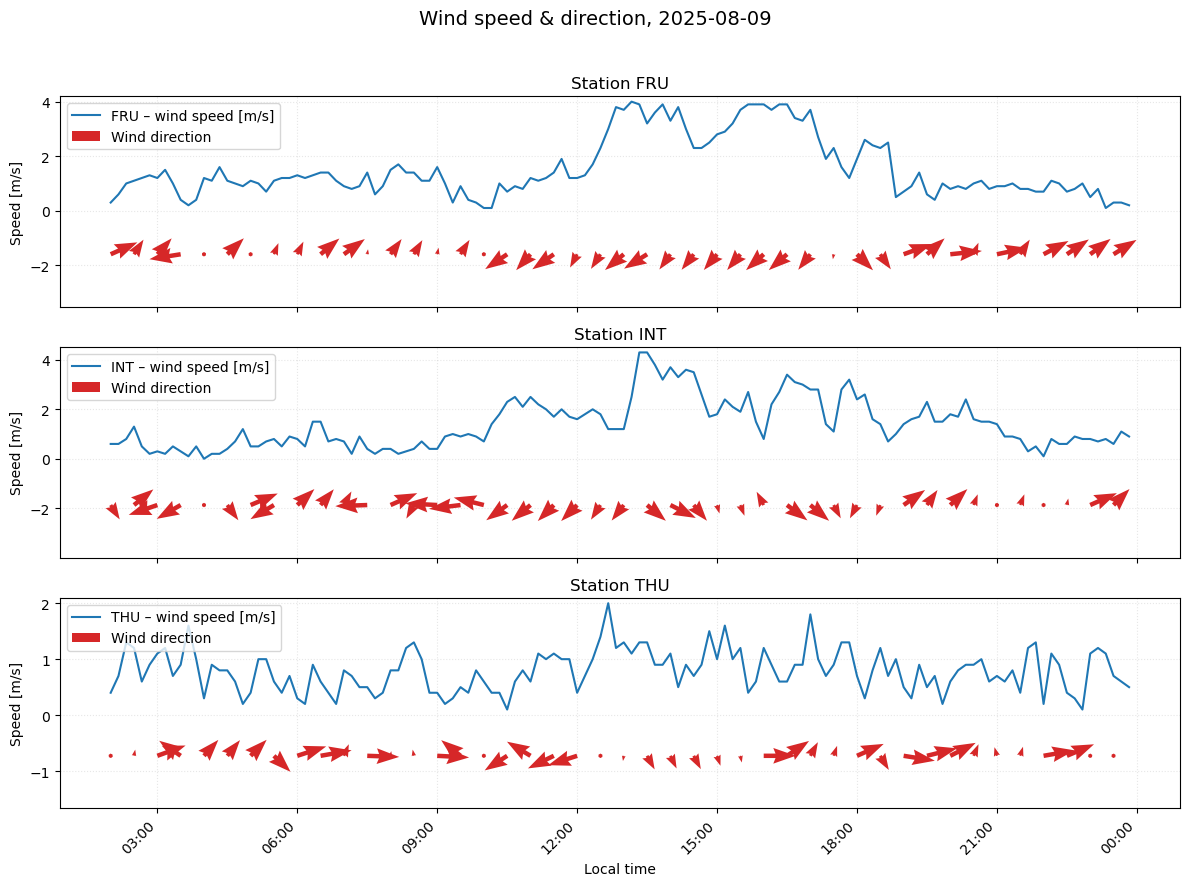

In [766]:
stations = sorted(df["station_id"].unique())
n_stations = len(stations)

fig, axes = plt.subplots(
    n_stations, 1,
    figsize=(12, 3 * n_stations),
    sharex=True
)
if n_stations == 1:
    axes = [axes]

for ax, st in zip(axes, stations):
    ds = df[df["station_id"] == st].copy()
    if ds.empty:
        ax.set_visible(False)
        continue

    # ----------------------
    # Wind-speed line
    # ----------------------
    ax.plot(
        ds.index,
        ds["wind_speed_ms"],
        label=f"{st} – wind speed [m/s]",
        linewidth=1.5,
    )
    ax.set_ylabel("Speed [m/s]")
    ax.grid(alpha=0.3, linestyle=":")

    # --- EXPAND LOWER Y-LIMIT ---
    ymin, ymax = ax.get_ylim()
    span = ymax - ymin
    ax.set_ylim(ymin - 0.8 * span, ymax)   # greatly expands area for arrows

    # ----------------------
    # Wind-direction arrows
    # ----------------------
    N_SKIP = 3
    ds_ar = ds.iloc[::N_SKIP, :]

    theta = np.deg2rad(ds_ar["wind_dir_deg"].values)
    u_plot = -np.sin(theta)
    v_plot = -np.cos(theta)

    t_num = mdates.date2num(ds_ar.index.to_pydatetime())

    # Place arrows DEEPER in the new y-space
    y_axes = 0.25      # negative = below true axis bottom
    y_axes_arr = np.full_like(t_num, y_axes, dtype=float)

    # Blended transform
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.quiver(
        t_num,
        y_axes_arr,
        u_plot,
        v_plot,
        transform=trans,
        angles="uv",
        scale_units="xy",
        scale=35,            # constant visual length
        width=0.004,
        headwidth=3.5,
        headlength=5,
        color="tab:red",
        zorder=4,
        clip_on=False,       # do NOT clip arrow heads
        label="Wind direction",
    )

    ax.set_title(f"Station {st}")
    ax.legend(loc="upper left")

# Shared formatting
axes[-1].set_xlabel("Local time")
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha="right")

fig.suptitle(f"Wind speed & direction, {time_start.date()}", y=0.98, fontsize=14)

save_plot = os.path.join(source_folder_mike21sw, "DATE_wind_speed_dir_observations.png")
plt.savefig(save_plot, dpi=300)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculation of Correlation Wind Observations and Hs and Hmax

In [222]:
import pandas as pd
import mikeio
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [230]:
# user selected date

#DATE ="2025-08-09"
DATE ="2025-08-24"
#DATE ="2025-10-23"


In [231]:
# --- Configuration ---
# List of your wind observation CSV files
# Add your Thun file here if available (e.g., '2025-10-23_THU_wind-speed-dir_obs.csv')
wind_files = [
    f"{DATE}_FRU_wind-speed-dir_obs.csv",
    f"{DATE}_THU_wind-speed-dir_obs.csv",
    f"{DATE}_INT_wind-speed-dir_obs.csv"
]

# List of your model result DFS0 files
model_files = [
    f"{DATE}_yolov8n-1000_50e_results.dfs0",
    f"{DATE}_yolov8n-1000_150e_results.dfs0",
    f"{DATE}_yolov8s-1000_150e_results.dfs0",
    f"{DATE}_yolov8s-5000_150e_results.dfs0"
]

# --- Configuration for Model Names ---
# I adjusted the keys slightly to match your filenames (which use hyphens like '1000-50e')
model_reference_map = {
    "yolov8n-1000_50e": "Model-1",
    "yolov8n-1000_150e": "Model-2",
    "yolov8s-1000_150e": "Model-3",
    "yolov8s-5000_150e": "Model-4"
}

# Output directory for plots (optional)
corr_folder_name = f"correlation_plots"
output_dir = os.path.join(source_folder_mike21sw, corr_folder_name)
os.makedirs(output_dir, exist_ok=True)

# Create full paths for wind files
wind_files = [os.path.join(source_folder_mike21sw, f) for f in wind_files]

# Create full paths for model files
model_files = [os.path.join(source_folder_mike21sw, f) for f in model_files]

In [232]:
# --- Step 1: Load and Prepare Wind Data ---
print("Loading wind observation data...")
wind_dfs = []

for file_path in wind_files:
    if os.path.exists(file_path):
        # Read CSV
        df = pd.read_csv(file_path)
        
        # Parse timestamp
        df['time'] = pd.to_datetime(df['tz_local'])
        df = df.set_index('time')
        
        # Identify station (FRU, INT, THU) from filename or column
        # Assuming filename format is "Date_STATION_..."
        station_code = os.path.basename(file_path).split('_')[1] 
        
        # Rename columns to include station code
        df = df[['wind_speed_ms', 'wind_dir_deg']].rename(columns={
            'wind_speed_ms': f'WindSpd_{station_code}',
            'wind_dir_deg': f'WindDir_{station_code}'
        })
        
        wind_dfs.append(df)
    else:
        print(f"Warning: Wind file not found: {file_path}")

if not wind_dfs:
    raise FileNotFoundError("No wind data files found.")

# Combine all wind stations into one dataframe (merges on time index)
wind_data = pd.concat(wind_dfs, axis=1, join='outer')

# Ensure wind data is sorted by time
wind_data = wind_data.sort_index()

# Handle potential duplicate times if any
wind_data = wind_data.groupby(wind_data.index).first()



Loading wind observation data...



Processing: Model-1 (File: 2025-08-24_yolov8n-1000_50e_results.dfs0)
Saved: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\CorrMatrix_Model-1.png


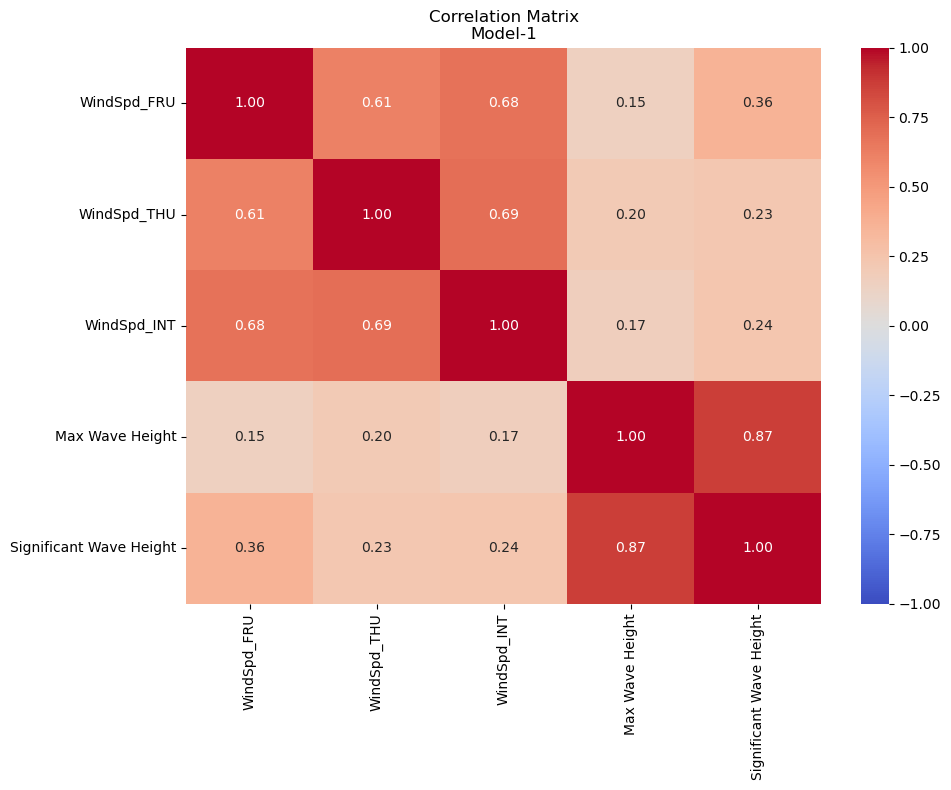

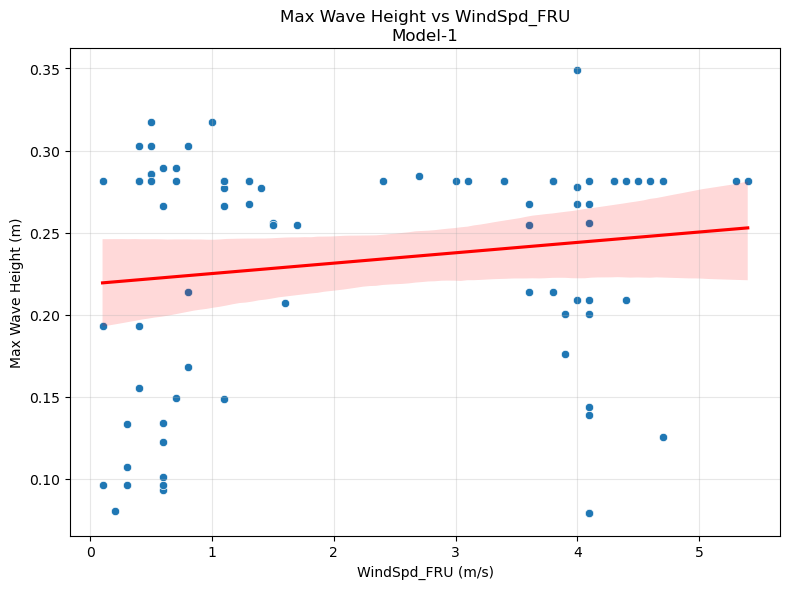

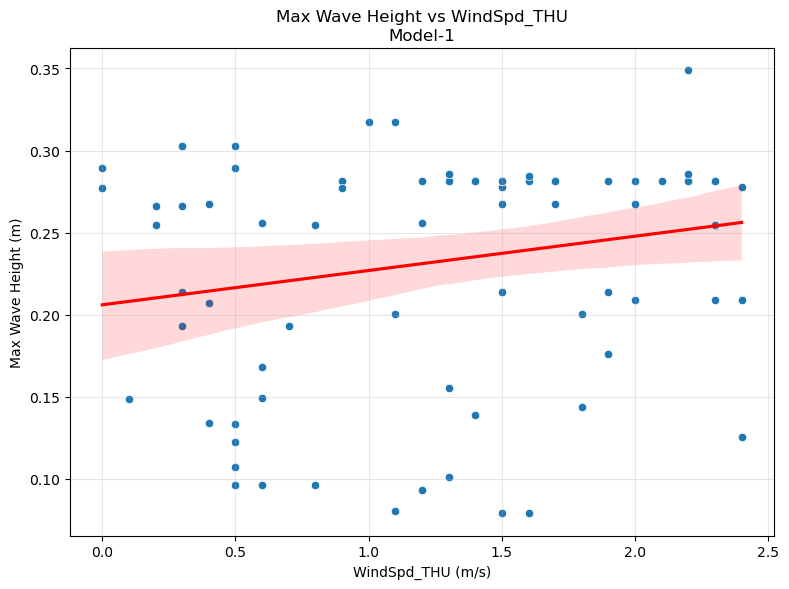

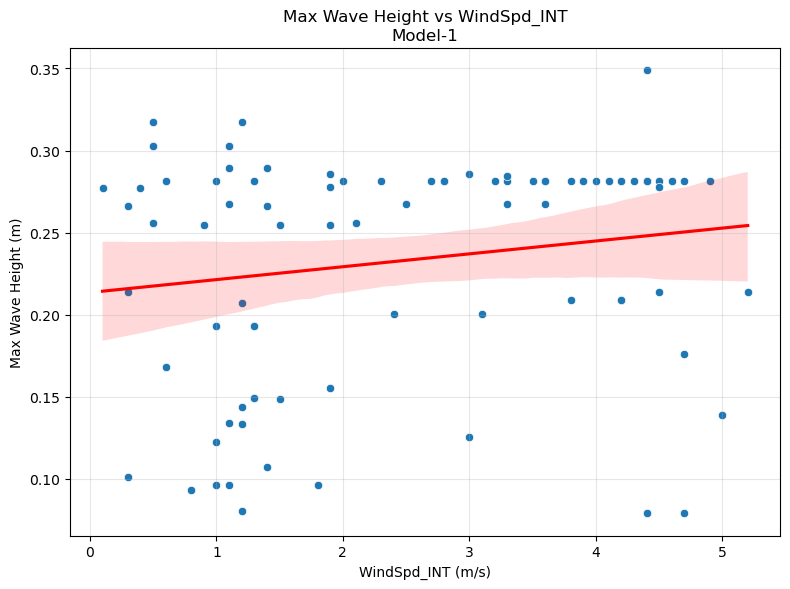

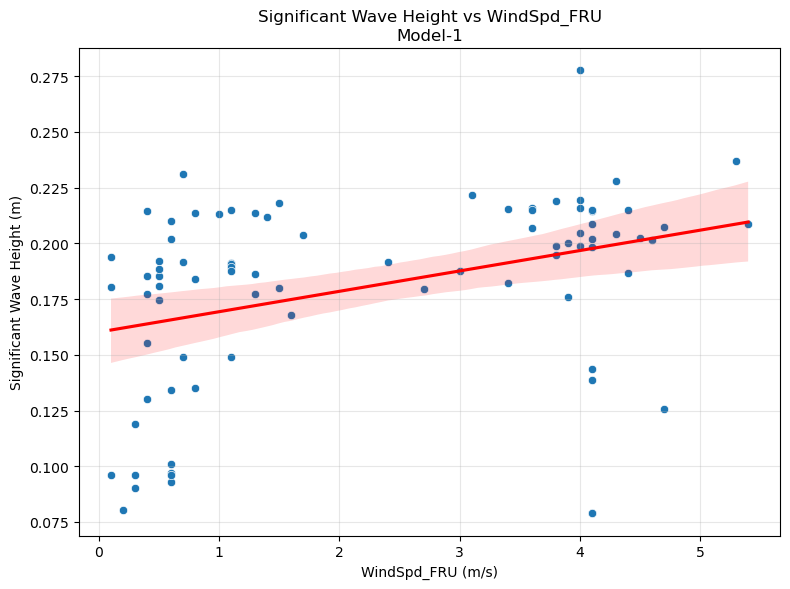

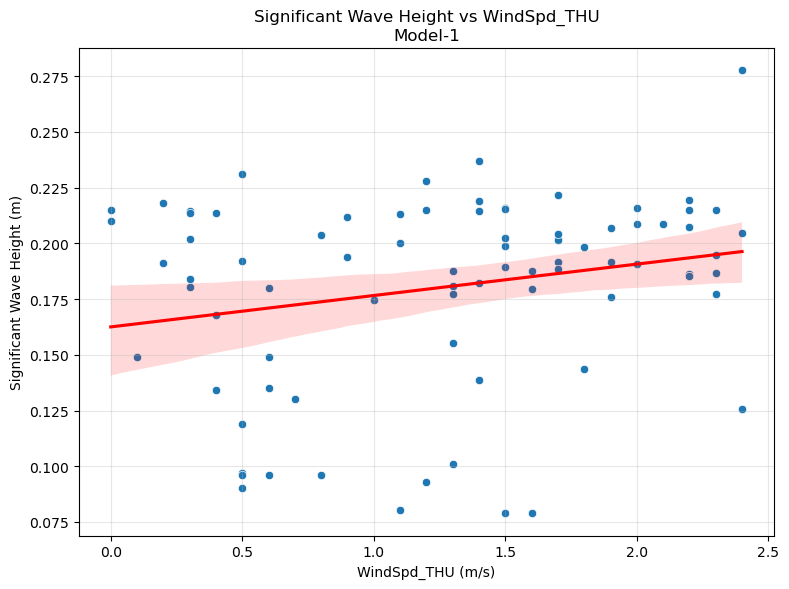

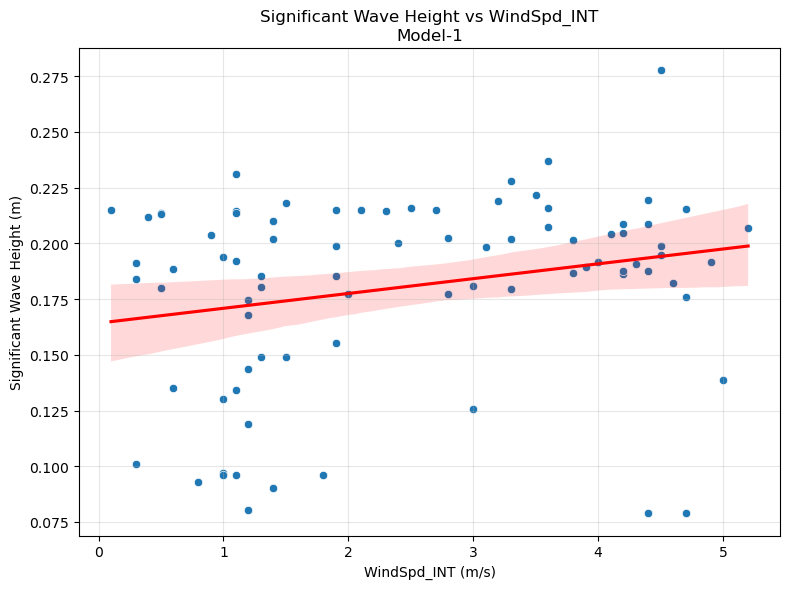


Processing: Model-2 (File: 2025-08-24_yolov8n-1000_150e_results.dfs0)
Saved: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\CorrMatrix_Model-2.png


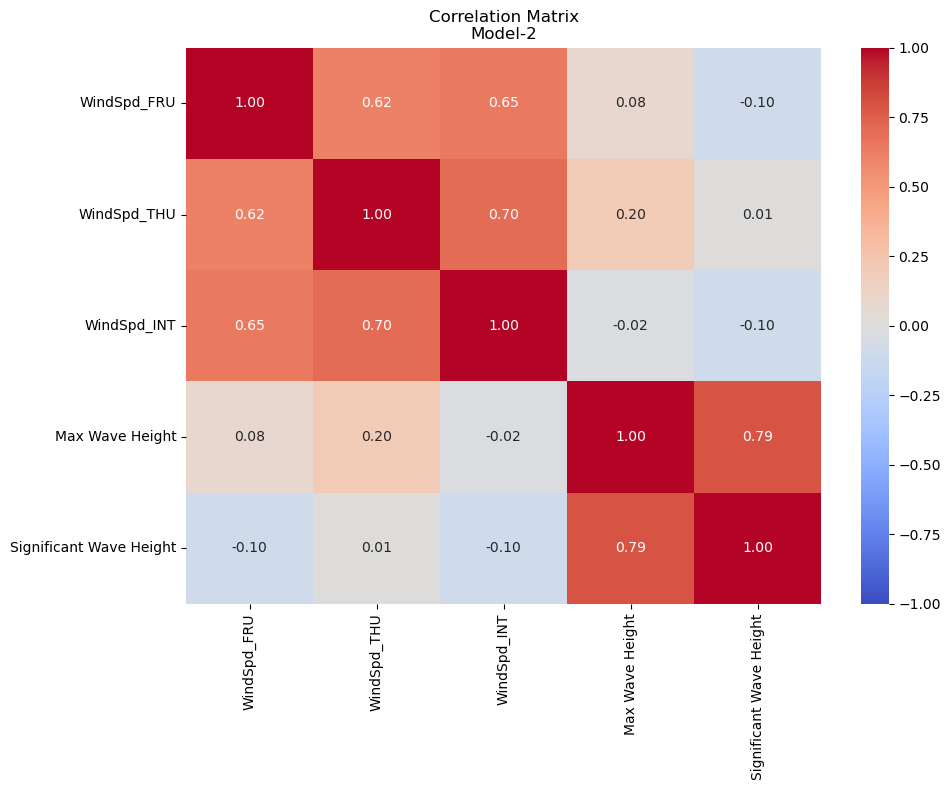

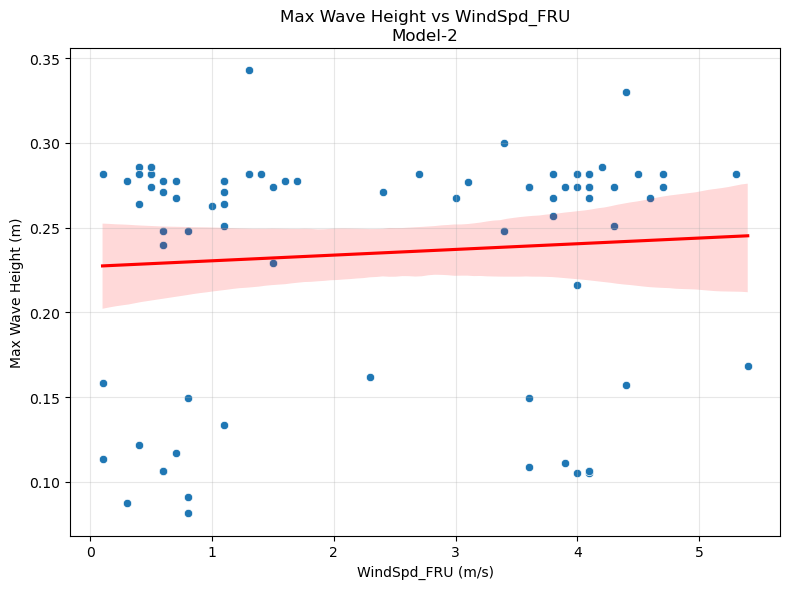

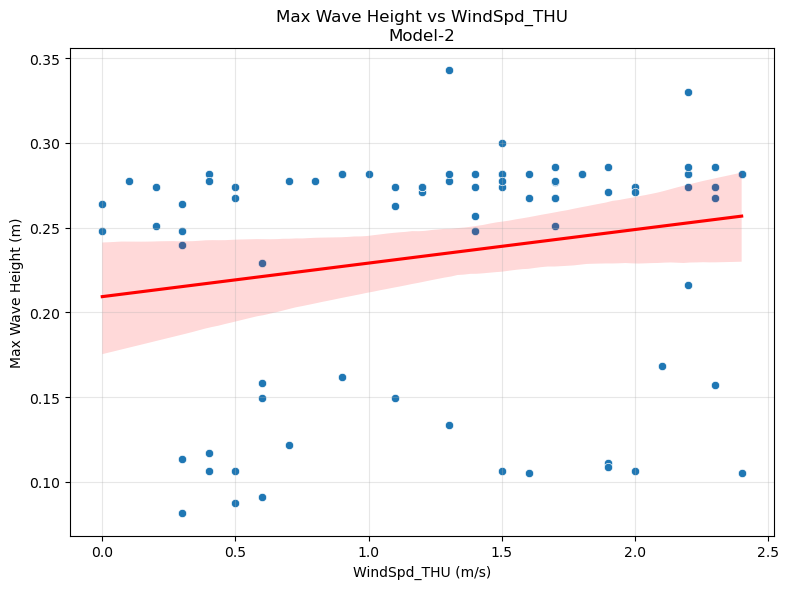

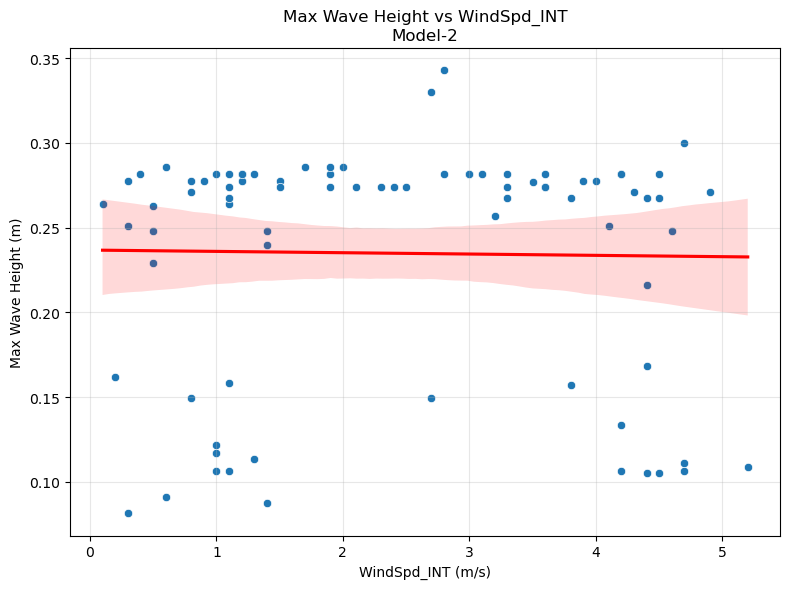

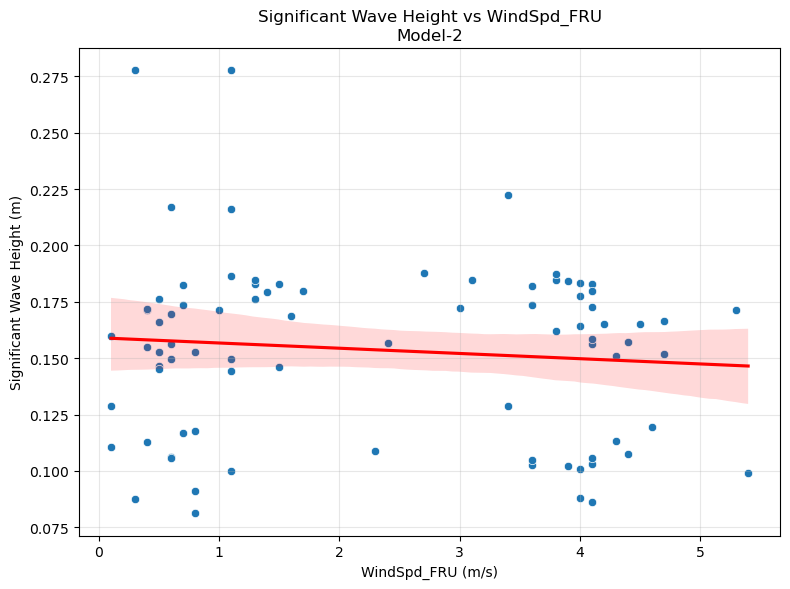

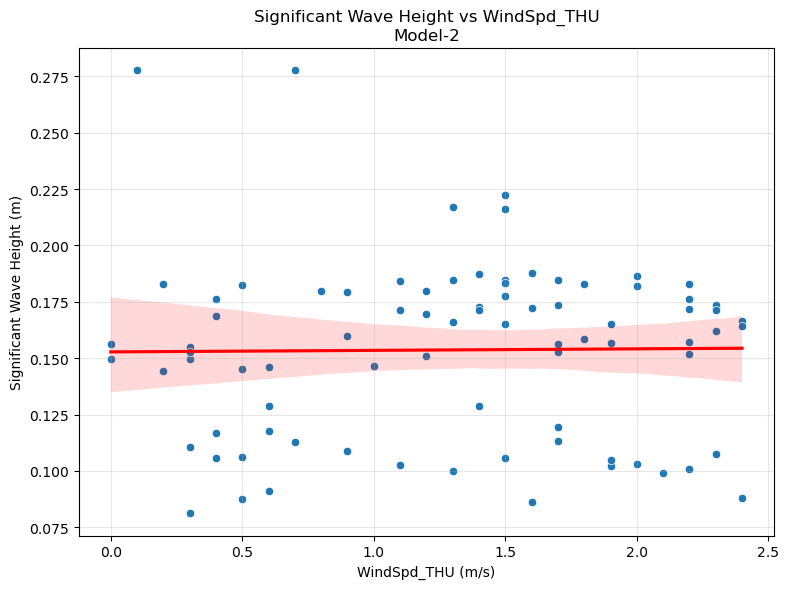

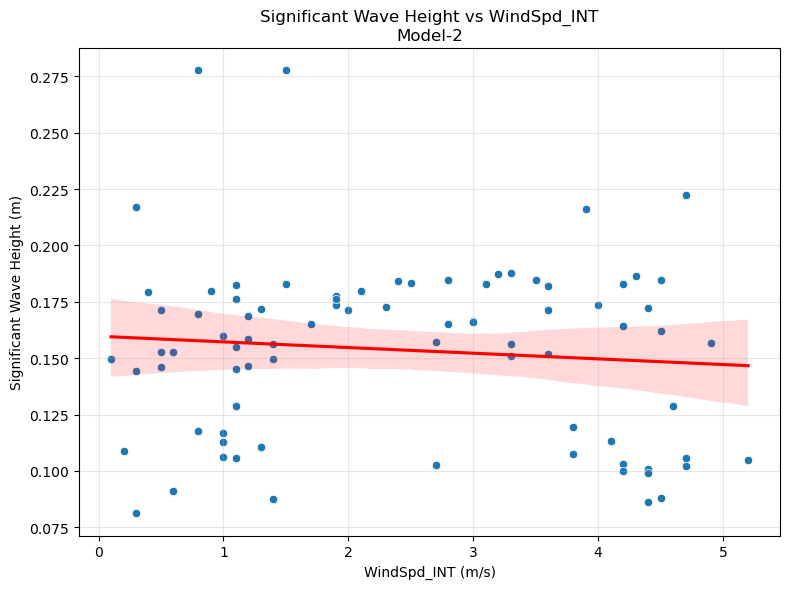


Processing: Model-3 (File: 2025-08-24_yolov8s-1000_150e_results.dfs0)
Saved: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\CorrMatrix_Model-3.png


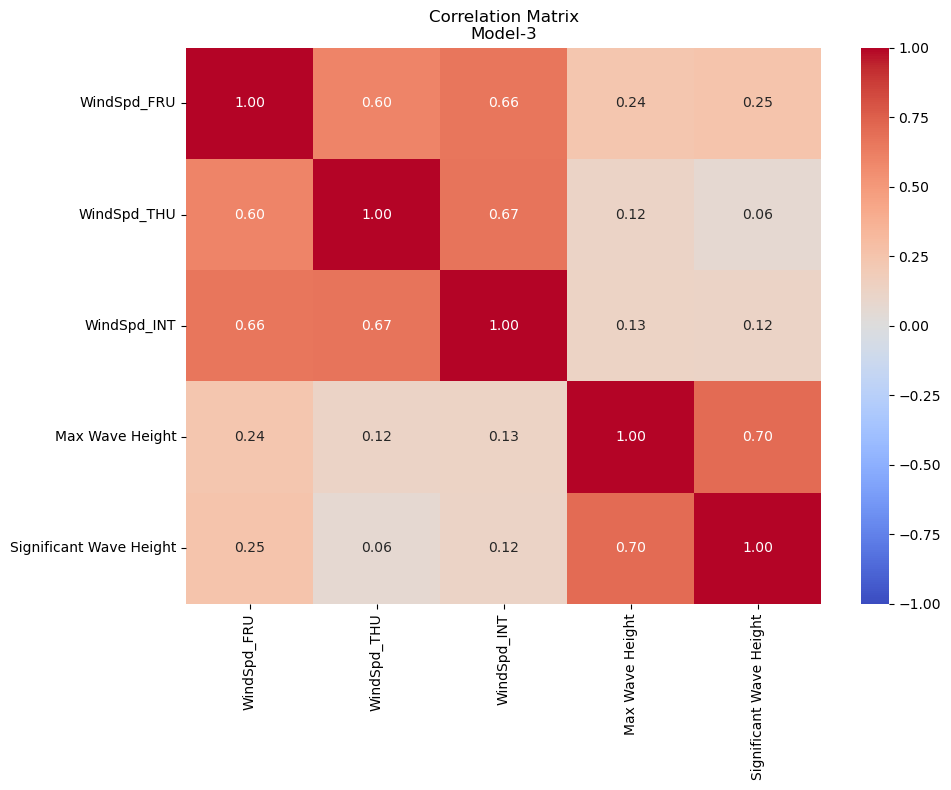

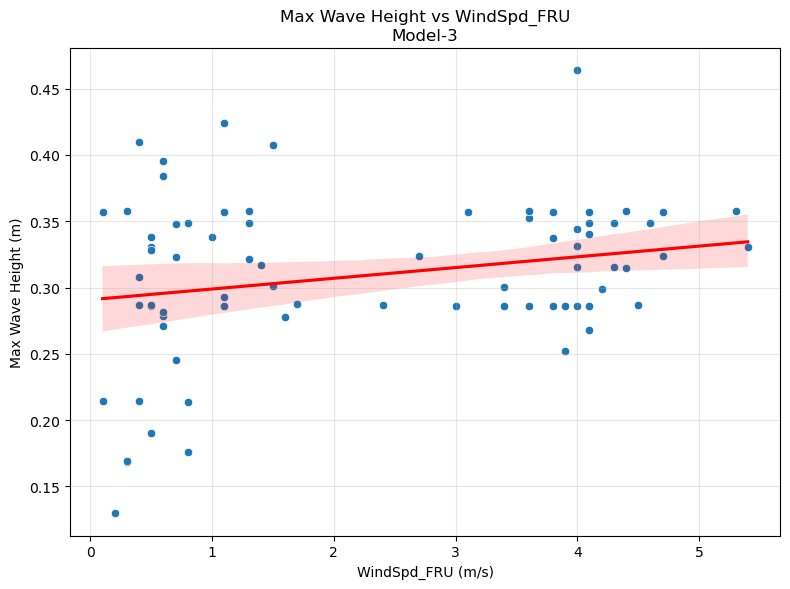

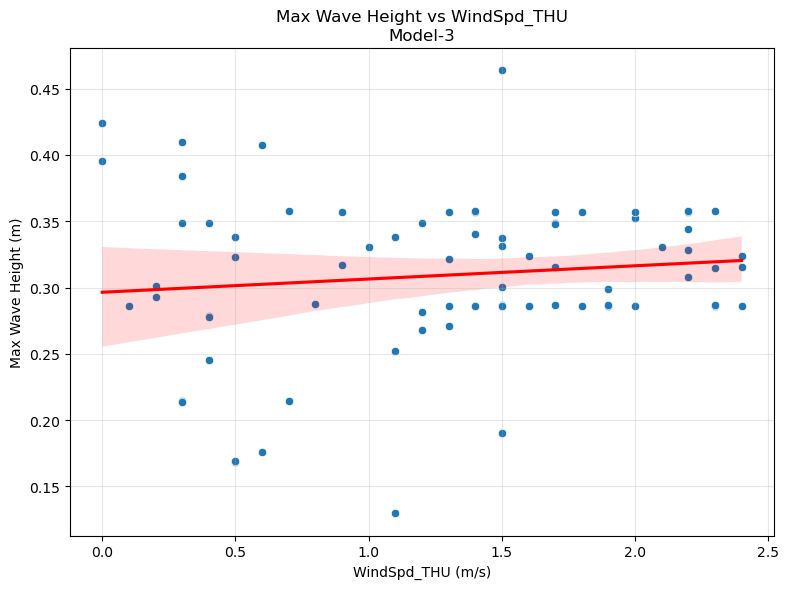

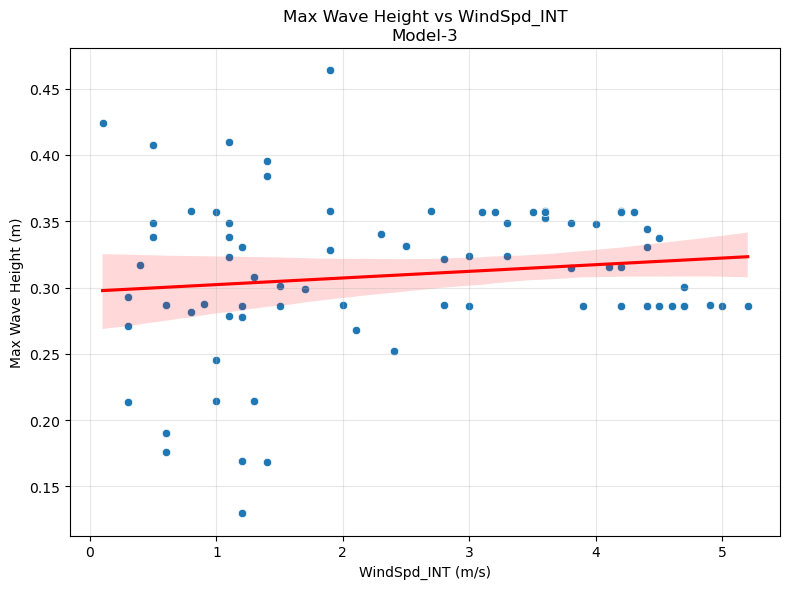

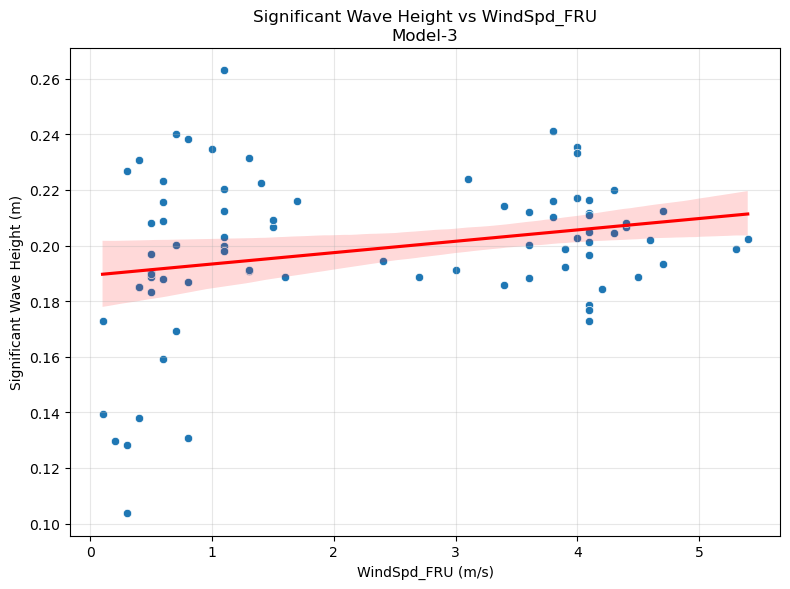

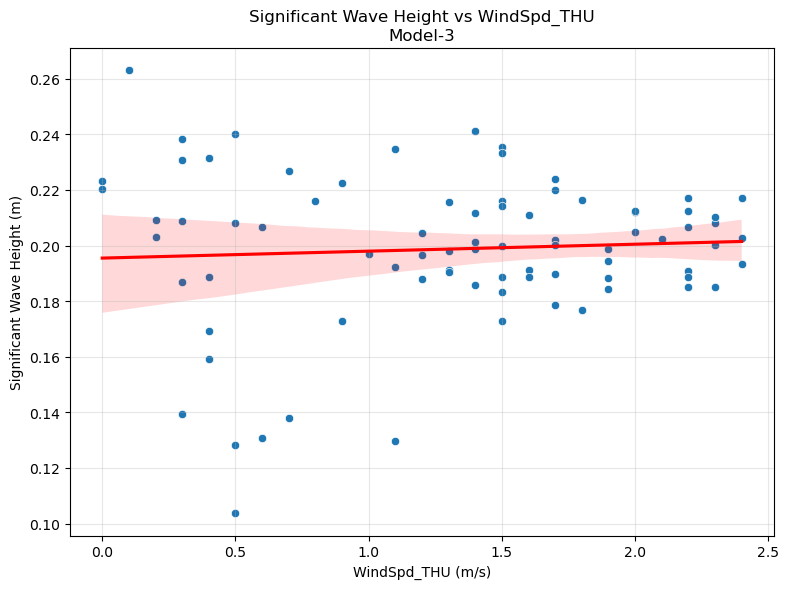

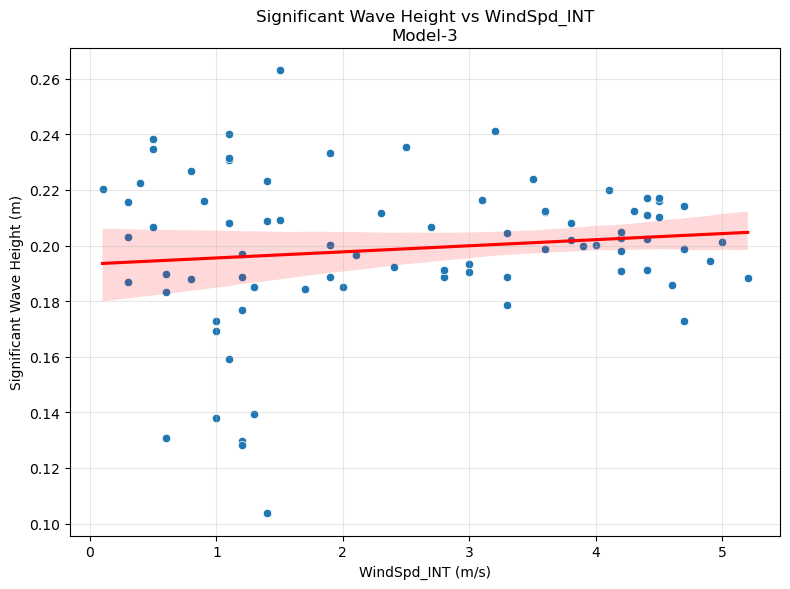


Processing: Model-4 (File: 2025-08-24_yolov8s-5000_150e_results.dfs0)
Saved: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\CorrMatrix_Model-4.png


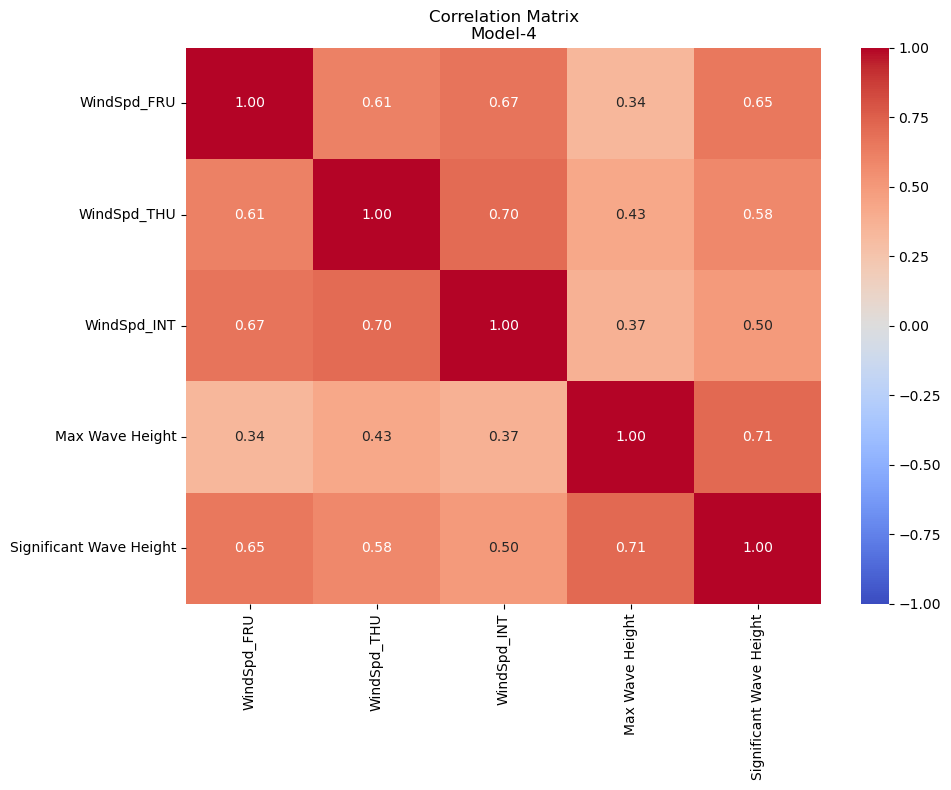

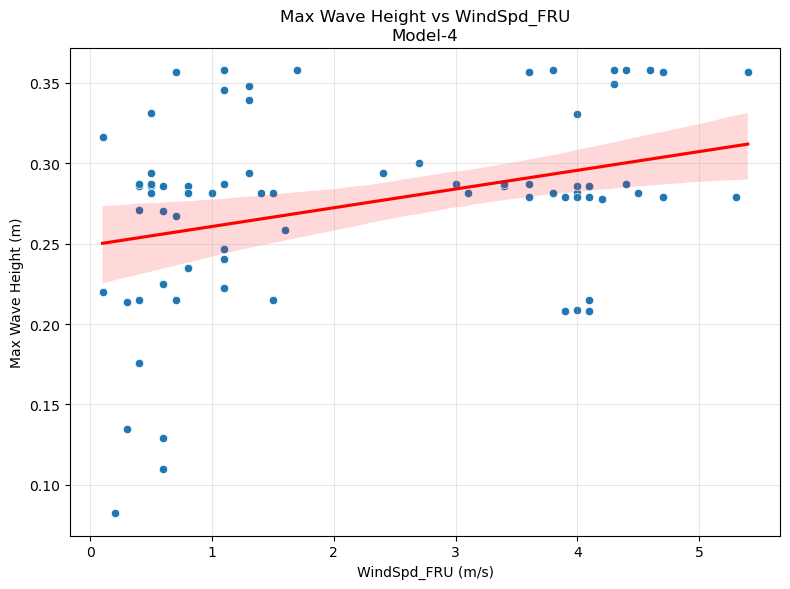

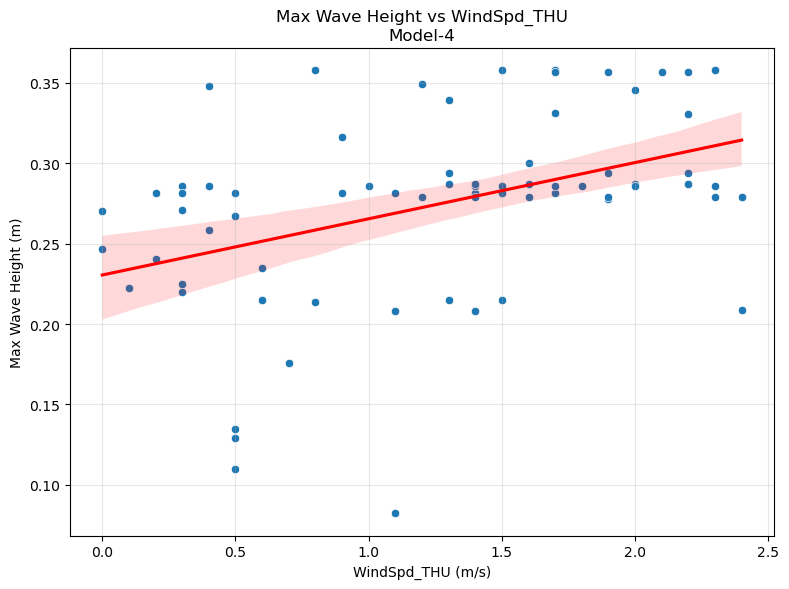

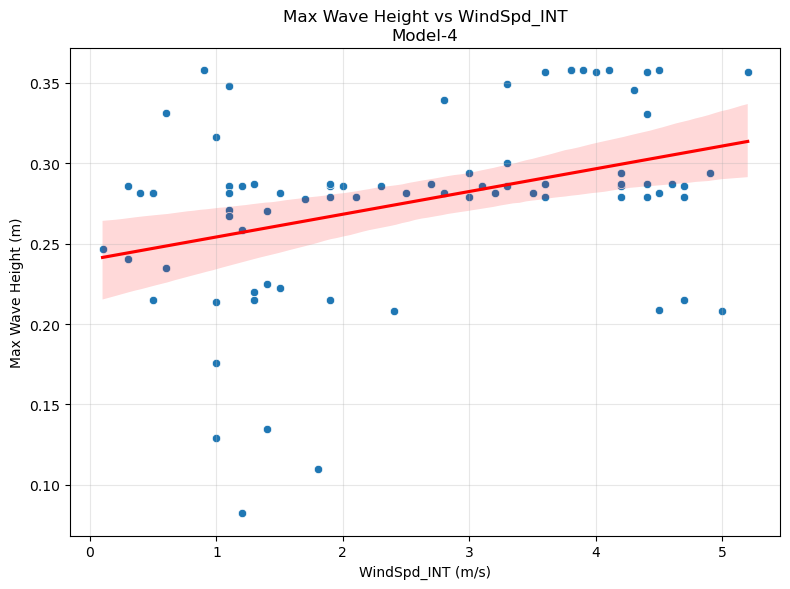

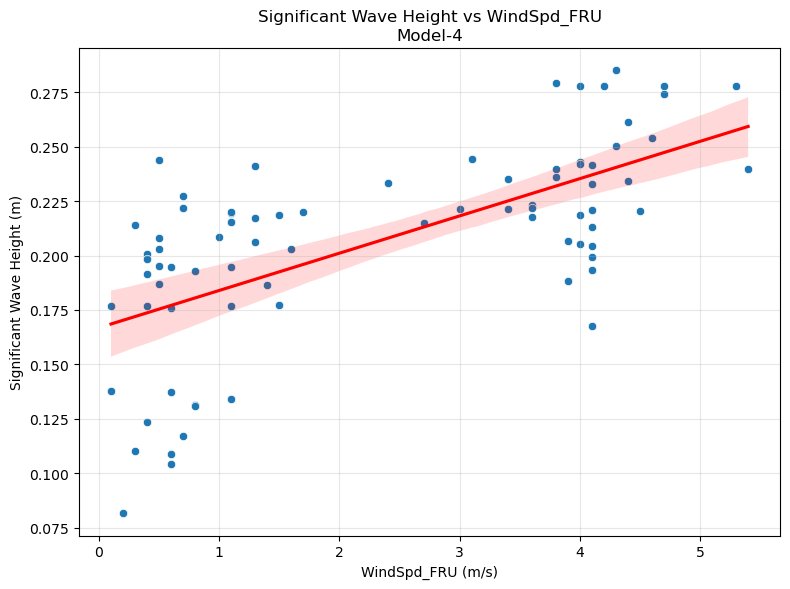

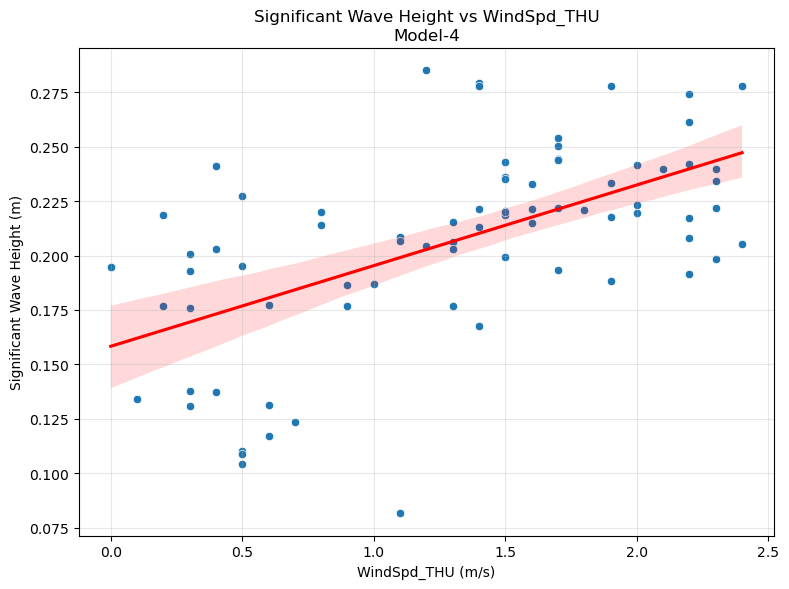

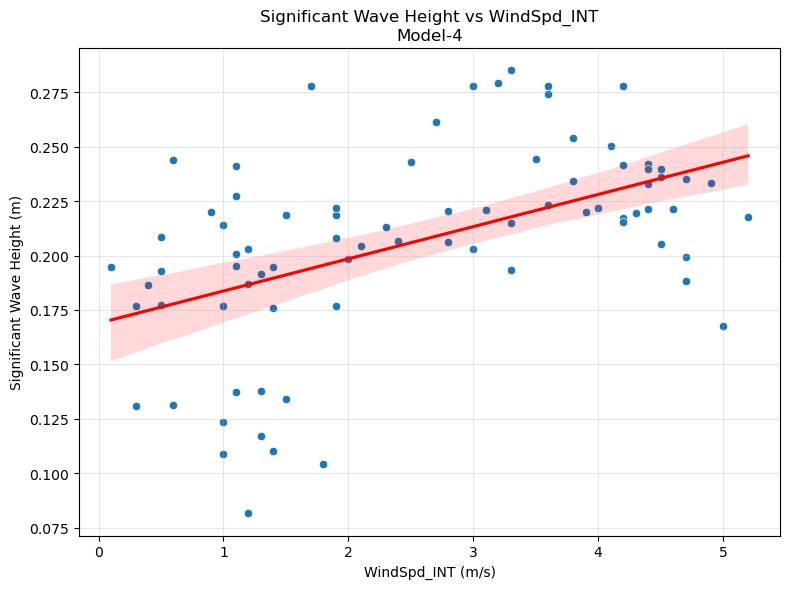

In [233]:
# --- Step 2: Process Each Model ---
for model_file in model_files:
    if not os.path.exists(model_file):
        print(f"Skipping missing model file: {model_file}")
        continue
        
    # 1. Determine the Model Reference Name
    filename = os.path.basename(model_file)
    model_ref = filename # Default to filename if no match found
    
    # Check which key is inside the filename
    for key, pretty_name in model_reference_map.items():
        if key in filename:
            model_ref = pretty_name
            break
    
    print(f"\nProcessing: {model_ref} (File: {filename})")
    
    # 2. Read DFS0 file
    ds = mikeio.read(model_file)
    df_model = ds.to_dataframe()
    
    # Add the requested reference column
    df_model["model_reference"] = model_ref
    
    # Ensure index is datetime and naive
    if df_model.index.tz is not None:
         df_model.index = df_model.index.tz_localize(None)
    
    # --- Step 3: Merge Wind and Wave Data ---
    merged_df = pd.merge(wind_data, df_model, left_index=True, right_index=True, how='inner')
    
    if merged_df.empty:
        print("No overlapping timestamps found.")
        continue
    
    # --- Step 4: Correlation Matrix (FILTERED) ---
    
    # Define columns to keep: Only 'WindSpd' and Wave Heights. 
    # This filters out 'WindDir', 'U', 'V', etc.
    cols_to_corr = [
        c for c in merged_df.columns 
        if "WindSpd" in c 
        or "Significant Wave Height" in c 
        or "Max Wave Height" in c
    ]
    
    # Calculate correlation only on these columns
    corr_matrix = merged_df[cols_to_corr].corr()
    
    # Create safe filename string (replace spaces/dashes with underscores)
    safe_model_name = model_ref.replace(" – ", "_").replace("–", "-").replace(" ", "_")
    
    # Plot Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix\n{model_ref}') # Uses nice name
    plt.tight_layout()
    
    # Save with nice name
    plot_filename = os.path.join(output_dir, f'CorrMatrix_{safe_model_name}.png')
    plt.savefig(plot_filename)
    print(f"Saved: {plot_filename}")
    plt.show()
    
    # --- Step 5: Scatter Plots ---
    wave_cols = [c for c in df_model.columns if "Significant Wave Height" in c or "Max Wave Height" in c]
    wind_spd_cols = [c for c in wind_data.columns if "WindSpd" in c]
    
    for wave_col in wave_cols:
        for wind_col in wind_spd_cols:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=merged_df, x=wind_col, y=wave_col)
            
            # Regression line
            sns.regplot(data=merged_df, x=wind_col, y=wave_col, scatter=False, color='red')
            
            plt.title(f'{wave_col} vs {wind_col}\n{model_ref}') # Uses nice name
            plt.xlabel(f'{wind_col} (m/s)')
            plt.ylabel(f'{wave_col} (m)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            # Clean up column names for filename (e.g., "Significant Wave Height" -> "SigWave")
            short_wave = "Hs" if "Significant" in wave_col else "Hmax"
            
            scatter_filename = os.path.join(output_dir, f'Scatter_{wind_col}_vs_{short_wave}_{safe_model_name}.png')
            plt.savefig(scatter_filename)
            plt.show()


Generating aggregated correlation matrices...
Saved Hs matrix to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\2025-08-24_Hs_CorrMatrix_AGGREGATED_AllModels.png


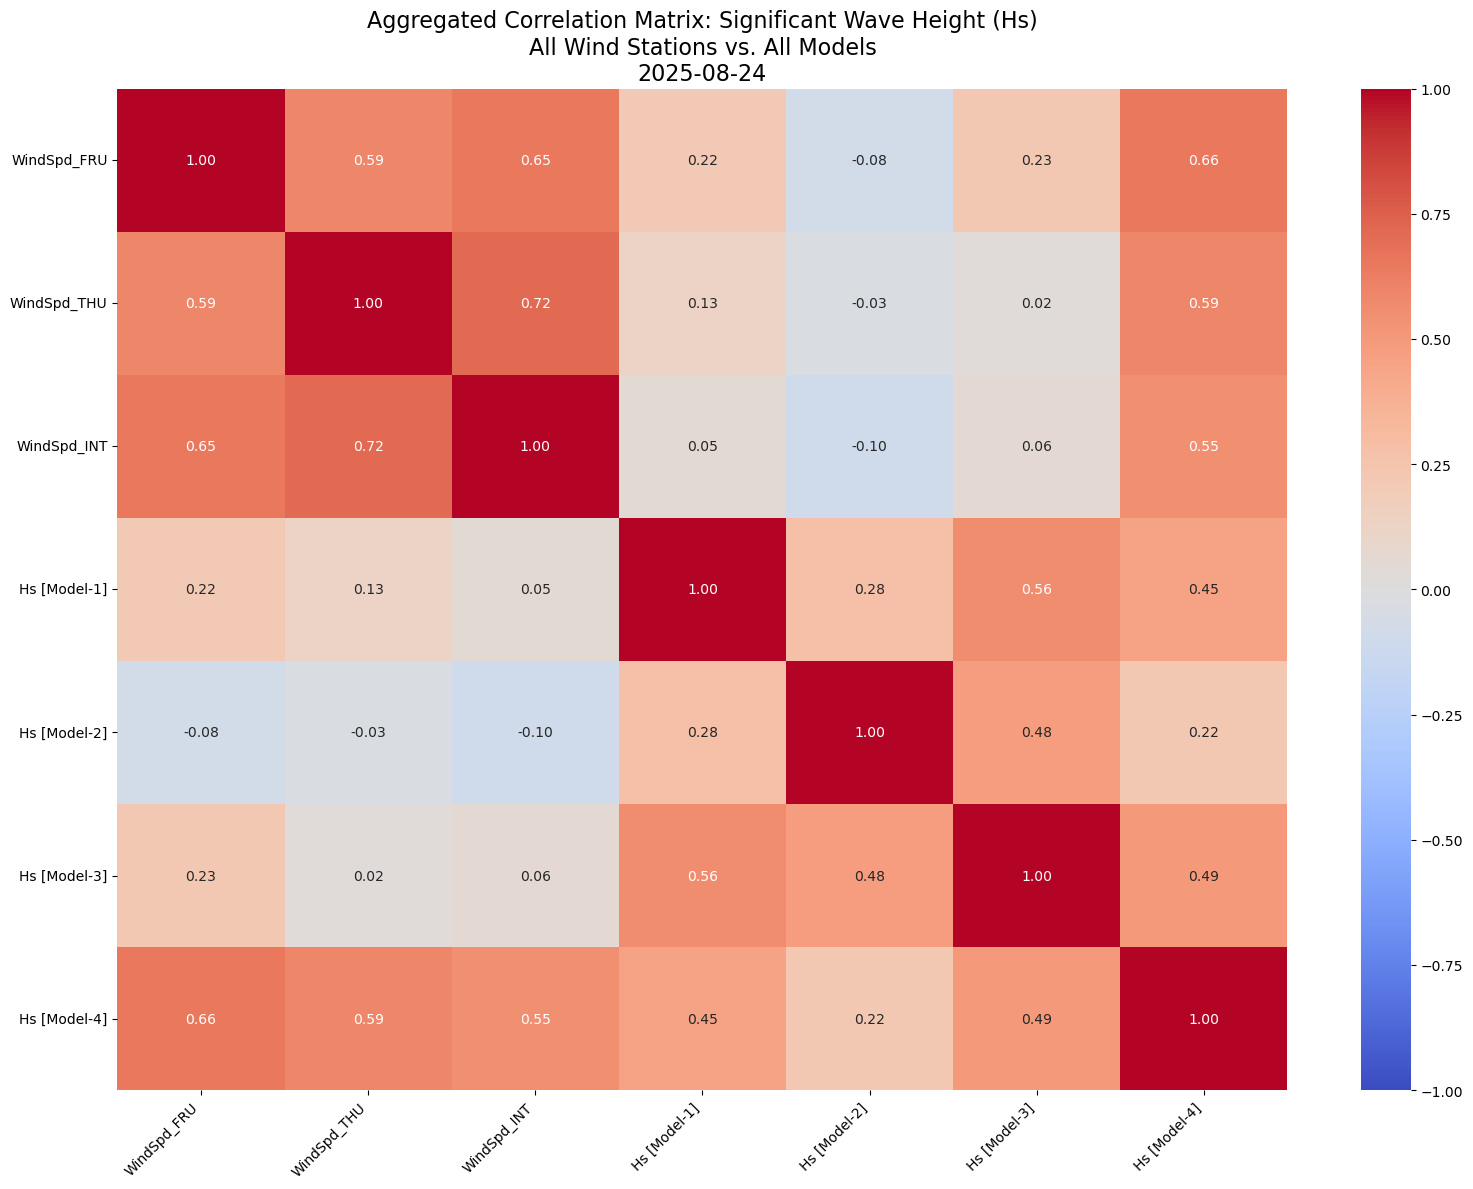

Saved Hmax matrix to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\2025-08-24_Hmax_CorrMatrix_AGGREGATED_AllModels.png


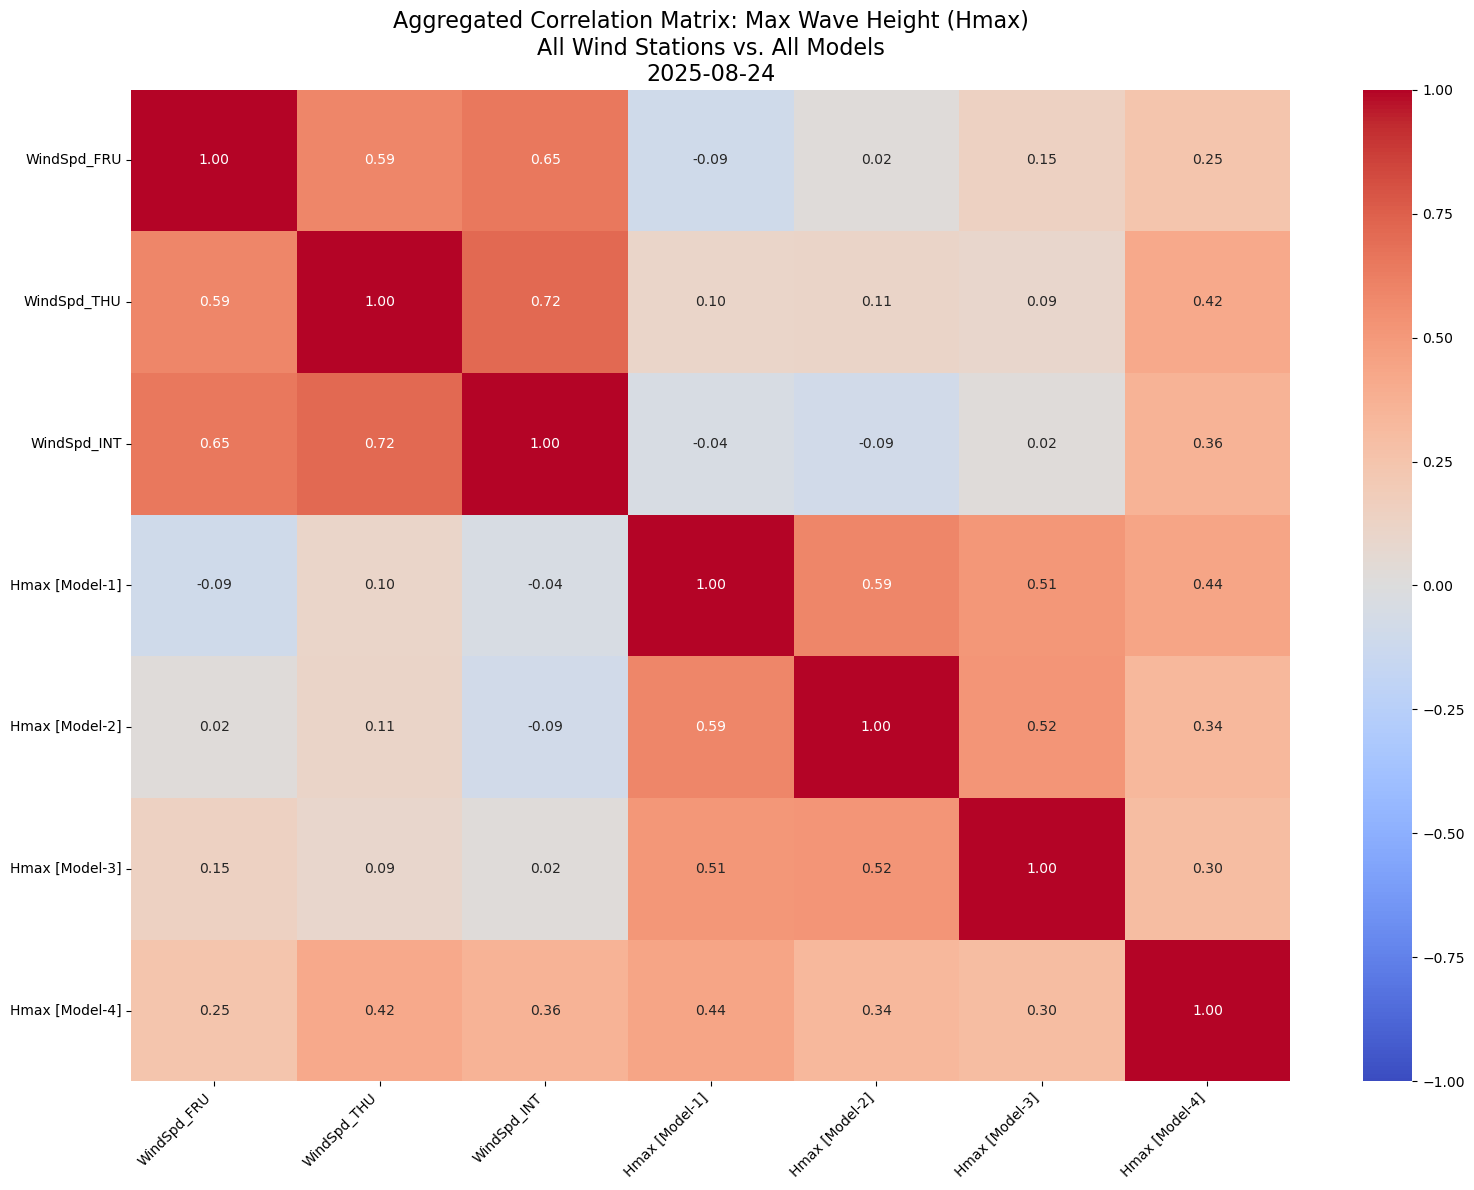

In [235]:
# --- Step 6: Create Aggregated Correlation Matrices (All Models + All Winds) ---
print("\nGenerating aggregated correlation matrices...")

# 1. Initialize the big dataframe with the wind data
big_df = wind_data.copy()

# 2. Iterate through all models and merge them into 'big_df'
for model_file in model_files:
    if not os.path.exists(model_file):
        continue
        
    # Determine Model Name from your map
    filename = os.path.basename(model_file)
    model_ref = filename
    for key, pretty_name in model_reference_map.items():
        if key in filename:
            model_ref = pretty_name 
            break
            
    # Load Data
    ds = mikeio.read(model_file)
    df_model = ds.to_dataframe()
    
    # Fix Index
    if df_model.index.tz is not None:
         df_model.index = df_model.index.tz_localize(None)
    
    # Rename columns to be unique for the big dataframe
    # We look for "Significant Wave Height" and "Max Wave Height"
    
    # 2a. Handle Hs
    hs_col = [c for c in df_model.columns if "Significant Wave Height" in c]
    if hs_col:
        big_df = pd.merge(big_df, df_model[hs_col].rename(columns={hs_col[0]: f"Hs [{model_ref}]"}),
                          left_index=True, right_index=True, how='inner')

    # 2b. Handle Hmax
    hmax_col = [c for c in df_model.columns if "Max Wave Height" in c]
    if hmax_col:
        big_df = pd.merge(big_df, df_model[hmax_col].rename(columns={hmax_col[0]: f"Hmax [{model_ref}]"}),
                          left_index=True, right_index=True, how='inner')

# --- Plot 1: Significant Wave Height (Hs) vs All Winds ---
cols_hs = [c for c in big_df.columns if "WindSpd" in c or "Hs [" in c]
corr_matrix_hs = big_df[cols_hs].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_hs, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Aggregated Correlation Matrix: Significant Wave Height (Hs)\nAll Wind Stations vs. All Models\n{DATE}", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

filename_hs = os.path.join(output_dir, f"{DATE}_Hs_CorrMatrix_AGGREGATED_AllModels.png")
plt.savefig(filename_hs)
print(f"Saved Hs matrix to {filename_hs}")
plt.show()

# --- Plot 2: Max Wave Height (Hmax) vs All Winds ---
cols_hmax = [c for c in big_df.columns if "WindSpd" in c or "Hmax [" in c]
corr_matrix_hmax = big_df[cols_hmax].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_hmax, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Aggregated Correlation Matrix: Max Wave Height (Hmax)\nAll Wind Stations vs. All Models\n{DATE}", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

filename_hmax = os.path.join(output_dir, f"{DATE}_Hmax_CorrMatrix_AGGREGATED_AllModels.png")
plt.savefig(filename_hmax)
print(f"Saved Hmax matrix to {filename_hmax}")
plt.show()

In [236]:
import scipy.stats as stats

# --- Step 8: Generate Scatter Plots with Regression Lines ---
print("\nGenerating scatter plots for physical consistency analysis...")

# Define output folder for scatter plots
scatter_dir = os.path.join(output_dir, "ScatterPlots")
os.makedirs(scatter_dir, exist_ok=True)

# Identify columns
wind_cols = [c for c in big_df.columns if "WindSpd" in c]
hs_cols = [c for c in big_df.columns if "Hs [" in c]

# Loop through every combination of Model vs. Wind Station
for model_col in hs_cols:
    for wind_col in wind_cols:
        
        # Clean data (drop NaNs for calculation)
        temp_df = big_df[[wind_col, model_col]].dropna()
        
        if len(temp_df) < 2:
            continue

        # Calculate Pearson Correlation (r) and p-value
        r, p_value = stats.pearsonr(temp_df[wind_col], temp_df[model_col])
        
        # Create Plot
        plt.figure(figsize=(10, 7))
        
        # Regression Plot: Scatter + Trend Line + Confidence Interval (shaded)
        sns.regplot(x=wind_col, y=model_col, data=temp_df, 
                    scatter_kws={'s': 15, 'alpha': 0.6}, # Small, semi-transparent dots
                    line_kws={'color': 'red', 'linewidth': 2}) # Distinct red trend line
        
        # Extract Clean Names for Title
        # model_col is like "Hs [Model-4]" -> "Model-4"
        model_name = model_col.split('[')[-1].replace(']', '')
        wind_name = wind_col # e.g., WindSpd_FRU
        
        # Formatting
        plt.title(f"Significant Wave Height vs {wind_name}\n{model_name}", fontsize=14)
        plt.xlabel(f"{wind_name} (m/s)", fontsize=12)
        plt.ylabel("Significant Wave Height (m)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # Add Correlation Text Box to the plot
        text_str = f'r = {r:.2f}\np = {p_value:.3f}'
        plt.gca().text(0.05, 0.95, text_str, transform=plt.gca().transAxes, 
                       fontsize=12, verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Save
        s_filename = f"{DATE}_Scatter_{model_name}_vs_{wind_name}.png"
        plt.savefig(os.path.join(scatter_dir, s_filename))
        plt.close()

print(f"Scatter plots saved to {scatter_dir}")


Generating scatter plots for physical consistency analysis...
Scatter plots saved to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\ScatterPlots



Generating Day vs Night correlation analysis...
Daytime samples: 70
Nighttime samples: 5
Saved Day/Night comparison grid to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\2025-08-09_CorrMatrix_Grid_DayNight_Hs_Hmax.png


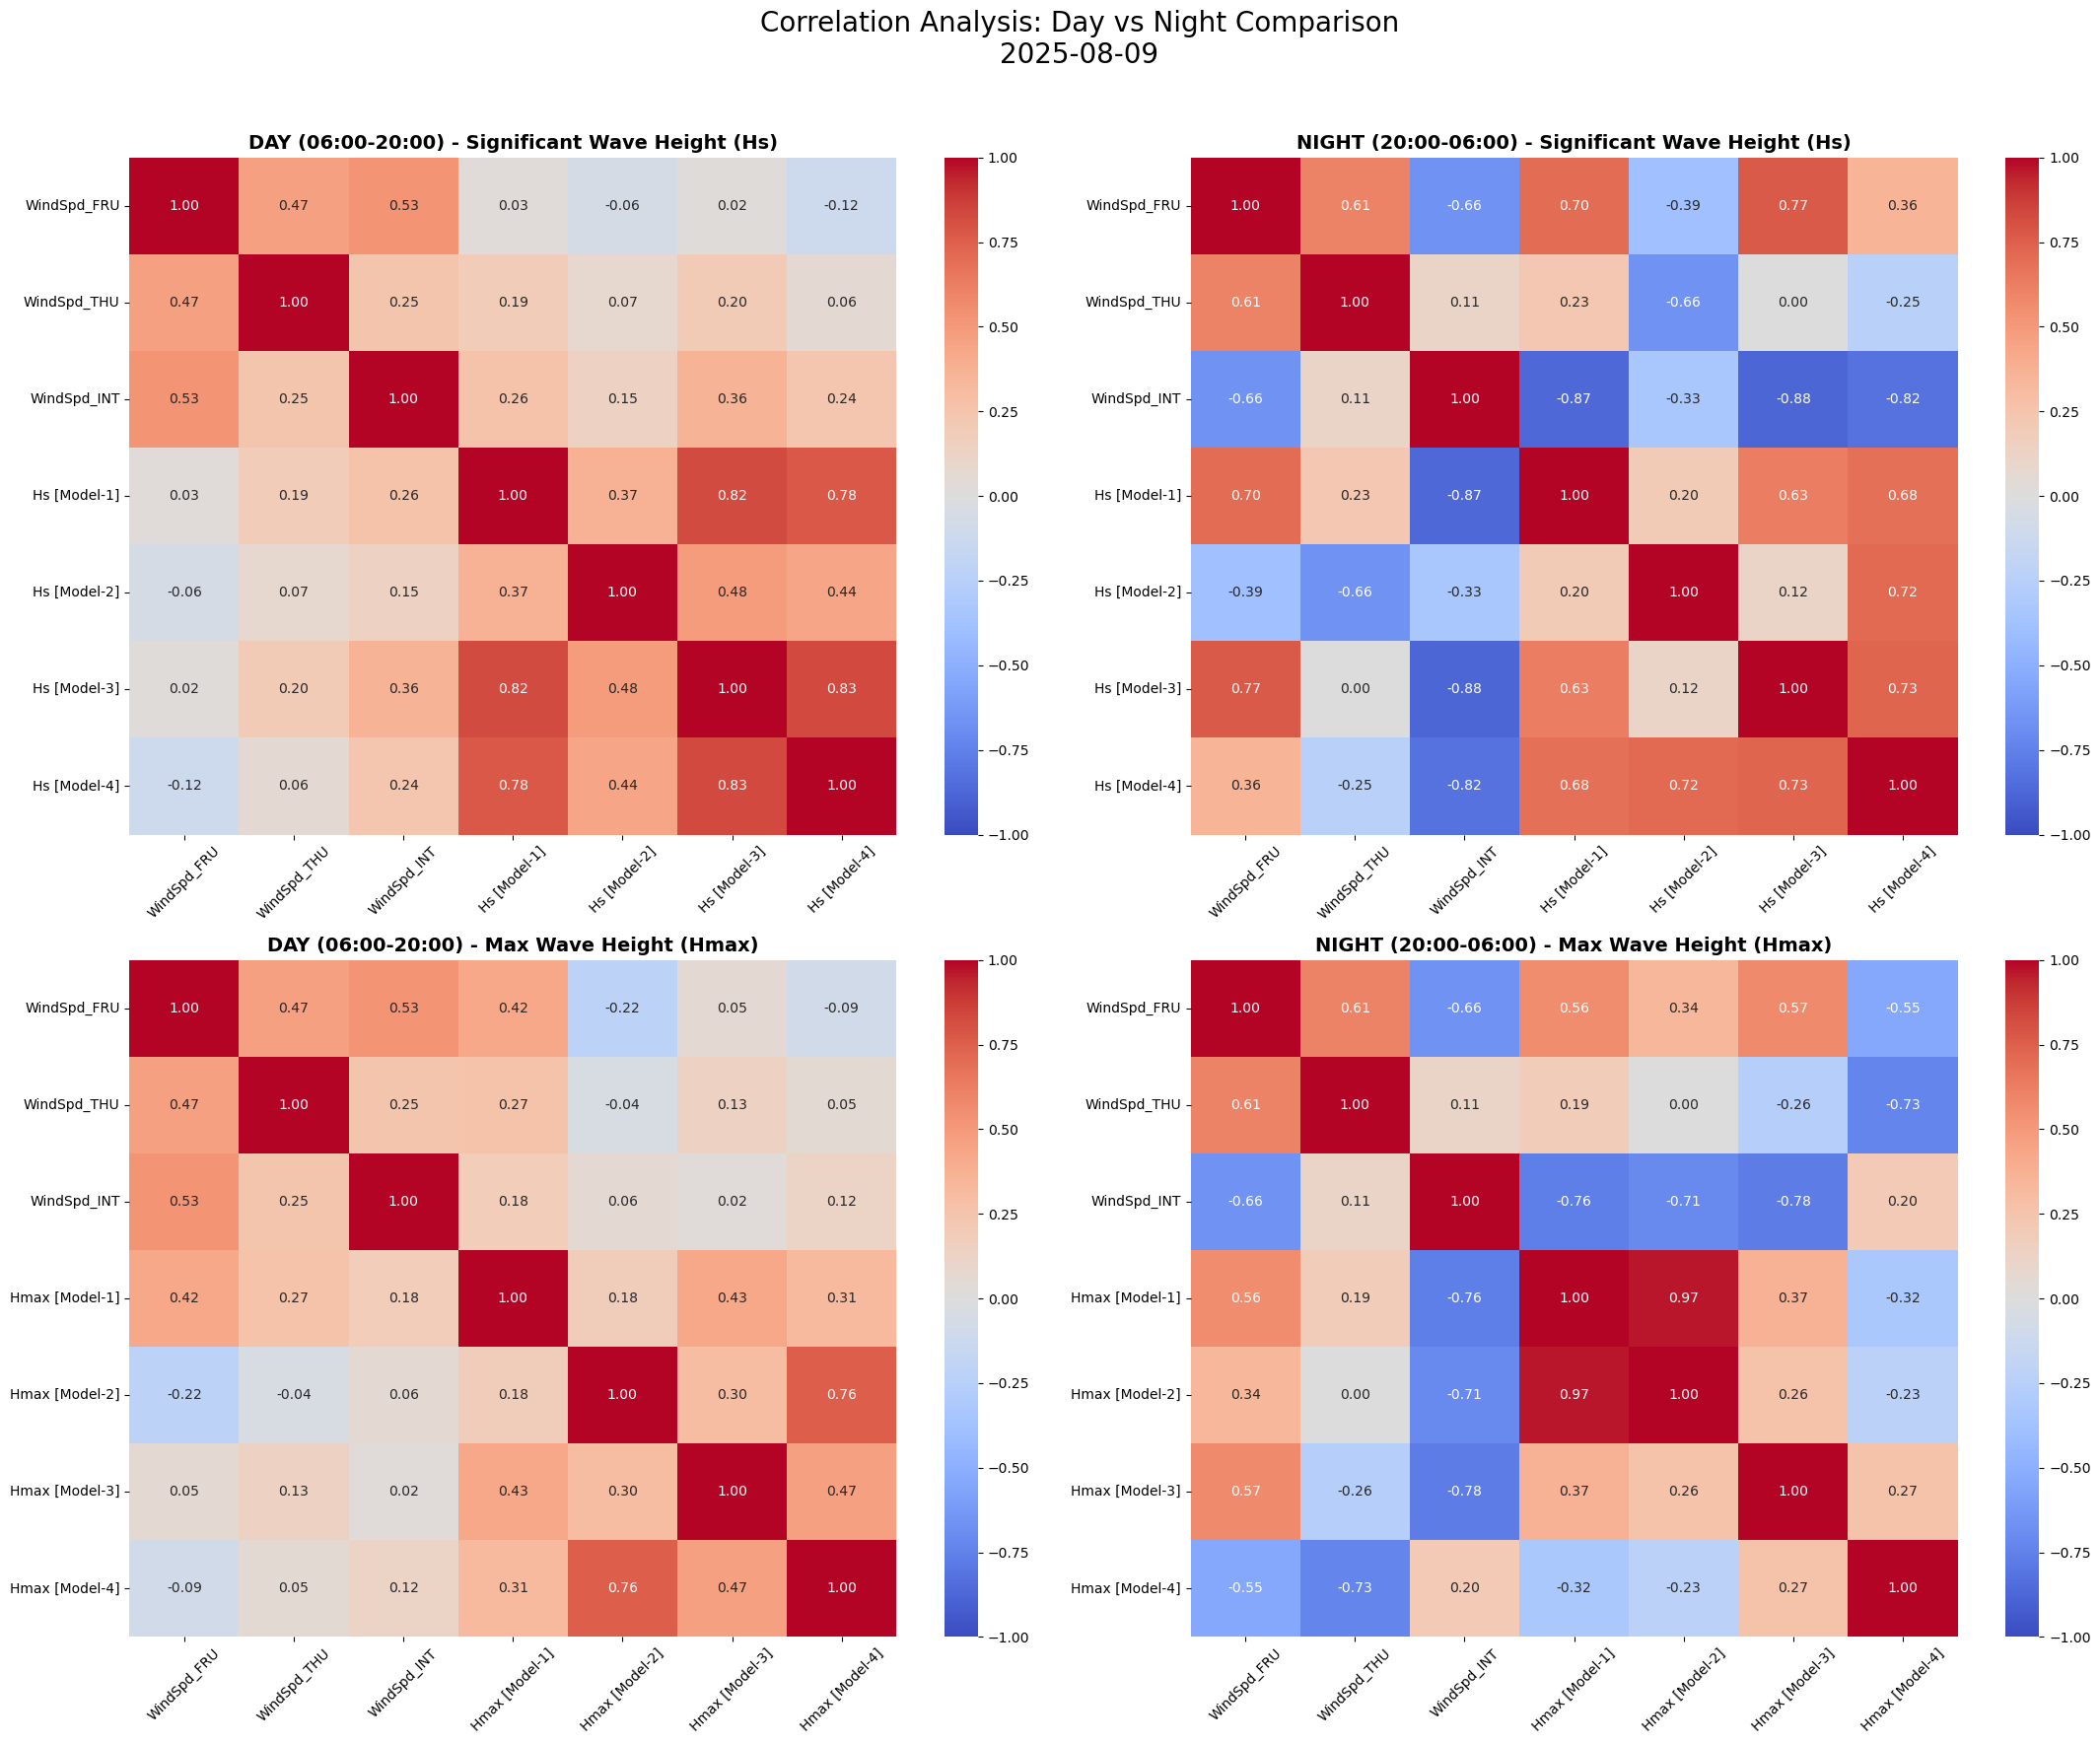

In [198]:

# --- Step 7: Day vs Night Correlation Analysis (4-Panel Plot) ---
print("\nGenerating Day vs Night correlation analysis...")

# 1. Define Time Filters
# Day: 06:00 to 19:59 (Hours 6 to 19 inclusive)
mask_day = (big_df.index.hour >= 6) & (big_df.index.hour <= 19)

# Night: 20:00 to 05:59 (Hours >= 20 OR <= 5)
mask_night = (big_df.index.hour >= 20) | (big_df.index.hour <= 5)

df_day = big_df[mask_day]
df_night = big_df[mask_night]

print(f"Daytime samples: {len(df_day)}")
print(f"Nighttime samples: {len(df_night)}")

# 2. Setup the 2x2 Plot Grid
fig, axes = plt.subplots(2, 2, figsize=(22, 18))

# Define helper to plot heatmap on specific axis
def plot_subset(data, column_filter, title, ax):
    # Select Wind columns and the specific Wave columns (Hs or Hmax)
    cols = [c for c in data.columns if "WindSpd" in c or column_filter in c]
    
    if len(data) > 0 and len(cols) > 1:
        corr = data[cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, ax=ax)
    else:
        ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center', fontsize=12)
        
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# --- Row 1: Significant Wave Height (Hs) ---
# Col 1: Day
plot_subset(df_day, "Hs [", "DAY (06:00-20:00) - Significant Wave Height (Hs)", axes[0, 0])
# Col 2: Night
plot_subset(df_night, "Hs [", "NIGHT (20:00-06:00) - Significant Wave Height (Hs)", axes[0, 1])

# --- Row 2: Max Wave Height (Hmax) ---
# Col 1: Day
plot_subset(df_day, "Hmax [", "DAY (06:00-20:00) - Max Wave Height (Hmax)", axes[1, 0])
# Col 2: Night
plot_subset(df_night, "Hmax [", "NIGHT (20:00-06:00) - Max Wave Height (Hmax)", axes[1, 1])

plt.suptitle(f"Correlation Analysis: Day vs Night Comparison\n{DATE}", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle

# Save
filename_daynight = os.path.join(output_dir, f"{DATE}_CorrMatrix_Grid_DayNight_Hs_Hmax.png")
plt.savefig(filename_daynight)
print(f"Saved Day/Night comparison grid to {filename_daynight}")
plt.show()


Generating aggregated correlation matrices...
Saved Hs matrix to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\2025-10-23_Hs_CorrMatrix_AGGREGATED_AllModels_WindDir.png


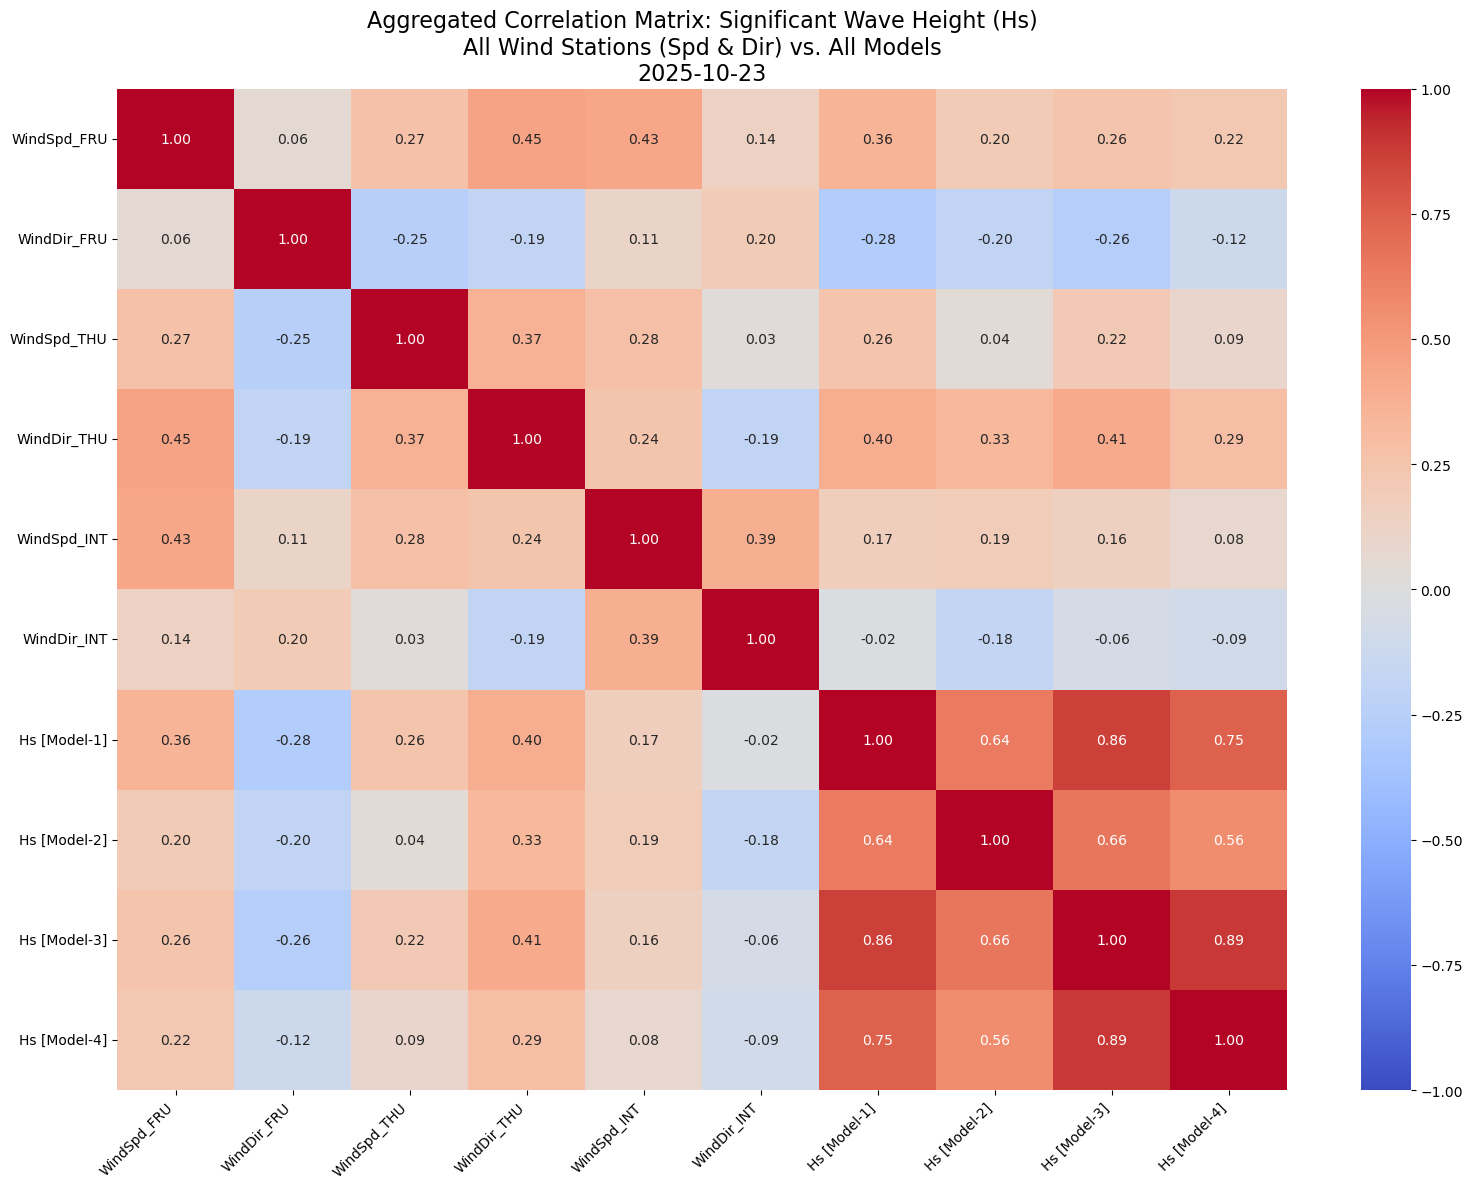

Saved Hmax matrix to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\2025-10-23_Hmax_CorrMatrix_AGGREGATED_AllModels_WindDir.png


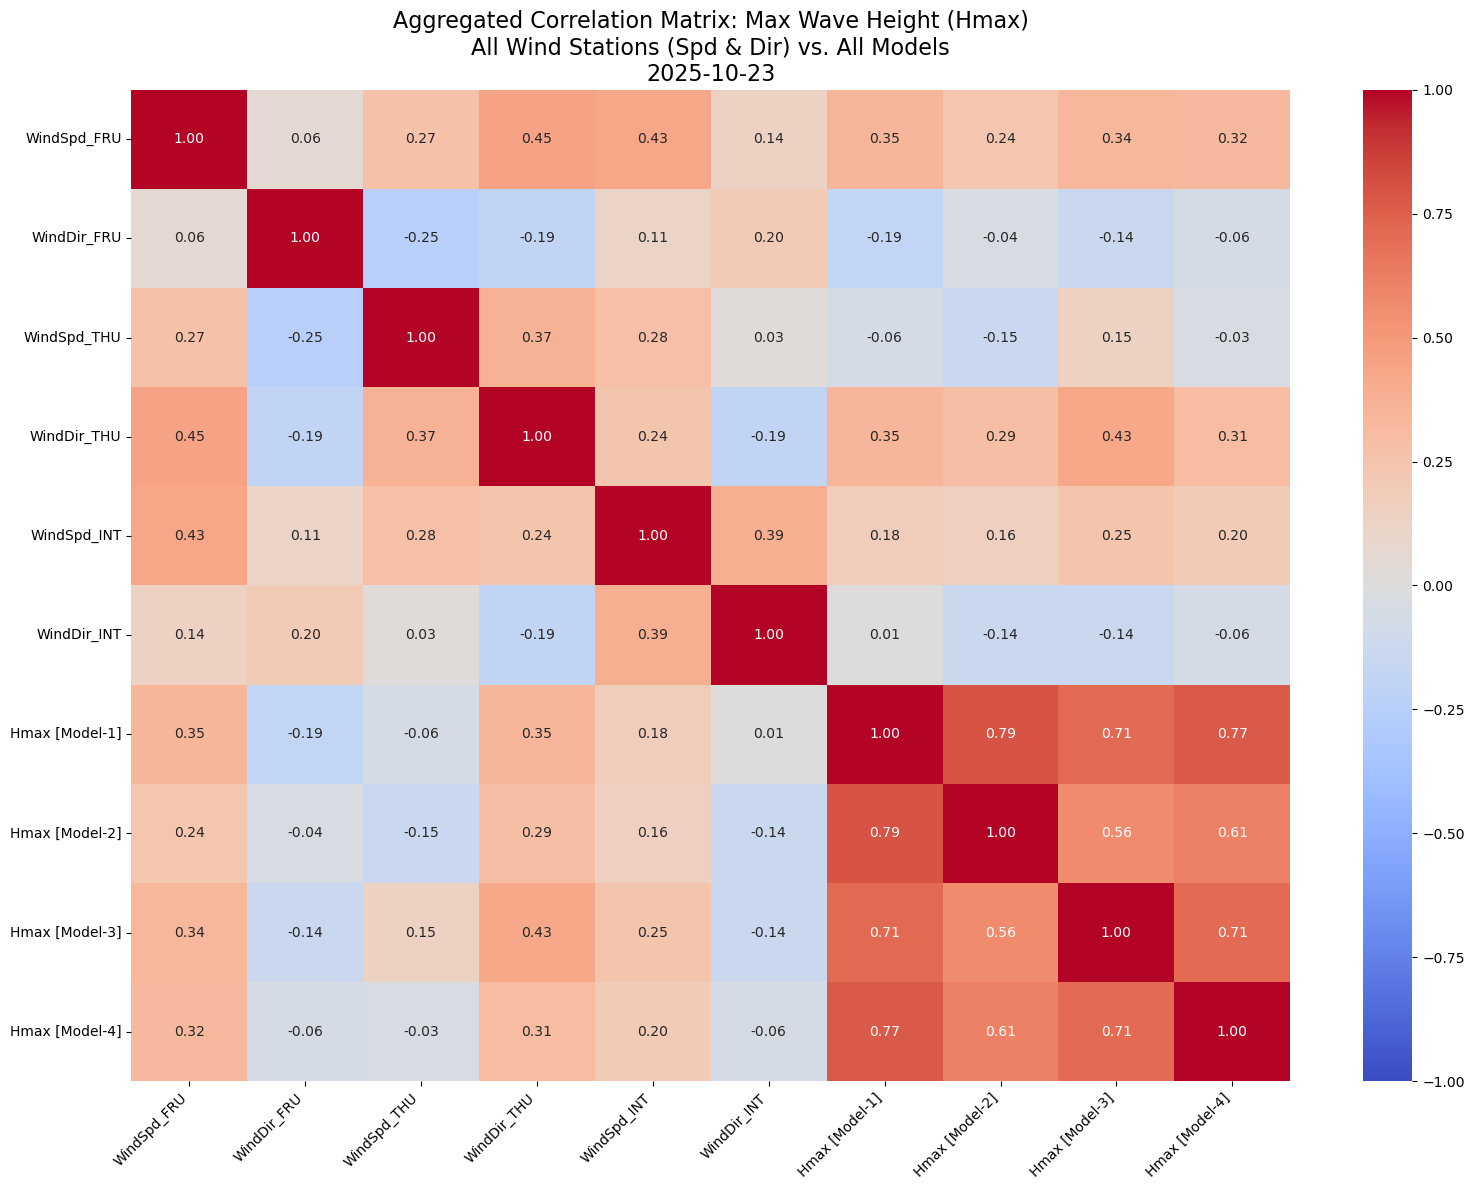

In [211]:
# --- Step 8: Create Aggregated Correlation Matrices (All Models + All Winds + Directions) ---
print("\nGenerating aggregated correlation matrices...")

# 1. Initialize the big dataframe with the wind data
big_df = wind_data.copy()

# 2. Iterate through all models and merge them into 'big_df'
for model_file in model_files:
    if not os.path.exists(model_file):
        continue
        
    # Determine Model Name from your map
    filename = os.path.basename(model_file)
    model_ref = filename
    for key, pretty_name in model_reference_map.items():
        if key in filename:
            model_ref = pretty_name 
            break
            
    # Load Data
    ds = mikeio.read(model_file)
    df_model = ds.to_dataframe()
    
    # Fix Index
    if df_model.index.tz is not None:
         df_model.index = df_model.index.tz_localize(None)
    
    # Rename columns to be unique for the big dataframe
    # We look for "Significant Wave Height" and "Max Wave Height"
    
    # 2a. Handle Hs
    hs_col = [c for c in df_model.columns if "Significant Wave Height" in c]
    if hs_col:
        big_df = pd.merge(big_df, df_model[hs_col].rename(columns={hs_col[0]: f"Hs [{model_ref}]"}),
                          left_index=True, right_index=True, how='inner')

    # 2b. Handle Hmax
    hmax_col = [c for c in df_model.columns if "Max Wave Height" in c]
    if hmax_col:
        big_df = pd.merge(big_df, df_model[hmax_col].rename(columns={hmax_col[0]: f"Hmax [{model_ref}]"}),
                          left_index=True, right_index=True, how='inner')

# --- Plot 1: Significant Wave Height (Hs) vs All Winds (Speed & Dir) ---
# UPDATED LINE BELOW: Added 'or "WindDir" in c'
cols_hs = [c for c in big_df.columns if "WindSpd" in c or "WindDir" in c or "Hs [" in c]
corr_matrix_hs = big_df[cols_hs].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_hs, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Aggregated Correlation Matrix: Significant Wave Height (Hs)\nAll Wind Stations (Spd & Dir) vs. All Models\n{DATE}", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

filename_hs = os.path.join(output_dir, f"{DATE}_Hs_CorrMatrix_AGGREGATED_AllModels_WindDir.png")
plt.savefig(filename_hs)
print(f"Saved Hs matrix to {filename_hs}")
plt.show()

# --- Plot 2: Max Wave Height (Hmax) vs All Winds (Speed & Dir) ---
# UPDATED LINE BELOW: Added 'or "WindDir" in c'
cols_hmax = [c for c in big_df.columns if "WindSpd" in c or "WindDir" in c or "Hmax [" in c]
corr_matrix_hmax = big_df[cols_hmax].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_hmax, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Aggregated Correlation Matrix: Max Wave Height (Hmax)\nAll Wind Stations (Spd & Dir) vs. All Models\n{DATE}", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

filename_hmax = os.path.join(output_dir, f"{DATE}_Hmax_CorrMatrix_AGGREGATED_AllModels_WindDir.png")
plt.savefig(filename_hmax)
print(f"Saved Hmax matrix to {filename_hmax}")
plt.show()


Generating Day vs Night correlation analysis...
Daytime samples: 49
Nighttime samples: 3
Saved Day/Night comparison grid to C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\correlation_plots\2025-10-23_CorrMatrix_Grid_DayNight_Hs_Hmax_WindDir.png


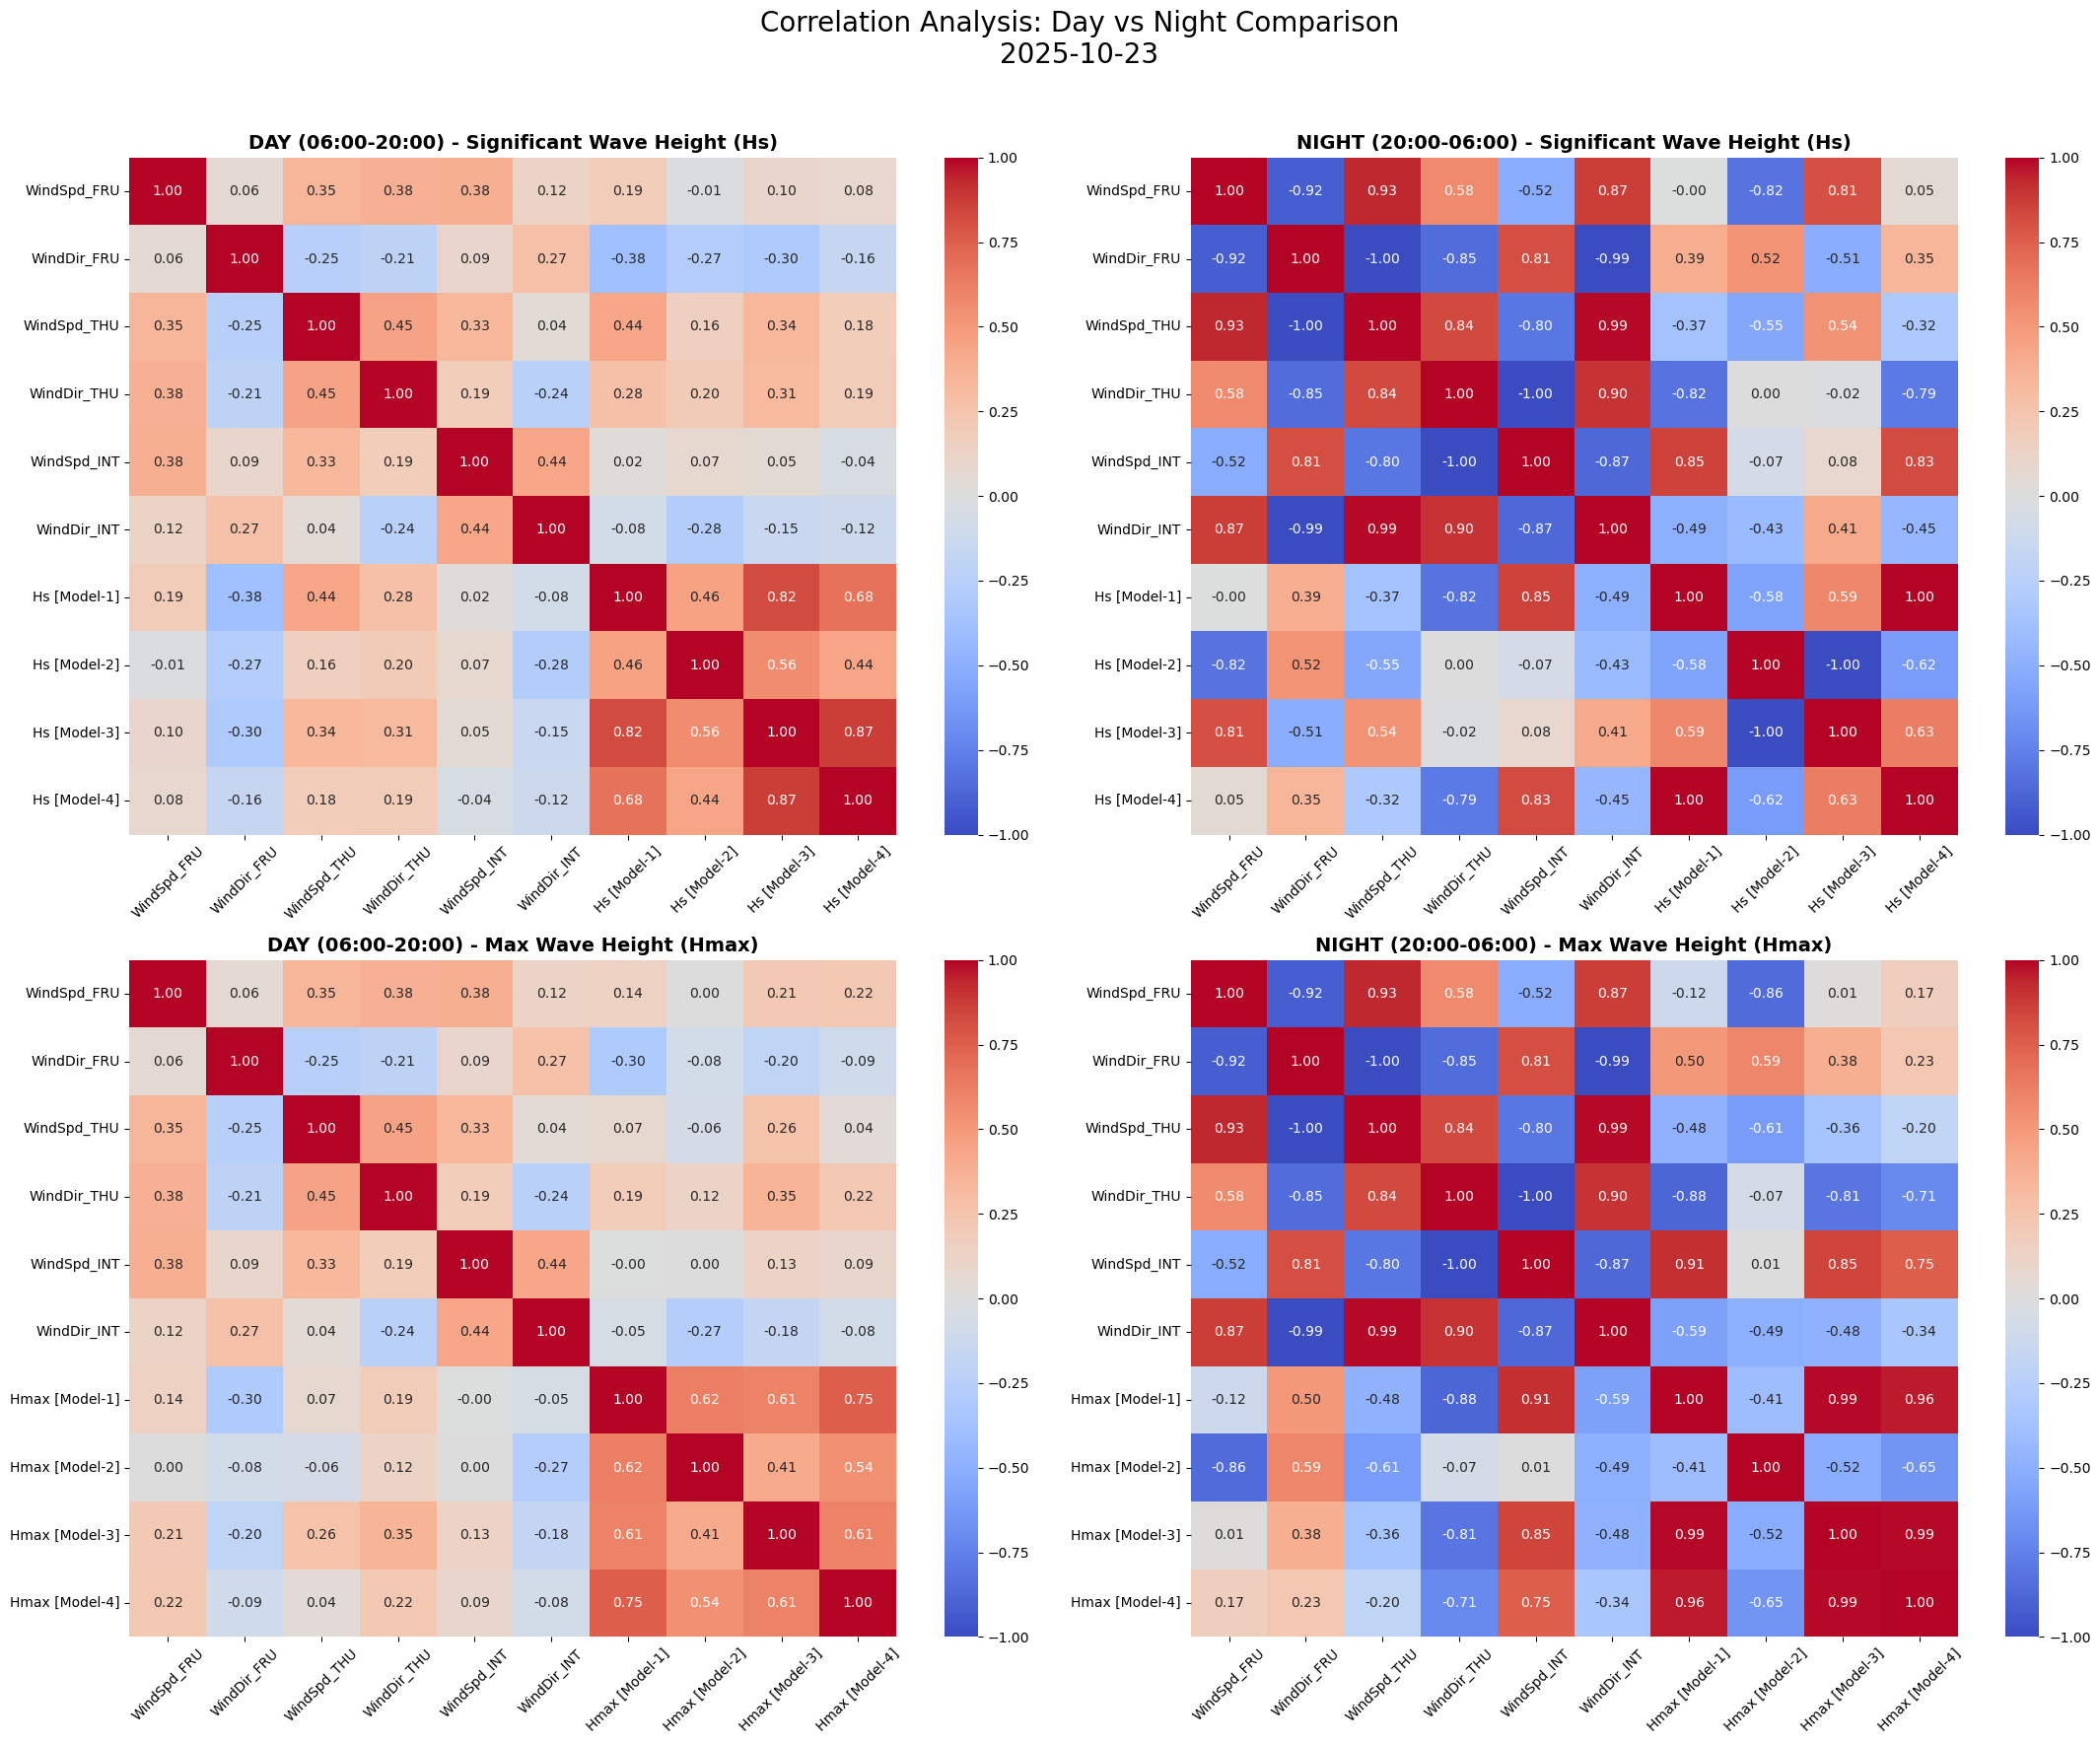

In [212]:
# --- Step 9: Day vs Night Correlation Analysis (4-Panel Plot) ---
print("\nGenerating Day vs Night correlation analysis...")

# 1. Define Time Filters
# Day: 06:00 to 19:59 (Hours 6 to 19 inclusive)
mask_day = (big_df.index.hour >= 6) & (big_df.index.hour <= 19)

# Night: 20:00 to 05:59 (Hours >= 20 OR <= 5)
mask_night = (big_df.index.hour >= 20) | (big_df.index.hour <= 5)

df_day = big_df[mask_day]
df_night = big_df[mask_night]

print(f"Daytime samples: {len(df_day)}")
print(f"Nighttime samples: {len(df_night)}")

# 2. Setup the 2x2 Plot Grid
fig, axes = plt.subplots(2, 2, figsize=(22, 18))

# Define helper to plot heatmap on specific axis
def plot_subset(data, column_filter, title, ax):
    # Select Wind Speed, Wind Direction, and the specific Wave columns (Hs or Hmax)
    # UPDATED LINE BELOW: Added 'or "WindDir" in c'
    cols = [c for c in data.columns if "WindSpd" in c or "WindDir" in c or column_filter in c]
    
    if len(data) > 0 and len(cols) > 1:
        corr = data[cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, ax=ax)
    else:
        ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center', fontsize=12)
        
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# --- Row 1: Significant Wave Height (Hs) ---
# Col 1: Day
plot_subset(df_day, "Hs [", "DAY (06:00-20:00) - Significant Wave Height (Hs)", axes[0, 0])
# Col 2: Night
plot_subset(df_night, "Hs [", "NIGHT (20:00-06:00) - Significant Wave Height (Hs)", axes[0, 1])

# --- Row 2: Max Wave Height (Hmax) ---
# Col 1: Day
plot_subset(df_day, "Hmax [", "DAY (06:00-20:00) - Max Wave Height (Hmax)", axes[1, 0])
# Col 2: Night
plot_subset(df_night, "Hmax [", "NIGHT (20:00-06:00) - Max Wave Height (Hmax)", axes[1, 1])

plt.suptitle(f"Correlation Analysis: Day vs Night Comparison\n{DATE}", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle

# Save
filename_daynight = os.path.join(output_dir, f"{DATE}_CorrMatrix_Grid_DayNight_Hs_Hmax_WindDir.png")
plt.savefig(filename_daynight)
print(f"Saved Day/Night comparison grid to {filename_daynight}")
plt.show()

# Compariosn of MIKE SD and UV Files

In [44]:
import mikeio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


def analyze_physical_consistency(dfs0_path, wind_item_name=None, wave_item_name="Sign. Wave Height"):
    """
    Reads a MIKE 21 SW point output file and calculates the correlation 
    between Wind Speed and Significant Wave Height.
    """
    print(f"--- Analyzing: {dfs0_path} ---")
    
    # 1. Read the DFS0 file
    ds = mikeio.read(dfs0_path)
    df = ds.to_dataframe()
    
    # Print available items to help you check names
    print("Available items in file:", df.columns.tolist())
    
    # 2. Identify Wave Height Column
    # MIKE 21 SW usually names it 'Sign. Wave Height' or similar. 
    # We try to find it automatically if the exact name isn't found.
    hs_col = None
    for col in df.columns:
        if "Sign. Wave Height" in col or "Hs" in col:
            hs_col = col
            break
            
    if hs_col is None:
        print("Error: Could not find 'Sign. Wave Height' in file.")
        return
    
    # 3. Identify Wind Speed Column
    # If Wind Speed was saved in the output file (Item: Wind speed), use it.
    # Otherwise, you might need to load your wind forcing file separately.
    wind_col = None
    if wind_item_name:
        wind_col = wind_item_name
    else:
        for col in df.columns:
            if "Wind speed" in col or "Wind Speed" in col:
                wind_col = col
                break
    
    if wind_col is None:
        print("Warning: 'Wind speed' not found in this file.")
        print("You cannot calculate correlation without wind speed.")
        print("Tip: Re-run MIKE and tick 'Wind speed' in the Point Output dialog,")
        print("     or merge this dataframe with your external wind data.")
        return

    # 4. Clean Data (Remove NaNs or spin-up zeros if necessary)
    # We filter out very low wind speeds (< 1 m/s) to focus on the active wave generation regime
    data = df[[wind_col, hs_col]].dropna()
    data = data[data[wind_col] > 1.0] 

    # 5. Calculate Correlation
    # We verify the relationship: H_s ~ Wind_Speed^n (Power law)
    # But a simple linear correlation (Pearson) is robust enough for this check.
    r_val, p_val = pearsonr(data[wind_col], data[hs_col])
    # Correlation with wind speed squared (proxy for wind stress)
    r2_val, p2_val = pearsonr(data[wind_col]**2, data[hs_col])
    print(f"Correlation with wind²: {r2_val:.3f}")
    
    print(f"\nRESULTS for {dfs0_path}:")
    print(f"Correlation (r): {r_val:.4f}")
    print(f"P-value:         {p_val:.4e}")
    
    # Interpretation Logic
    if r_val > 0.85:
        print(">> VERDICT: PHYSICALLY CONSISTENT. Model responds correctly to wind.")
    elif r_val < 0.5:
        print(">> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of fetch.")
    else:
        print(">> VERDICT: WEAK / NOISY. Check time-steps or grid resolution.")

    # 6. Plotting
    plt.figure(figsize=(10, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(data[wind_col], data[hs_col], alpha=0.5, c='blue')
    plt.title(f"Wind vs Wave Height\n(r = {r_val:.2f})")
    plt.xlabel("Wind Speed [m/s]")
    plt.ylabel("Sign. Wave Height [m]")
    plt.grid(True)
    
    # Time series comparison (Normalized)
    plt.subplot(1, 2, 2)
    # Normalize to 0-1 for visual comparison of shape
    norm_wind = (data[wind_col] - data[wind_col].min()) / (data[wind_col].max() - data[wind_col].min())
    norm_wave = (data[hs_col] - data[hs_col].min()) / (data[hs_col].max() - data[hs_col].min())
    
    plt.plot(data.index, norm_wind, label='Norm. Wind', color='grey', alpha=0.6)
    plt.plot(data.index, norm_wave, label='Norm. Hs', color='blue')
    plt.title("Time-Series Shape Comparison")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\15_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\15_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0:
Correlation (r): 0.3987
P-value:         1.3397e-05
>> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of fetch.


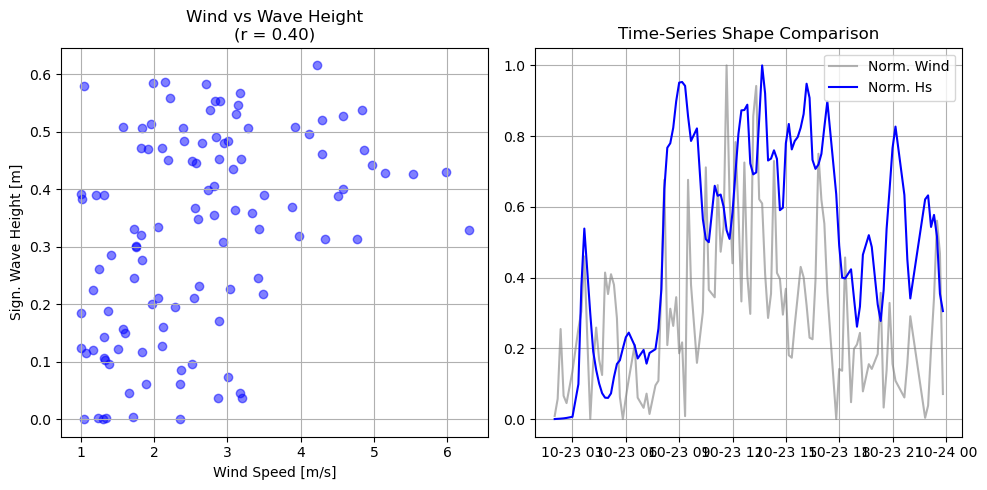

In [37]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"15_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)


# Run the check
analyze_physical_consistency(dfs0_path)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0:
Correlation (r): 0.5538
P-value:         2.4024e-10
>> VERDICT: WEAK / NOISY. Check time-steps or grid resolution.


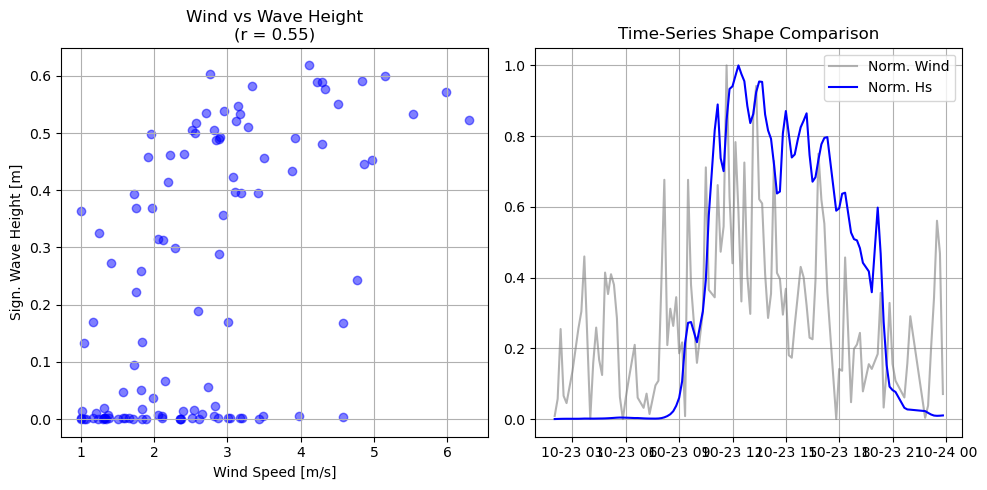

In [38]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)


# Run the check
analyze_physical_consistency(dfs0_path)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0:
Correlation (r): 0.2542
P-value:         5.2745e-03
>> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of fetch.


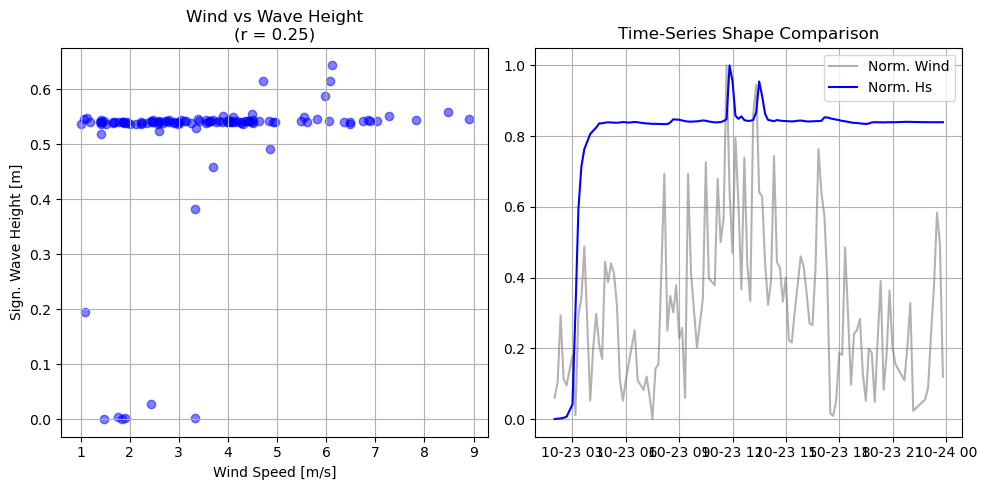

In [285]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)


# Run the check
analyze_physical_consistency(dfs0_path)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0:
Correlation (r): 0.3770
P-value:         2.3759e-05
>> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of fetch.


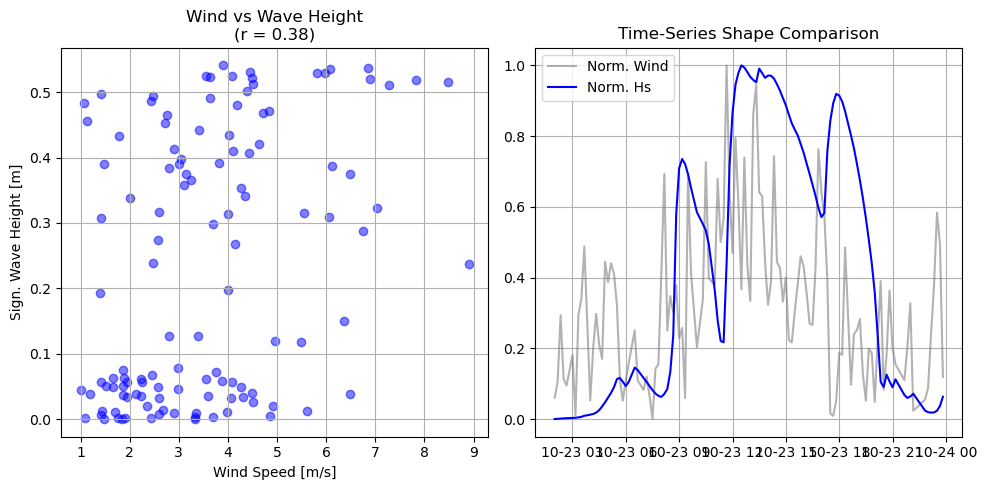

In [286]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)


# Run the check
analyze_physical_consistency(dfs0_path)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0:
Correlation (r): 0.4117
P-value:         3.2961e-06
>> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of fetch.


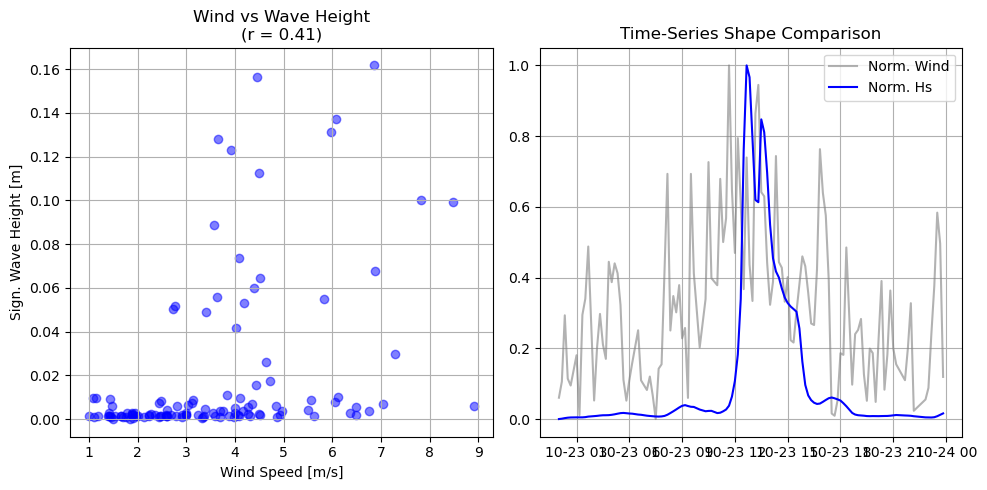

In [288]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)


# Run the check
analyze_physical_consistency(dfs0_path)

In [ ]:
# USER INPUT — LIST ALL DFS0 FILES YOU WANT TO COMPARE
# ---------------------------------------------------------

# 2025-10-23
#time_start = pd.Timestamp("2025-10-23 02:00")
#time_end   = pd.Timestamp("2025-10-23 23:50")

#files = [
#    r"11_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.05Hz.dfs0",  # Run A
#    r"13_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
#    r"12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",  # Run C
#    r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
#    r"14_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",  # Run E
#    r"15_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0",   # Run F
#]

# 2025-08-09
#time_start = pd.Timestamp("2025-08-09 02:00")
#time_end   = pd.Timestamp("2025-08-09 23:50")

#files = [
#    r"21_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run A
#    r"21_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
#    r"16_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",  # Run C
#    r"17_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
#    r"22_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
#    r"23_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0",   # Run F
#]

# 2025-08-24
time_start = pd.Timestamp("2025-08-24 02:00")
time_end   = pd.Timestamp("2025-08-24 23:50")

files = [
    r"24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run A
    r"24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
    r"25_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",   # Run C
    r"26_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
    r"27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
    r"28_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.3Hz.dfs0",   # Run DF
]

In [ ]:
# USER INPUT — LIST ALL DFS0 FILES YOU WANT TO COMPARE
# ---------------------------------------------------------

# 2025-10-23
#time_start = pd.Timestamp("2025-10-23 02:00")
#time_end   = pd.Timestamp("2025-10-23 23:50")

#files = [
#    r"10_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.05Hz.dfs0",  # Run A
#    r"08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",   # Run B
#    r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",  # Run C
#    r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",   # Run D
#    r"30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",   # Run E
#]

# 2025-08-09
#time_start = pd.Timestamp("2025-08-09 02:00")
#time_end   = pd.Timestamp("2025-08-09 23:50")

#files = [
#    r"20_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",      # Run A
#    r"20_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",      # Run B
#    r"19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",     # Run C
#    r"18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",      # Run D
#    r"29_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0"      # Run E
#]

# 2025-08-24
time_start = pd.Timestamp("2025-08-24 02:00")
time_end   = pd.Timestamp("2025-08-24 23:50")

files = [
   source_folder_mike21sw  # Run E
]


In [39]:
# 2025-10-23: 0.2Hz
name_dfs0_A = r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0"  # speed & direction
name_dfs0_B = r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0"  # U-V components

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0:
Correlation (r): 0.2642
P-value:         3.6897e-03
>> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of fetch.


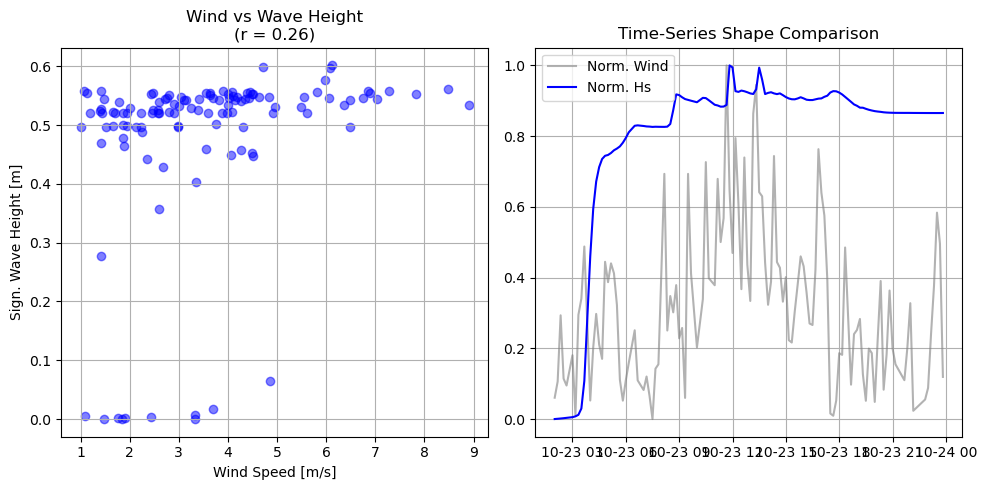

In [40]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)

# Run the check
analyze_physical_consistency(dfs0_path)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']
Correlation with wind²: 0.377

RESULTS for C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0:
Correlation (r): 0.3939
P-value:         1.7358e-05
>> VERDICT: INCONSISTENT. Low correlation implies coordinate error or lack of 

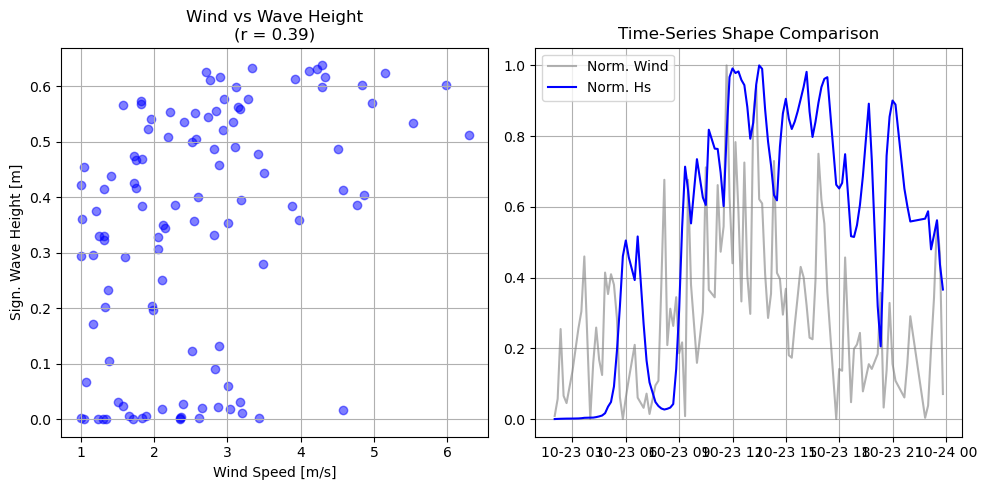

In [47]:
# USER INPUT
# -------------------------------------------------------------------
name_dfs0_flie = r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0"

dfs0_path =os.path.join(source_folder_mike21sw, name_dfs0_flie)

# Run the check
data=analyze_physical_consistency(dfs0_path)

# Minimum Forcing Treshold Min and max SMB-based wave Height tresholds

In [590]:
import numpy as np

# =========================================================
# 1) SMB (deep-water) helper functions
# =========================================================

def smb_uA(U10):
    """
    SMB wind-stress factor UA as used in your earlier function.
    U10 in m/s.
    """
    return 0.71 * (U10 ** 1.23)

def smb_hs_deepwater(U10, fetch_m):
    """
    SMB deep-water significant wave height (Hs) estimate.
    U10: wind speed at 10 m [m/s]
    fetch_m: fetch length [m]
    Returns Hs [m]
    """
    UA = smb_uA(U10)
    Hs = 5.112e-4 * UA * np.sqrt(fetch_m)
    return Hs

def invert_smb_for_U10(Hs_target, fetch_m, U_lo=0.0, U_hi=40.0, tol=1e-6, max_iter=200):
    """
    Solve for U10 such that SMB Hs(U10, fetch) = Hs_target.
    Uses a robust bisection method (no SciPy required).
    """
    if Hs_target <= 0:
        return 0.0

    def f(U):
        return smb_hs_deepwater(U, fetch_m) - Hs_target

    # Ensure bracket
    flo = f(U_lo)
    fhi = f(U_hi)
    if flo > 0:
        return U_lo  # already above target at lower bound
    if fhi < 0:
        raise ValueError(
            f"Target Hs={Hs_target} m cannot be reached within U_hi={U_hi} m/s. "
            "Increase U_hi."
        )

    lo, hi = U_lo, U_hi
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if abs(fmid) < tol:
            return mid
        if fmid > 0:
            hi = mid
        else:
            lo = mid
    return 0.5 * (lo + hi)









In [591]:

# =========================================================
# 2) Lake Thun: set fetch scenarios (edit these!)
# =========================================================
# These are typical “scenario” fetches. Replace with your own GIS / effective fetch analysis if available.
FETCH_LONG_M   = 18000  # ~18 km (geometric max / upper bound)
FETCH_NARROW_M =  9000  # ~9 km (effective/narrow fetch used earlier)

# Optional: even more sheltered case (if you want)
FETCH_SHELTERED_M = 6000  # ~6 km

In [592]:
# =========================================================
# 3) Minimum forcing threshold (U_min) using SMB
# =========================================================
# Define the minimum “measurable / meaningful” wave height for your application:
HS_MIN_MEANINGFUL = 0.05  # 5 cm (common practical threshold; adjust if needed)

Umin_long   = invert_smb_for_U10(HS_MIN_MEANINGFUL, FETCH_LONG_M)
Umin_narrow = invert_smb_for_U10(HS_MIN_MEANINGFUL, FETCH_NARROW_M)
Umin_shel   = invert_smb_for_U10(HS_MIN_MEANINGFUL, FETCH_SHELTERED_M)

print("=== Minimum forcing threshold from SMB ===")
print(f"Hs_min meaningful: {HS_MIN_MEANINGFUL:.2f} m")
print(f"U_min (long fetch  {FETCH_LONG_M/1000:.1f} km): {Umin_long:.2f} m/s")
print(f"U_min (narrow      {FETCH_NARROW_M/1000:.1f} km): {Umin_narrow:.2f} m/s")
print(f"U_min (sheltered   {FETCH_SHELTERED_M/1000:.1f} km): {Umin_shel:.2f} m/s")

=== Minimum forcing threshold from SMB ===
Hs_min meaningful: 0.05 m
U_min (long fetch  18.0 km): 1.02 m/s
U_min (narrow      9.0 km): 1.35 m/s
U_min (sheltered   6.0 km): 1.60 m/s


In [593]:
# =========================================================
# 4) SMB-based min/max wave-height thresholds (to detect under/over-estimation)
# =========================================================
# Choose plausible wind speeds to bound expected events. Edit to match your meteo time series.
# Example:
U_CALM_MAX      = 5.0    # m/s
U_MODERATE_MAX  = 12.0   # m/s
U_STORM_MAX     = 20.0   # m/s (or higher if you have stronger winds)

def smb_thresholds_for_fetch(fetch_m, U_calm=U_CALM_MAX, U_mod=U_MODERATE_MAX, U_storm=U_STORM_MAX):
    """
    Returns SMB Hs thresholds for a given fetch:
      - Hs at calm/moderate/storm wind bounds
      - You can interpret these as plausible upper envelopes for those regimes
    """
    return {
        "Hs_calm_max": smb_hs_deepwater(U_calm, fetch_m),
        "Hs_mod_max":  smb_hs_deepwater(U_mod, fetch_m),
        "Hs_storm_max": smb_hs_deepwater(U_storm, fetch_m),
    }

thr_long   = smb_thresholds_for_fetch(FETCH_LONG_M)
thr_narrow = smb_thresholds_for_fetch(FETCH_NARROW_M)
thr_shel   = smb_thresholds_for_fetch(FETCH_SHELTERED_M)

print("\n=== SMB Hs upper-envelope thresholds (by fetch scenario) ===")
print(f"Wind bounds used: calm<= {U_CALM_MAX} m/s, moderate<= {U_MODERATE_MAX} m/s, storm<= {U_STORM_MAX} m/s")

for name, fetch_m, thr in [
    ("LONG", FETCH_LONG_M, thr_long),
    ("NARROW", FETCH_NARROW_M, thr_narrow),
    ("SHELTERED", FETCH_SHELTERED_M, thr_shel),
]:
    print(f"\n{name} fetch = {fetch_m/1000:.1f} km")
    for k, v in thr.items():
        print(f"  {k}: {v:.3f} m")


=== SMB Hs upper-envelope thresholds (by fetch scenario) ===
Wind bounds used: calm<= 5.0 m/s, moderate<= 12.0 m/s, storm<= 20.0 m/s

LONG fetch = 18.0 km
  Hs_calm_max: 0.353 m
  Hs_mod_max: 1.035 m
  Hs_storm_max: 1.940 m

NARROW fetch = 9.0 km
  Hs_calm_max: 0.249 m
  Hs_mod_max: 0.732 m
  Hs_storm_max: 1.372 m

SHELTERED fetch = 6.0 km
  Hs_calm_max: 0.204 m
  Hs_mod_max: 0.597 m
  Hs_storm_max: 1.120 m


In [594]:
# =========================================================
# 5) A practical SMB-based "overestimation max threshold"
# =========================================================
# Define your overestimation ceiling as:
#   Hs_over_max = safety_factor * SMB(Hs_storm_max using long fetch)
# This is an upper physical envelope. If a model exceeds it, it is very likely overestimating.
SAFETY_FACTOR = 1.2  # allow 20% slack (tune 1.1–1.3)

Hs_over_max = SAFETY_FACTOR * thr_long["Hs_storm_max"]

print("\n=== Overestimation ceiling (physics-based) ===")
print(f"Overestimation max threshold = {SAFETY_FACTOR:.2f} × SMB(storm, LONG fetch)")
print(f"Hs_over_max = {Hs_over_max:.3f} m")


=== Overestimation ceiling (physics-based) ===
Overestimation max threshold = 1.20 × SMB(storm, LONG fetch)
Hs_over_max = 2.328 m


In [595]:
# =========================================================
# 6) Example: build per-day min/max thresholds (if you want day-specific limits)
# =========================================================
# If you know day-specific peak winds (U10_peak) from meteo, you can compute:
#   Hs_SMB_max_day = safety_factor * SMB(U10_peak, long_fetch)
# and also a more realistic envelope using narrow fetch.

def smb_day_max_threshold(U10_peak, fetch_long=FETCH_LONG_M, fetch_eff=FETCH_NARROW_M, safety=SAFETY_FACTOR):
    return {
        "Hs_max_long": safety * smb_hs_deepwater(U10_peak, fetch_long),
        "Hs_max_eff":  safety * smb_hs_deepwater(U10_peak, fetch_eff),
    }

# Example usage (replace with your observed peak wind speeds per day)
example_day_peak_wind = 15.0
day_thr = smb_day_max_threshold(example_day_peak_wind)

print("\n=== Example day-specific thresholds ===")
print(f"Peak wind assumed: U10_peak = {example_day_peak_wind:.1f} m/s")
print(f"Hs_max_long (ceiling): {day_thr['Hs_max_long']:.3f} m")
print(f"Hs_max_eff  (realistic): {day_thr['Hs_max_eff']:.3f} m")



=== Example day-specific thresholds ===
Peak wind assumed: U10_peak = 15.0 m/s
Hs_max_long (ceiling): 1.634 m
Hs_max_eff  (realistic): 1.155 m


# Coherent comparison SW Models


RANKING ON REFERENCE DAY: 2025-08-24


C:\Users\A\AppData\Local\Temp\ipykernel_15132\3364442625.py:248: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_score_day)


forcing    hz     score   Hs_mean    Hs_p95    Hs_max  windHs_r  wind2Hs_r  \
19      uv  0.25  1.121948  0.147900  0.352212  0.364019  0.282435   0.313841   
16      uv  0.10  1.103592  0.000387  0.001139  0.001187  0.284431   0.310408   
20      sd  0.10  1.077304  0.000983  0.002397  0.002518  0.319835   0.305492   
23      sd  0.25 -0.616342  0.510415  0.540089  0.542192  0.191581   0.175759   
22      sd  0.20 -1.268942  0.294291  0.480852  0.484127  0.062788   0.053704   
18      uv  0.20 -6.815775  0.064945  0.416803  0.458679 -0.077097  -0.048570   
21      sd  0.15 -7.085161  0.012502  0.054896  0.076014 -0.074859  -0.098953   
17      uv  0.15 -7.516624  0.004157  0.031384  0.044284 -0.210271  -0.179649   

    wind2Hs_p   n                                               file  
19   0.024916  51  27_SW-point-parameters - 2025-08-24-0200-2300-...  
16   0.026631  51  24_SW-point-parameters - 2025-08-24-0200-2300-...  
20   0.016659  61  33_SW-point-parameters - 2025-08-24-0200-2300-...  
23   0.175449  61  34_SW-point-parameters - 2025-08-24-0200-2300-...  
22   0.681026  61  32_SW-point-parameters - 2025-08-24-0200-2300-...  
18   0.735018  51  26_SW-point-parameters - 2025-08-24-0200-2300-...  
21   0.448018  61  31_SW-point-parameters - 2025-08-24-0200-2300-...  
17   0.207151  51  25_SW-point-parameters - 2025-08-24-0200-2300-...


ADMISSIBLE CONFIGS (based on reference-day plausibility bounds):


forcing    hz
21      sd  0.15
22      sd  0.20
23      sd  0.25
18      uv  0.20
19      uv  0.25


METRICS FOR ADMISSIBLE CONFIGS (all days):


date forcing    hz     score    Hs_p95  wind2Hs_r  wind2Hs_p    n  \
3   2025-08-09      sd  0.15  0.606794  0.036782   0.508312   0.000192   49   
12  2025-08-24      sd  0.15 -7.085161  0.054896  -0.098953   0.448018   61   
0   2025-10-23      sd  0.15  0.158505  0.526678   0.373953   0.000042  114   
4   2025-08-09      sd  0.20 -0.386627  0.416881   0.284453   0.047603   49   
13  2025-08-24      sd  0.20 -1.268942  0.480852   0.053704   0.681026   61   
1   2025-10-23      sd  0.20 -1.237495  0.558272   0.243627   0.009000  114   
5   2025-08-09      sd  0.25 -1.419948  0.536464   0.276944   0.054051   49   
14  2025-08-24      sd  0.25 -0.616342  0.540089   0.175759   0.175449   61   
2   2025-10-23      sd  0.25 -1.481858  0.553006   0.220815   0.018231  114   
8   2025-08-09      uv  0.20 -2.364077  0.113704   0.064192   0.709936   36   
10  2025-08-24      uv  0.20 -6.815775  0.416803  -0.048570   0.735018   51   
6   2025-10-23      uv  0.20  0.201882  0.621914   0.378003   0.000060  107   
9   2025-08-09      uv  0.25  0.109273  0.215842   0.396200   0.016751   36   
11  2025-08-24      uv  0.25  1.121948  0.352212   0.313841   0.024916   51   
7   2025-10-23      uv  0.25 -0.385966  0.588863   0.323123   0.000687  107   

                                                 file  
3   19_SW-point-parameters - 2025-08-09-0200-2300-...  
12  31_SW-point-parameters - 2025-08-24-0200-2300-...  
0   09_SW-point-parameters - 2025-10-23-0200-2300-...  
4   18_SW-point-parameters - 2025-08-09-0200-2300-...  
13  32_SW-point-parameters - 2025-08-24-0200-2300-...  
1   07_SW-point-parameters - 2025-10-23-0200-2300-...  
5   29_SW-point-parameters - 2025-08-09-0200-2300-...  
14  34_SW-point-parameters - 2025-08-24-0200-2300-...  
2   30_SW-point-parameters - 2025-10-23-0200-2300-...  
8   17_SW-point-parameters - 2025-08-09-0200-2300-...  
10  26_SW-point-parameters - 2025-08-24-0200-2300-...  
6   06_SW-point-parameters - 2025-10-23-0200-2300-...  
9   22_SW-point-parameters - 2025-08-09-0200-2300-...  
11  27_SW-point-parameters - 2025-08-24-0200-2300-...  
7   14_SW-point-parameters - 2025-10-23-0200-2300-...


ROBUSTNESS RANKING ACROSS DAYS (recommended final selection):


forcing    hz   mean_r2    min_r2  frac_positive  mean_Hs_p95  min_Hs_p95  \
4      uv  0.25  0.344388  0.313841       1.000000     0.385639    0.215842   
0      sd  0.15  0.261104 -0.098953       0.666667     0.206118    0.036782   
2      sd  0.25  0.224506  0.175759       1.000000     0.543186    0.536464   
1      sd  0.20  0.193928  0.053704       1.000000     0.485335    0.416881   
3      uv  0.20  0.131208 -0.048570       0.666667     0.384140    0.113704   

   max_Hs_p95  
4    0.588863  
0    0.526678  
2    0.553006  
1    0.558272  
3    0.621914


SELECTED CONFIGURATION (robust):
forcing                uv
hz                   0.25
mean_r2          0.344388
min_r2           0.313841
frac_positive         1.0
mean_Hs_p95      0.385639
min_Hs_p95       0.215842
max_Hs_p95       0.588863
Name: 4, dtype: object


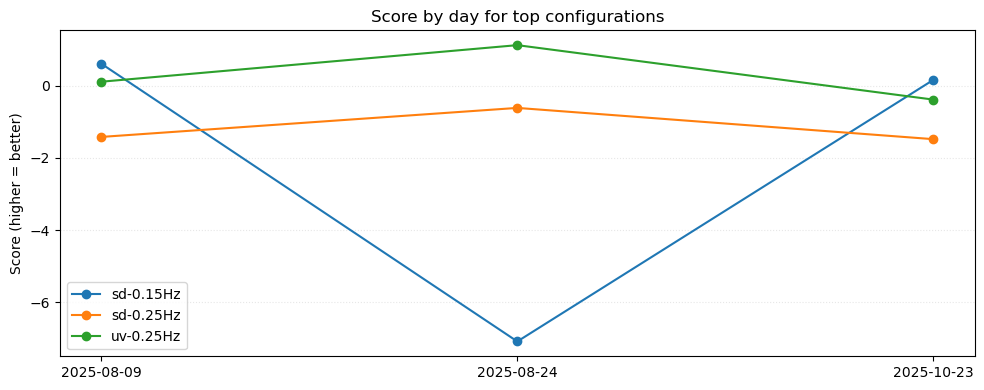

In [18]:
"""
Phase-1 Spectral model selection (MIKE 21 SW)
- Computes per-file/per-day metrics (Hs stats + Pearson r and p)
- Applies physically-motivated filtering (U10 > MIN_WIND, n >= MIN_POINTS)
- Screens admissible configs on reference day via Hs_p95 plausibility bounds
- Ranks configs by robustness across days (mean/min r_stress, fraction positive)
- OPTIONAL: adds a soft "order-of-magnitude target" term (can be disabled)
"""

import os
import re
import numpy as np
import pandas as pd
import mikeio
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ----------------------------
# USER CONFIG
# ----------------------------
dfs0_files = [
    # --- SD 2025-10-23 ---
    r"08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",
    r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    r"30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- SD 2025-08-09 ---
    r"20_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",
    r"19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    r"18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    r"29_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- UV 2025-10-23 ---
    r"13_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",
    r"12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",
    r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",
    r"14_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- UV 2025-08-09 ---
    r"21_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",
    r"16_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",
    r"17_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",
    r"22_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- UV 2025-08-24 ---
    r"24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",
    r"25_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",
    r"26_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",
    r"27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- SD 2025-08-24 ---
    r"33_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",
    r"31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    r"32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    r"34_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",
]

# Folder containing the dfs0 files
# (You already have this in your notebook; keep your existing value.)
# source_folder_mike21sw = r"..."
dfs0_paths = [os.path.join(source_folder_mike21sw, f) for f in dfs0_files]

# Time windows per day (keys MUST match parsed date string in filenames)
windows = {
    "2025-08-09": ("2025-08-09 02:00", "2025-08-09 23:00"),
    "2025-08-24": ("2025-08-24 02:00", "2025-08-24 23:00"),
    "2025-10-23": ("2025-10-23 02:00", "2025-10-23 23:00"),
}

REF_DAY = "2025-08-24"
TEST_DAYS = ["2025-08-09", "2025-10-23"]  # not strictly needed, but kept for clarity

# Plausibility bounds from your methodology (IMPORTANT: meters)
PLAUS_MIN_HS95 = 0.05
PLAUS_MAX_HS95 = 1.40

# Minimum wind forcing threshold and minimum sample size
MIN_WIND = 1.0
MIN_POINTS = 15

# OPTIONAL: soft targets (order-of-magnitude reference, NOT ground truth)
# Set USE_SOFT_TARGETS = False to fully align with "bounds-only" plausibility.
USE_SOFT_TARGETS = False
TARGETS = {
    "2025-08-24": 0.25,
    "2025-10-23": 1.44,  # SMB-derived upper bound / reference
    "2025-08-09": 0.05
}
# Weight of the soft magnitude term (keep small)
W_MAG = 0.10

# ----------------------------
# HELPERS
# ----------------------------
def parse_meta(path_or_name: str) -> dict:
    """Parse date, forcing type, and minimum frequency from dfs0 file name."""
    base = os.path.basename(path_or_name)
    m_date = re.search(r"(\d{4}-\d{2}-\d{2})", base)
    m_type = re.search(r"-(sd|uv)-wind", base)
    m_hz   = re.search(r"_([0-9.]+)Hz", base)
    return {
        "date": m_date.group(1) if m_date else None,
        "forcing": m_type.group(1) if m_type else None,
        "hz": float(m_hz.group(1)) if m_hz else None,
        "file": base,
    }

def find_hs_col(df: pd.DataFrame) -> str:
    """Try to locate the Hs/Hm0 column in MIKE 21 SW dfs0 export."""
    for c in df.columns:
        lc = c.lower()
        if "sign. wave height" in lc or "hm0" in lc or lc.strip() == "hs" or " hs" in lc:
            return c
    raise ValueError(f"Could not find Hs column. Columns: {list(df.columns)}")

def find_wind_col(df: pd.DataFrame) -> str | None:
    """Try to locate a wind speed column (as exported in your dfs0)."""
    for c in df.columns:
        if "wind speed" in c.lower():
            return c
    return None

# ----------------------------
# METRICS FOR ONE FILE
# ----------------------------
def metrics_for_file(dfs0_path: str, start: str, end: str) -> dict:
    """
    Computes:
      - Hs_mean, Hs_p95, Hs_max, Hs_std
      - Pearson r,p for (wind, Hs) and (wind^2, Hs)
      - n (after filtering: dropna + wind > MIN_WIND)
    """
    ds = mikeio.read(dfs0_path)
    df = ds.to_dataframe()
    df.index = pd.to_datetime(df.index)

    hs_col = find_hs_col(df)
    wind_col = find_wind_col(df)

    sub = df.loc[pd.Timestamp(start):pd.Timestamp(end)].copy()

    # Joint filtering to ensure aligned time steps
    if wind_col is not None:
        data = sub[[wind_col, hs_col]].dropna()
        data = data[data[wind_col] > MIN_WIND]
    else:
        data = sub[[hs_col]].dropna()

    # Guard clauses
    if data.empty or len(data) < MIN_POINTS:
        return {
            "Hs_mean": np.nan, "Hs_p95": np.nan, "Hs_max": np.nan, "Hs_std": np.nan,
            "windHs_r": np.nan, "windHs_p": np.nan,
            "wind2Hs_r": np.nan, "wind2Hs_p": np.nan,
            "n": int(len(data)),
        }

    hs = data[hs_col].values.astype(float)
    out = {
        "Hs_mean": float(np.mean(hs)),
        "Hs_p95":  float(np.percentile(hs, 95)),
        "Hs_max":  float(np.max(hs)),
        "Hs_std":  float(np.std(hs, ddof=0)),
        "n": int(len(hs)),
    }

    if wind_col is not None:
        w = data[wind_col].values.astype(float)

        # Pearson correlations
        r1, p1 = pearsonr(w, hs)
        r2, p2 = pearsonr(w**2, hs)

        out["windHs_r"], out["windHs_p"] = float(r1), float(p1)
        out["wind2Hs_r"], out["wind2Hs_p"] = float(r2), float(p2)

    return out

# ----------------------------
# SCORING (physics-first)
# ----------------------------
def compute_score_day(d: pd.DataFrame) -> pd.DataFrame:
    """
    Score computed per day (event regime) to avoid mixing regimes.
    Primary driver: standardized wind²–Hs correlation (r_stress proxy).
    Penalties:
      - strong penalty for non-positive coupling (r2 <= 0)
      - mild penalty for non-significant coupling (p > 0.05)  <-- FIXED
    Optional:
      - small soft magnitude term based on |Hs_p95 - TARGET|
    """
    d = d.copy()
    date = d["date"].iloc[0]

    r2 = d["wind2Hs_r"].astype(float)
    p2 = d["wind2Hs_p"].astype(float)

    # Penalty for physically inconsistent (non-positive) coupling
    neg_penalty = np.where(np.isfinite(r2) & (r2 <= 0), -5.0, 0.0)

    # Penalty for non-significant coupling (FIXED: threshold should be 0.05)
    ns_penalty = np.where(np.isfinite(p2) & (p2 > 0.05), -1.0, 0.0)

    # Standardize correlation within the day
    mu, sd = np.nanmean(r2), np.nanstd(r2)
    corr_z = (r2 - mu) / sd if np.isfinite(sd) and sd > 0 else (r2 * 0.0)

    # Optional soft magnitude term (small weight)
    mag_z = 0.0
    if USE_SOFT_TARGETS:
        target = TARGETS.get(date, None)
        if target is not None and np.isfinite(target):
            err = np.abs(d["Hs_p95"].astype(float) - float(target))
            mu_e, sd_e = np.nanmean(err), np.nanstd(err)
            mag_z = -((err - mu_e) / sd_e) if np.isfinite(sd_e) and sd_e > 0 else 0.0

    d["score"] = (1.0 * corr_z) + (W_MAG * mag_z) + neg_penalty + ns_penalty
    return d

# ----------------------------
# BUILD MASTER TABLE
# ----------------------------
rows, missing = [], []

for p in dfs0_paths:
    meta = parse_meta(p)
    if meta["date"] not in windows:
        continue
    if not os.path.exists(p):
        missing.append(p)
        continue

    start, end = windows[meta["date"]]
    met = metrics_for_file(p, start, end)
    rows.append({**meta, **met, "path": p})

df = pd.DataFrame(rows)

if missing:
    print("WARNING: missing files:")
    for m in missing:
        print(" -", m)

# Score per day (regime-specific scoring)
df = (
    df.groupby("date", group_keys=False)
      .apply(compute_score_day)
      .reset_index(drop=True)
)

# ----------------------------
# 1) RANK ON REFERENCE DAY
# ----------------------------
df_ref = df[df["date"] == REF_DAY].sort_values("score", ascending=False)

# Admissibility filter on reference day (FIXED: 0.05 not 0.5; max 1.4 not 1.5)
admissible = df_ref[
    (df_ref["Hs_p95"] > PLAUS_MIN_HS95) &
    (df_ref["Hs_p95"] < PLAUS_MAX_HS95)
][["forcing", "hz"]].drop_duplicates()

# Keep only admissible configs across all days
df_adm = df.merge(admissible, on=["forcing", "hz"], how="inner")

print(f"\nRANKING ON REFERENCE DAY: {REF_DAY}")
display(df_ref[["forcing","hz","score","Hs_mean","Hs_p95","Hs_max","windHs_r","wind2Hs_r","wind2Hs_p","n","file"]])

print("\nADMISSIBLE CONFIGS (based on reference-day plausibility bounds):")
display(admissible.sort_values(["forcing","hz"]))

print("\nMETRICS FOR ADMISSIBLE CONFIGS (all days):")
display(df_adm[["date","forcing","hz","score","Hs_p95","wind2Hs_r","wind2Hs_p","n","file"]]
        .sort_values(["forcing","hz","date"]))

# ----------------------------
# 2) ROBUSTNESS SELECTION ACROSS DAYS (final selection)
# ----------------------------
robust = (
    df_adm
    .groupby(["forcing","hz"])
    .agg(
        mean_r2=("wind2Hs_r","mean"),
        min_r2=("wind2Hs_r","min"),
        frac_positive=("wind2Hs_r", lambda x: float((x > 0).mean())),
        mean_Hs_p95=("Hs_p95","mean"),  # <-- ADDED to match your printed output
        min_Hs_p95=("Hs_p95","min"),
        max_Hs_p95=("Hs_p95","max"),
    )
    .reset_index()
    .sort_values(["mean_r2", "frac_positive", "min_r2"], ascending=[False, False, False])
)

print("\nROBUSTNESS RANKING ACROSS DAYS (recommended final selection):")
display(robust)

best = robust.iloc[0]
print("\nSELECTED CONFIGURATION (robust):")
print(best)

# ----------------------------
# OPTIONAL PLOT: score by day for top configs
# ----------------------------
topN = 3
top_cfg = robust.head(topN)[["forcing","hz"]]

df_top = df.merge(top_cfg, on=["forcing","hz"], how="inner")

plt.figure(figsize=(10, 4))
for (forcing, hz), g in df_top.groupby(["forcing", "hz"]):
    g = g.sort_values("date")
    plt.plot(g["date"], g["score"], marker="o", label=f"{forcing}-{hz}Hz")
plt.title("Score by day for top configurations")
plt.ylabel("Score (higher = better)")
plt.grid(axis="y", alpha=0.3, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
import mikeio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr

def analyze_physical_consistency(
    dfs0_path,
    forcing=None,
    hz=None,
    time_start=None,
    time_end=None,
    wind_item_name=None,
    wave_item_contains="Sign. Wave Height",
    min_wind=0.0,
):
    """
    Reads a MIKE 21 SW point output (DFS0) and evaluates wind–wave physical consistency:
      - Pearson correlation between wind speed and Hs
      - Pearson correlation between wind^2 and Hs (proxy for wind stress)
      - Scatter plot and normalized time-series comparison
    """
    print(f"--- Analyzing: {dfs0_path} ---")

    # 1) Read DFS0
    ds = mikeio.read(dfs0_path)
    df = ds.to_dataframe()
    df.index = pd.to_datetime(df.index)

    # 2) Optional time window
    if time_start is not None or time_end is not None:
        if time_start is None:
            time_start = df.index.min()
        else:
            time_start = pd.Timestamp(time_start)
        if time_end is None:
            time_end = df.index.max()
        else:
            time_end = pd.Timestamp(time_end)

        df = df.loc[time_start:time_end]

    print("Available items in file:", df.columns.tolist())

    # 3) Find Hs column
    hs_col = None
    target = wave_item_contains.lower()
    for col in df.columns:
        if target in col.lower() or "hs" in col.lower() or "hm0" in col.lower():
            hs_col = col
            break
    if hs_col is None:
        print(f"Error: Could not find wave height column containing '{wave_item_contains}'.")
        return

    # 4) Find wind speed column
    wind_col = None
    if wind_item_name:
        wind_col = wind_item_name if wind_item_name in df.columns else None
    else:
        for col in df.columns:
            if "wind speed" in col.lower():
                wind_col = col
                break

    if wind_col is None:
        print("Warning: 'Wind speed' not found in this DFS0 file.")
        return

    # 5) Clean data
    data = df[[wind_col, hs_col]].dropna()
    data = data[data[wind_col] > min_wind]

    if len(data) < 10:
        print("Not enough valid points after filtering (need >= 10).")
        return

    # 6) Correlations
    r_val, p_val = pearsonr(data[wind_col].values, data[hs_col].values)
    r2_val, p2_val = pearsonr((data[wind_col].values**2), data[hs_col].values)

    print("\nRESULTS:")
    print(f"Wind–Hs correlation r:        {r_val:.3f}   (p={p_val:.2e})")
    print(f"Wind²–Hs correlation r(w²):   {r2_val:.3f}   (p={p2_val:.2e})")
    print(f"Points used (after filters):  {len(data)}")
    print(f"Window:                       {data.index.min()} → {data.index.max()}")

    # 7) Verdict
    if r_val >= 0.6:
        verdict = "MODERATE–STRONG coupling"
    elif 0.4 <= r_val < 0.6:
        verdict = "MODERATE coupling"
    elif 0.25 <= r_val < 0.4:
        verdict = "WEAK but plausible coupling"
    else:
        verdict = "VERY weak coupling"
    print(f">> VERDICT: {verdict}")

    # 8) Plotting
    plt.figure(figsize=(10, 5))

    # --- Scatter plot ---
    plt.subplot(1, 2, 1)
    plt.scatter(data[wind_col], data[hs_col], color='blue', alpha=0.5)
    plt.title(f"Wind: {forcing} - Minimum Frequency ={hz} Hz\nr={r_val:.2f}, r(w²)={r2_val:.2f}")
    plt.xlabel("Wind Speed [m/s]")
    plt.ylabel("Significant Wave Height Hs [m]")
    plt.grid(True)

    # --- Normalized time series ---
    ax_ts = plt.subplot(1, 2, 2)

    w = data[wind_col].values
    h = data[hs_col].values
    norm_wind = (w - np.nanmin(w)) / (np.nanmax(w) - np.nanmin(w) + 1e-12)
    norm_hs   = (h - np.nanmin(h)) / (np.nanmax(h) - np.nanmin(h) + 1e-12)

    ax_ts.plot(data.index, norm_wind, label="Wind (norm.)", color='grey', alpha=0.6)
    ax_ts.plot(data.index, norm_hs, label="Hs (norm.)", color='blue')
    ax_ts.set_title(f"Wind: {forcing} - Minimum Frequency ={hz} Hz\nNormalized time-series shape")
    ax_ts.legend()
    ax_ts.grid(True)

    # ---- X-axis formatting (HH:MM + 45° rotation) ----
    ax_ts.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax_ts.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_ts.get_xticklabels(), rotation=45, ha="right")
    save_path = os.path.join(source_folder_mike21sw, f"{forcing}_{hz}Hz_MIKE21_SW_compared_with_wind.png")
    plt.savefig(save_path, dpi=300)
    plt.tight_layout()
    plt.show()

    return {
        "r": r_val,
        "p": p_val,
        "r_w2": r2_val,
        "p_w2": p2_val,
        "n": len(data),
        "plotsaved": save_path
    }



--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.292   (p=8.49e-04)
Wind²–Hs correlation r(w²):   0.290   (p=9.31e-04)
Points used (after filters):  127
Window:                       2025-08-24 02:00:00 → 2025-08-24 23:40:00
>> VERDICT: WEAK but plausible coupling


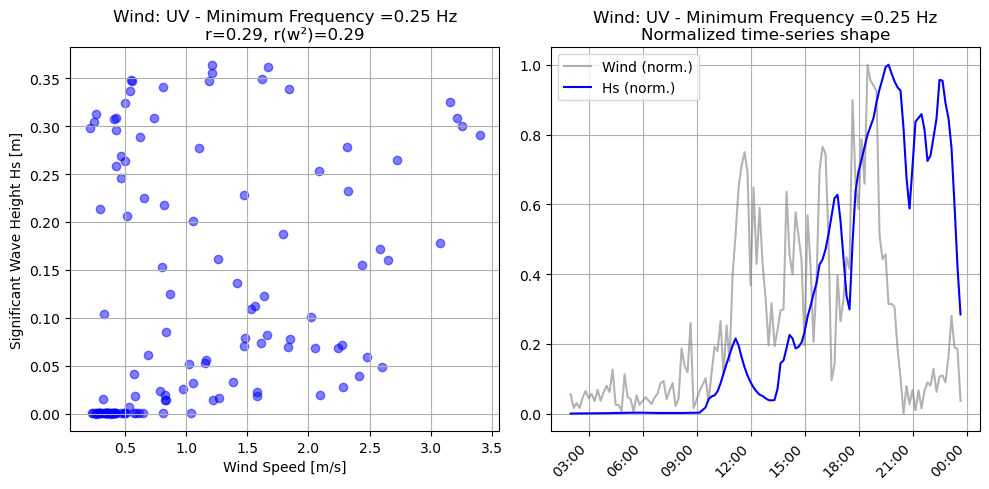

{'r': 0.29245181791639757,
 'p': 0.0008486106074806753,
 'r_w2': 0.290297173966792,
 'p_w2': 0.000930524954364986,
 'n': 127,
 'plotsaved': 'C:\\Users\\A\\Documents\\XX_GitHub_Repo\\data-waves\\MIKE21\\SW_results\\UV_0.25Hz_MIKE21_SW_compared_with_wind.png'}

In [20]:
analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw,
        r"27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-08-24 02:00",
    time_end="2025-08-24 23:50",
    forcing= "UV",
    hz="0.25",
    min_wind=0.2
)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\22_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        -0.106   (p=2.34e-01)
Wind²–Hs correlation r(w²):   -0.050   (p=5.74e-01)
Points used (after filters):  128
Window:                       2025-08-09 02:00:00 → 2025-08-09 23:50:00
>> VERDICT: VERY weak coupling


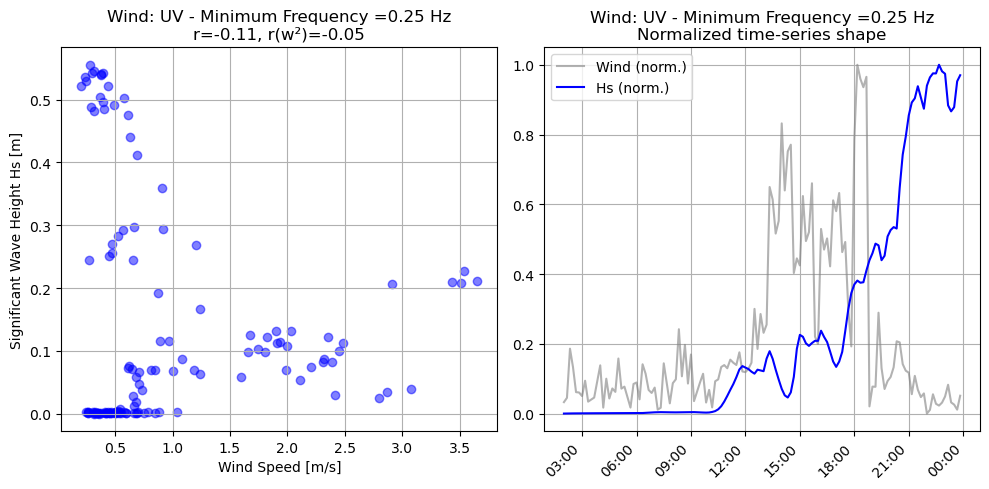

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.292   (p=8.49e-04)
Wind²–Hs correlation r(w²):   0.290   (p=9.31e-04)
Points used (after filters):  127
Window:                       2025-08-24 02:00:00 → 2025-08-24 23:40:00
>> VERDICT: WEAK but plausible coupling


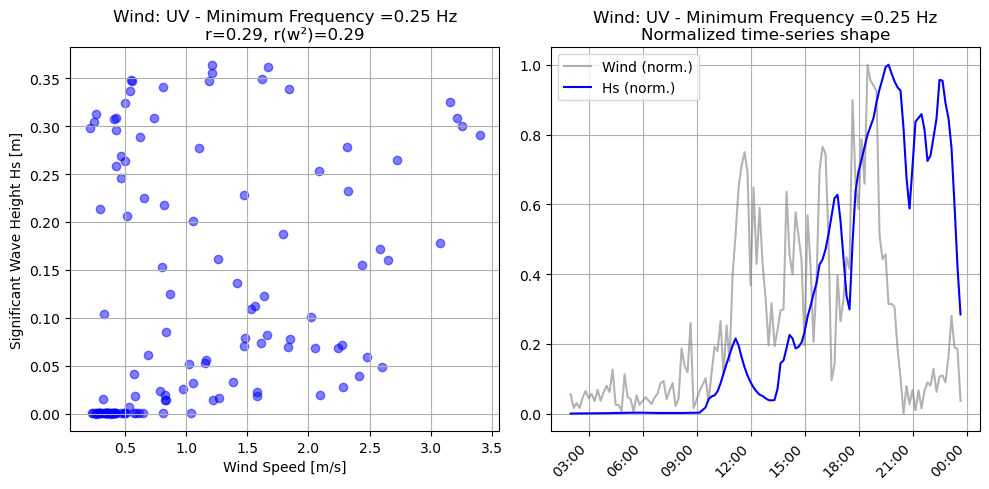

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\14_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.266   (p=2.14e-03)
Wind²–Hs correlation r(w²):   0.276   (p=1.44e-03)
Points used (after filters):  131
Window:                       2025-10-23 02:00:00 → 2025-10-23 23:50:00
>> VERDICT: WEAK but plausible coupling


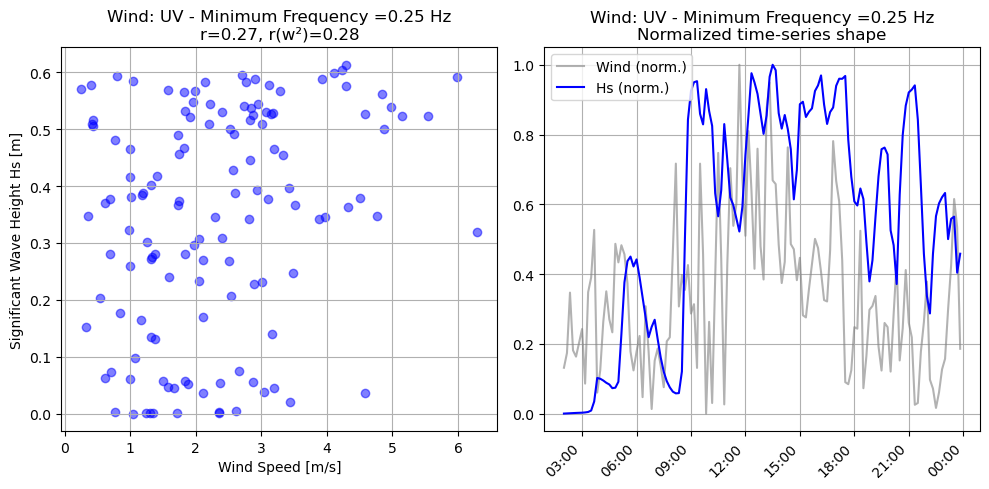

{'r': 0.2659095538535958,
 'p': 0.0021422489898341875,
 'r_w2': 0.27565706518767313,
 'p_w2': 0.0014386700286069811,
 'n': 131,
 'plotsaved': 'C:\\Users\\A\\Documents\\XX_GitHub_Repo\\data-waves\\MIKE21\\SW_results\\UV_0.25Hz_MIKE21_SW_compared_with_wind.png'}

In [27]:
#------------------------------------------------------
# Results UV 0.25 Hz
#------------------------------------------------------


analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw,
        r"22_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-08-09 02:00",
    time_end="2025-08-09 23:50",
    forcing= "UV",
    hz="0.25",
    min_wind=0.2
)


analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw,
        r"27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-08-24 02:00",
    time_end="2025-08-24 23:50",
    forcing= "UV",
    hz="0.25",
    min_wind=0.2
)

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw,
         r"14_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-10-23 02:00",
    time_end="2025-10-23 23:50",
    forcing= "UV",
    hz="0.25",
    min_wind=0.2
)

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.340   (p=6.48e-05)
Wind²–Hs correlation r(w²):   0.337   (p=7.74e-05)
Points used (after filters):  132
Window:                       2025-08-09 02:00:00 → 2025-08-09 23:50:00
>> VERDICT: WEAK but plausible coupling


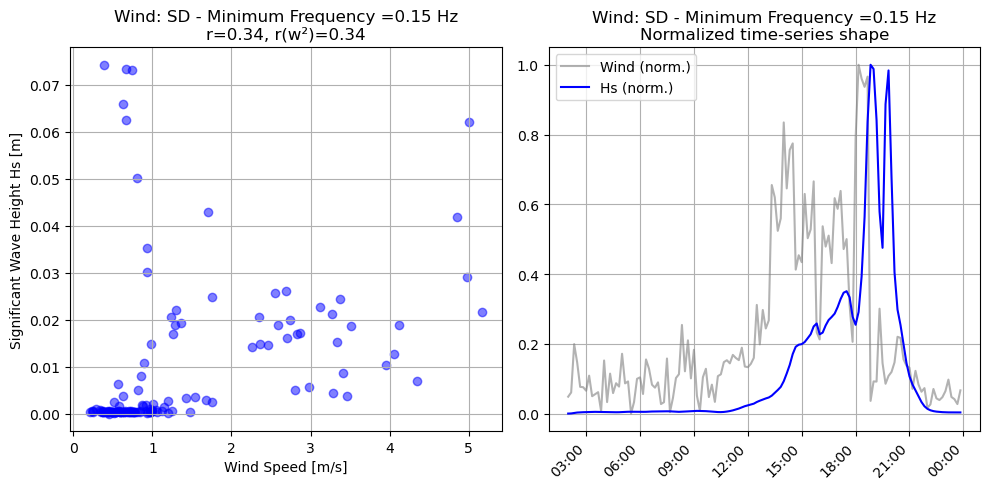

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.209   (p=1.64e-02)
Wind²–Hs correlation r(w²):   0.142   (p=1.05e-01)
Points used (after filters):  131
Window:                       2025-08-24 02:00:00 → 2025-08-24 23:50:00
>> VERDICT: VERY weak coupling


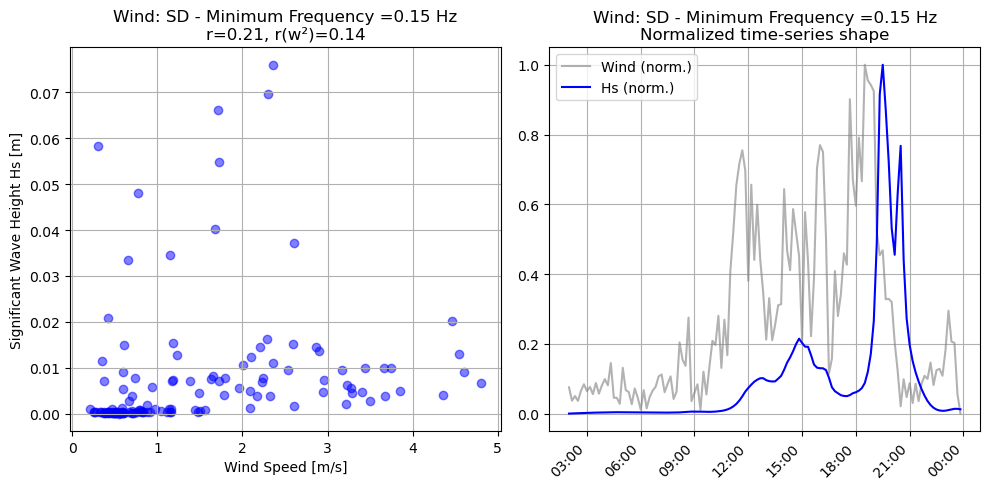

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.387   (p=5.04e-06)
Wind²–Hs correlation r(w²):   0.370   (p=1.39e-05)
Points used (after filters):  131
Window:                       2025-10-23 02:00:00 → 2025-10-23 23:50:00
>> VERDICT: WEAK but plausible coupling


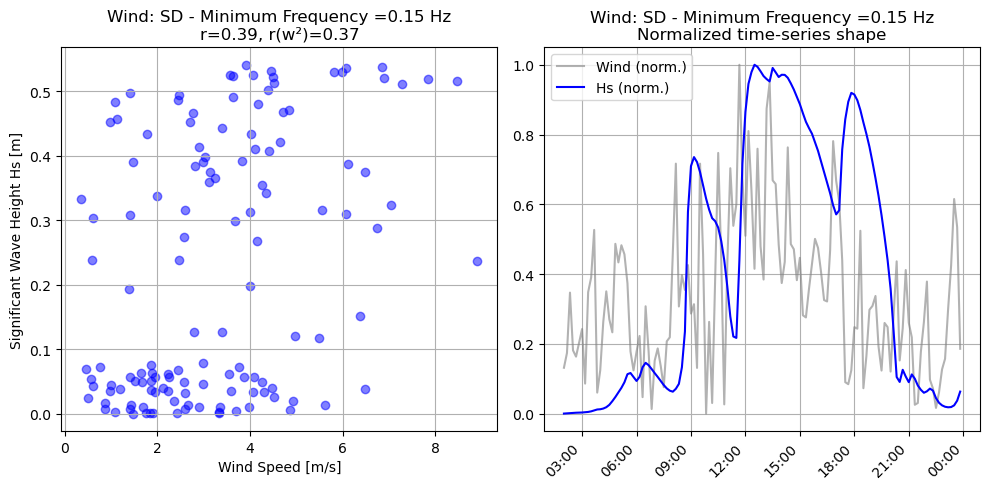

{'r': 0.38674495972919437,
 'p': 5.044818842948989e-06,
 'r_w2': 0.36971293852989756,
 'p_w2': 1.3863579749851964e-05,
 'n': 131,
 'plotsaved': 'C:\\Users\\A\\Documents\\XX_GitHub_Repo\\data-waves\\MIKE21\\SW_results\\SD_0.15Hz_MIKE21_SW_compared_with_wind.png'}

In [25]:
#------------------------------------------------------
#Results SD 0.15 Hz
#------------------------------------------------------

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    ),
    time_start="2025-08-09 02:00",
    time_end="2025-08-09 23:50",
    forcing= "SD",
    hz="0.15",
    min_wind=0.2
)

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    ),
    time_start="2025-08-24 02:00",
    time_end="2025-08-24 23:50",
    forcing= "SD",
    hz="0.15",
    min_wind=0.2
)


analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    ),
    time_start="2025-10-23 02:00",
    time_end="2025-10-23 23:50",
    forcing= "SD",
    hz="0.15",
    min_wind=0.2
)



--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\29_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.312   (p=2.77e-04)
Wind²–Hs correlation r(w²):   0.264   (p=2.20e-03)
Points used (after filters):  132
Window:                       2025-08-09 02:00:00 → 2025-08-09 23:50:00
>> VERDICT: WEAK but plausible coupling


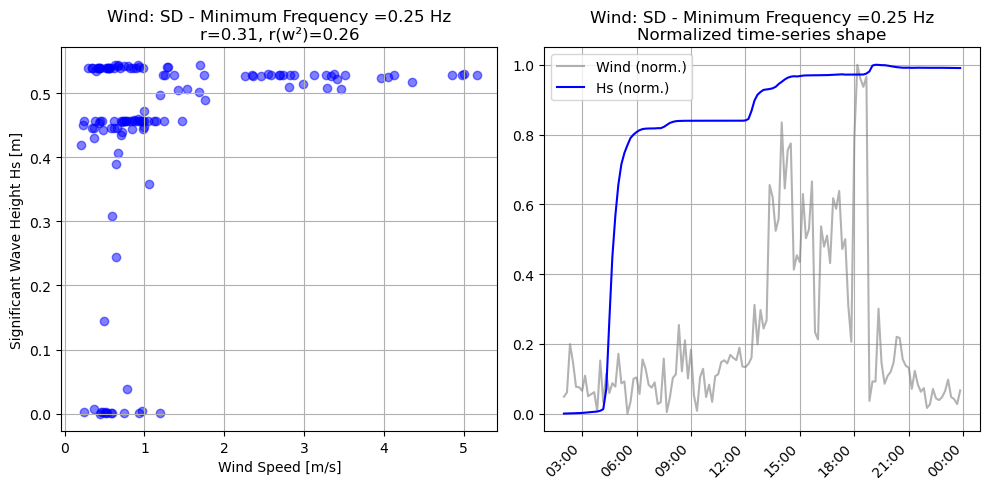

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\34_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.409   (p=1.23e-06)
Wind²–Hs correlation r(w²):   0.329   (p=1.24e-04)
Points used (after filters):  131
Window:                       2025-08-24 02:00:00 → 2025-08-24 23:50:00
>> VERDICT: MODERATE coupling


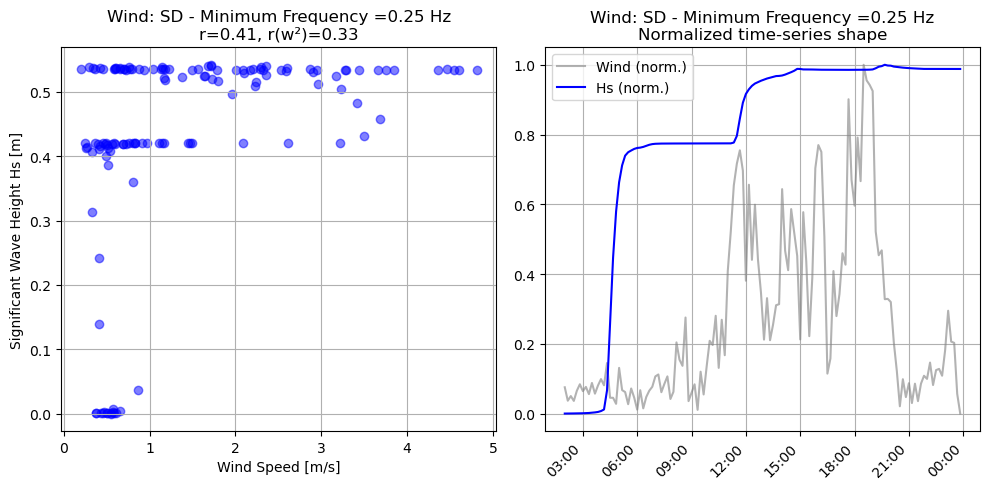

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.197   (p=2.44e-02)
Wind²–Hs correlation r(w²):   0.190   (p=2.95e-02)
Points used (after filters):  131
Window:                       2025-10-23 02:00:00 → 2025-10-23 23:50:00
>> VERDICT: VERY weak coupling


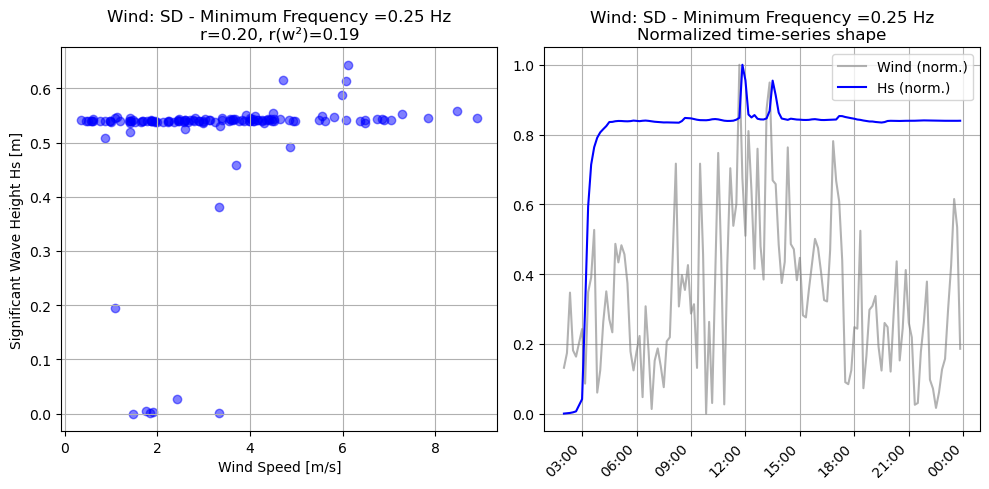

{'r': 0.19666319088572673,
 'p': 0.02436187811829942,
 'r_w2': 0.19024035890934837,
 'p_w2': 0.029521714375963962,
 'n': 131,
 'plotsaved': 'C:\\Users\\A\\Documents\\XX_GitHub_Repo\\data-waves\\MIKE21\\SW_results\\SD_0.25Hz_MIKE21_SW_compared_with_wind.png'}

In [29]:
#------------------------------------------------------
# Results SD 0.25 Hz
#------------------------------------------------------

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"29_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-08-09 02:00",
    time_end="2025-08-09 23:50",
    forcing= "SD",
    hz="0.25",
    min_wind=0.2
)

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"34_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-08-24 02:00",
    time_end="2025-08-24 23:50",
    forcing= "SD",
    hz="0.25",
    min_wind=0.2
)

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",
    ),
    time_start="2025-10-23 02:00",
    time_end="2025-10-23 23:50",
    forcing= "SD",
    hz="0.25",
    min_wind=0.2
)


--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.179   (p=4.02e-02)
Wind²–Hs correlation r(w²):   0.167   (p=5.59e-02)
Points used (after filters):  132
Window:                       2025-08-09 02:00:00 → 2025-08-09 23:50:00
>> VERDICT: VERY weak coupling


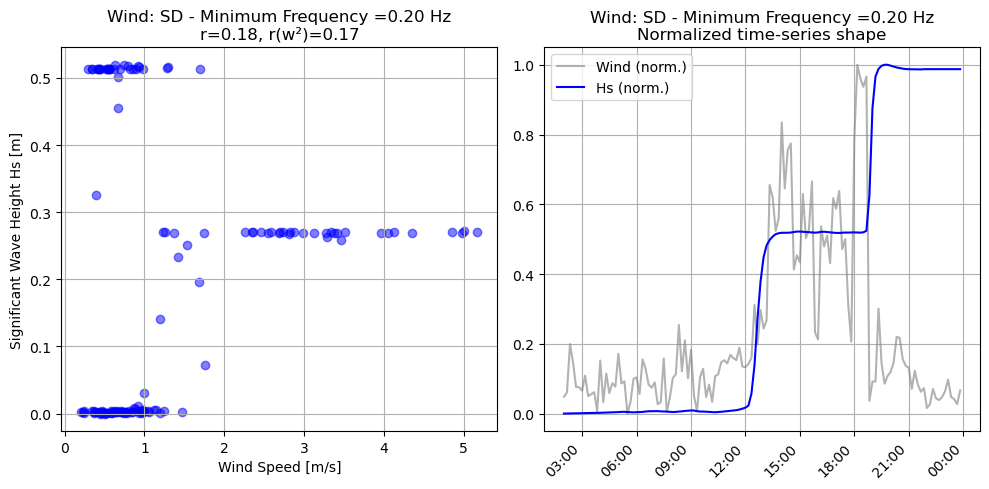

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.323   (p=1.69e-04)
Wind²–Hs correlation r(w²):   0.255   (p=3.32e-03)
Points used (after filters):  131
Window:                       2025-08-24 02:00:00 → 2025-08-24 23:50:00
>> VERDICT: WEAK but plausible coupling


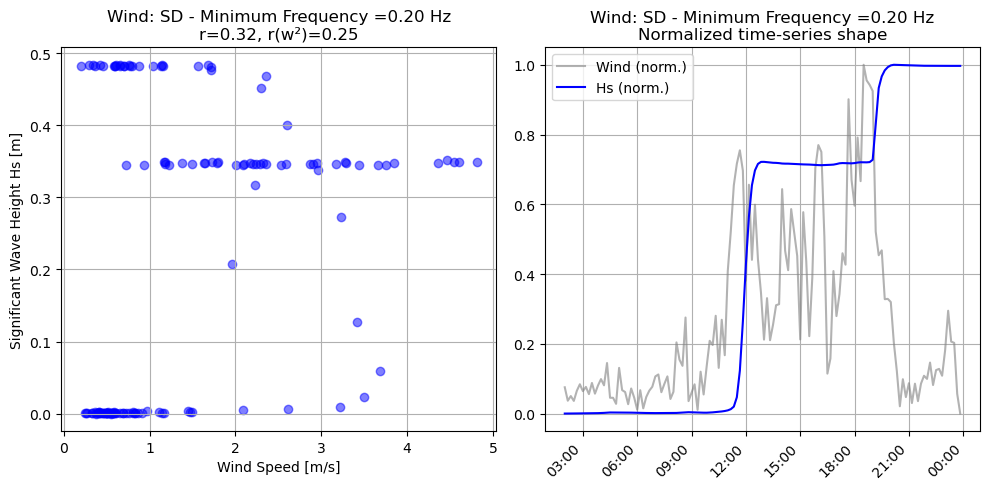

--- Analyzing: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0 ---
Available items in file: ['SUP-2025-08-31-06:50: Sign. Wave Height', 'SUP-2025-08-31-06:50: Max. Wave Height', 'SUP-2025-08-31-06:50: Peak Wave Period', 'SUP-2025-08-31-06:50: Wave Period, T01', 'SUP-2025-08-31-06:50: Mean Wave Directio', 'SUP-2025-08-31-06:50: Dir. Stand. Deviat', 'SUP-2025-08-31-06:50: Wave power, p', 'SUP-2025-08-31-06:50: Wave power, Px', 'SUP-2025-08-31-06:50: Wave power, Py', 'SUP-2025-08-31-06:50: Water depth', 'SUP-2025-08-31-06:50: Wind speed', 'SUP-2025-08-31-06:50: Wind direction']

RESULTS:
Wind–Hs correlation r:        0.216   (p=1.30e-02)
Wind²–Hs correlation r(w²):   0.218   (p=1.23e-02)
Points used (after filters):  131
Window:                       2025-10-23 02:00:00 → 2025-10-23 23:50:00
>> VERDICT: VERY weak coupling


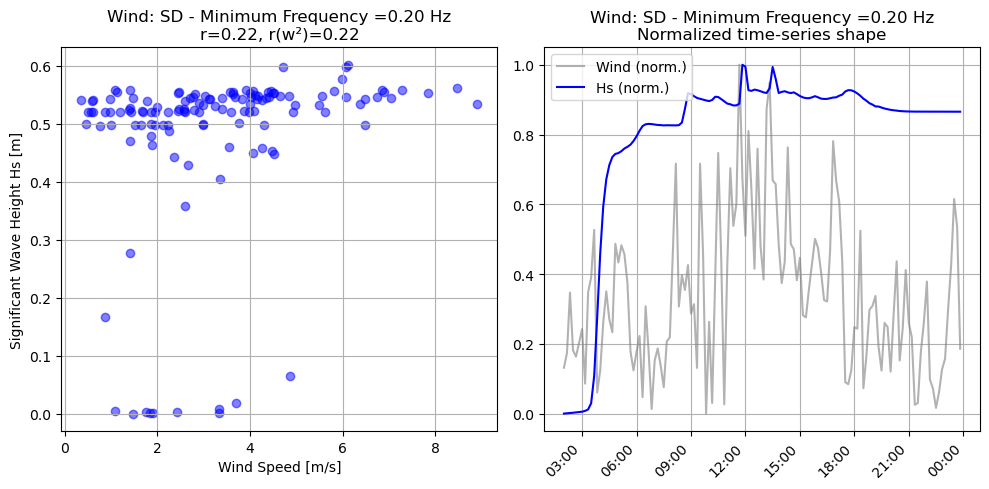

{'r': 0.21642456715357286,
 'p': 0.013033524660093693,
 'r_w2': 0.21805485012950504,
 'p_w2': 0.012348824324071224,
 'n': 131,
 'plotsaved': 'C:\\Users\\A\\Documents\\XX_GitHub_Repo\\data-waves\\MIKE21\\SW_results\\SD_0.20Hz_MIKE21_SW_compared_with_wind.png'}

In [28]:
#------------------------------------------------------
# Results SD 0.20 Hz
#------------------------------------------------------

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    ),
    time_start="2025-08-09 02:00",
    time_end="2025-08-09 23:50",
    forcing= "SD",
    hz="0.20",
    min_wind=0.2
)

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    ),
    time_start="2025-08-24 02:00",
    time_end="2025-08-24 23:50",
    forcing= "SD",
    hz="0.20",
    min_wind=0.2
)

analyze_physical_consistency(
    dfs0_path=os.path.join(source_folder_mike21sw, r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    ),
    time_start="2025-10-23 02:00",
    time_end="2025-10-23 23:50",
    forcing= "SD",
    hz="0.20",
    min_wind=0.2
)


In [ ]:
    # --- SD 2025-10-23 ---
    r"08_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",
    r"09_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    r"07_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    r"30_SW-point-parameters - 2025-10-23-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- SD 2025-08-09 ---
    r"20_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",
    r"19_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    r"18_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    r"29_SW-point-parameters - 2025-08-09-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- UV 2025-10-23 ---
    r"13_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",
    r"12_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",
    r"06_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",
    r"14_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- UV 2025-08-09 ---
    r"21_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",
    r"16_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0",
    r"17_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",
    r"22_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",
     
    # --- UV 2025-08-24 ---
    r"24_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.1Hz.dfs0",
    r"25_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.15Hz.dfs0", 
    r"26_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.2Hz.dfs0",  
    r"27_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_growth1.2_0.25Hz.dfs0",

    # --- SD 2025-08-24 ---
    r"33_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.1Hz.dfs0",
    r"31_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.15Hz.dfs0",
    r"32_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.2Hz.dfs0",
    r"34_SW-point-parameters - 2025-08-24-0200-2300-sd-wind_10min_growth1.2_0.25Hz.dfs0",

# Comparison of SD and UV windfields

--- Consistency Check ---
Max Speed Difference: 0.000001 m/s
Mean Speed Difference: 0.000000 m/s
✅ The wind speeds match perfectly.


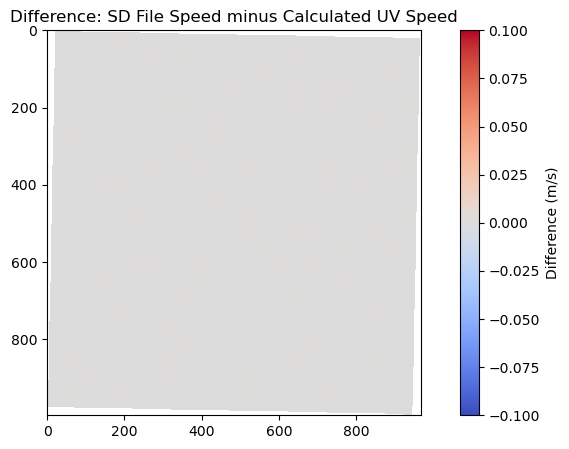

In [22]:
import mikeio
import numpy as np
import matplotlib.pyplot as plt


# Source folder for Spectral Wave models from MIKE 21 SW results
source_folder_mike21sw = os.path.join(parent_dir, r"MIKE21\SW_results")
os.makedirs(source_folder_mike21sw, exist_ok=True)

file_uv = os.path.join(parent_dir,r"MIKE21\wind_dfs2\wind_uv_20250809-0200.dfs2")
file_sd = os.path.join(parent_dir,r"MIKE21\wind_dfs2\wind_sd_20250809_0200.dfs2")

# 1. Load the two files
ds_uv = mikeio.read(file_uv)
ds_sd = mikeio.read(file_sd)

# 2. Extract the data arrays (for the first timestep)
u = ds_uv["U wind"][0].to_numpy()
v = ds_uv["V wind"][0].to_numpy()
speed_ref = ds_sd["Wind speed"][0].to_numpy()
dir_ref = ds_sd["Wind direction"][0].to_numpy()

# 3. Calculate Speed from U and V
# Formula: Speed = sqrt(U^2 + V^2)
speed_calc = np.sqrt(u**2 + v**2)

# 4. Calculate Difference (Residuals)
speed_diff = speed_ref - speed_calc

# 5. Report Statistics
max_diff = np.nanmax(np.abs(speed_diff))
mean_diff = np.nanmean(np.abs(speed_diff))

print("--- Consistency Check ---")
print(f"Max Speed Difference: {max_diff:.6f} m/s")
print(f"Mean Speed Difference: {mean_diff:.6f} m/s")

if max_diff < 0.01:
    print("✅ The wind speeds match perfectly.")
else:
    print("⚠️ Discrepancy detected! The files might use different units or projections.")

# 6. Plot the Difference
plt.figure(figsize=(10, 5))
plt.imshow(speed_diff, cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar(label="Difference (m/s)")
plt.title("Difference: SD File Speed minus Calculated UV Speed")
plt.show()

--- Direction Consistency Check ---
Max Direction Difference (speed > 0.01 m/s): 0.000046 degrees
Mean Direction Difference: 0.000006 degrees
✅ The wind directions match perfectly.


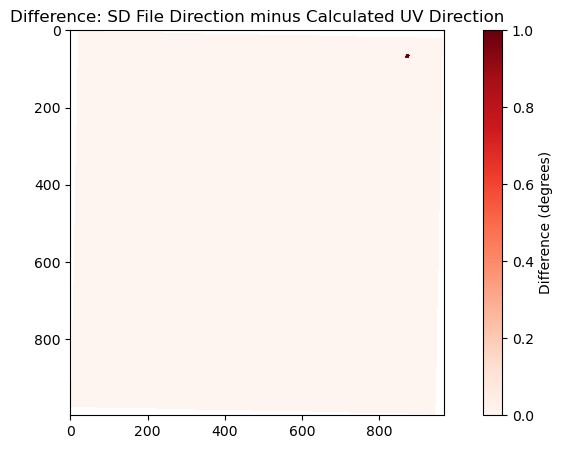

In [351]:
# 2. Extract arrays (Time step 0)
u = ds_uv["U wind"][0].to_numpy()
v = ds_uv["V wind"][0].to_numpy()
dir_ref = ds_sd["Wind direction"][0].to_numpy()
speed_ref = ds_sd["Wind speed"][0].to_numpy() # Used for masking

# 3. Calculate Meteorological Direction from U/V
# Math angle = atan2(V, U) -> "Going to", CCW from East
# Met direction = (270 - Math_Degrees) % 360 -> "Coming from", CW from North
math_angle = np.degrees(np.arctan2(v, u))
dir_calc = (270 - math_angle) % 360

# 4. Calculate Shortest Angular Difference
# Handles the 360 vs 0 degree wrap-around
raw_diff = np.abs(dir_ref - dir_calc)
dir_diff = np.minimum(raw_diff, 360 - raw_diff)

# 5. Filter out low wind speeds
# Direction is unstable/undefined when speed is near 0. We ignore cells < 0.01 m/s.
mask_valid = speed_ref > 0.01
diff_valid = dir_diff[mask_valid]

# 6. Report Statistics
print("--- Direction Consistency Check ---")
if diff_valid.size > 0:
    max_diff_dir = np.nanmax(diff_valid)
    mean_diff_dir = np.nanmean(diff_valid)
    print(f"Max Direction Difference (speed > 0.01 m/s): {max_diff_dir:.6f} degrees")
    print(f"Mean Direction Difference: {mean_diff_dir:.6f} degrees")

    if max_diff_dir < 0.1:
        print("✅ The wind directions match perfectly.")
    else:
        print("⚠️ Discrepancy detected! Check if one file uses 'Going To' convention.")
else:
    print("⚠️ No valid wind speeds found to check direction.")

# 7. Plot Discrepancies
plt.figure(figsize=(10, 5))
# Determine plot range based on errors (focus on small errors or big ones)
vmax = 1.0 if diff_valid.size > 0 and np.nanmax(diff_valid) < 5 else 180
plt.imshow(dir_diff, cmap='Reds', vmin=0, vmax=vmax)
plt.colorbar(label="Difference (degrees)")
plt.title("Difference: SD File Direction minus Calculated UV Direction")
plt.show()

# Transect Variability Analysis

In [30]:
import os
import re
import numpy as np
import pandas as pd
import mikeio
import matplotlib.pyplot as plt

# =========================================================
# PHASE 2 — TRANSECT VARIABILITY ANALYSIS (UV MODELS ONLY)
# =========================================================
# Goal:
#  - For each day (low / moderate / high wind), compare Hs time series at 9 points.
#  - Compute spatial heterogeneity using:
#       (1) RMSD (% relative difference)
#       (2) cross-correlation (max corr + best lag)
#  - Decide if ROI is spatially homogeneous (differences < 5%).
#  - If homogeneous, extract representative Hs at a reference timestamp (e.g., 06:50).
#
# Requirements:
#  - DFS0 files are point-parameter outputs with multiple point-columns for Hs.
#  - You provide: source_folder_mike21sw

# ----------------------------
# USER CONFIG
# ----------------------------
# Use your 3 scenario files (UV model)
SCENARIOS = {
    "low_wind_2025-08-09": {
        "file": r"10_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0",
        "window": ("2025-08-09 02:00", "2025-08-09 23:00"),
    },
    "moderate_2025-08-24": {
        "file": r"08_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0",
        "window": ("2025-08-24 02:00", "2025-08-24 23:00"),
    },
    "high_wind_2025-10-23": {
        "file": r"02_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0",
        "window": ("2025-10-23 02:00", "2025-10-23 23:00"),
    },
}

# If “negligible differences” < 5% (as in your methodology)
HOMOGENEITY_THRESHOLD_PCT = 5.0

# Cross-correlation maximum lag in minutes (10-min output -> 6 steps = 60 min)
MAX_LAG_MINUTES = 60

# Representative timestamp (if ROI homogeneous)
REP_TIME_HHMM = "06:50"  # nearest model timestamp will be used

# ----------------------------
# HELPERS
# ----------------------------
def _find_hs_columns(df: pd.DataFrame):
    """Return list of columns that look like Significant Wave Height at each point."""
    cols = []
    for c in df.columns:
        lc = c.lower()
        if ("sign. wave height" in lc) or ("hm0" in lc) or (re.search(r"\bhs\b", lc) is not None):
            cols.append(c)
    return cols

def _point_name_from_column(col: str):
    """
    DFS0 columns often look like:
      'SUP-2025-08-31-06:50: Sign. Wave Height'
    or
      '<PointName>: Sign. Wave Height'
    We use the prefix before ':' as the point identifier.
    """
    parts = col.split(":")
    return parts[0].strip() if parts else col.strip()

def _to_window(df: pd.DataFrame, start: str, end: str):
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    return df.loc[start:end].copy()

def _estimate_dt_minutes(index: pd.DatetimeIndex) -> float:
    if len(index) < 2:
        return np.nan
    diffs = index.to_series().diff().dropna().dt.total_seconds().values
    return float(np.nanmedian(diffs) / 60.0)

def _rmsd(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() == 0:
        return np.nan
    return float(np.sqrt(np.mean((a[m] - b[m]) ** 2)))

def _rmsd_percent(a: np.ndarray, b: np.ndarray, denom="mean_ref") -> float:
    """
    RMSD expressed as percent.
    denom:
      - 'mean_ref' : divide by mean(|ref|)
      - 'mean_pair': divide by mean of the pair
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() == 0:
        return np.nan

    rmsd_val = np.sqrt(np.mean((a[m] - b[m]) ** 2))

    if denom == "mean_pair":
        d = np.mean([np.mean(np.abs(a[m])), np.mean(np.abs(b[m]))])
    else:
        d = np.mean(np.abs(a[m]))

    if d <= 1e-12:
        return np.nan
    return float(100.0 * rmsd_val / d)

def _max_crosscorr(a: np.ndarray, b: np.ndarray, max_lag_steps: int):
    """
    Compute max normalized cross-correlation within +/- max_lag_steps.
    Returns: (max_corr, best_lag_steps)
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() < 3:
        return (np.nan, np.nan)

    a = a[m]
    b = b[m]

    # Remove mean to focus on shape/covariation
    a = a - np.mean(a)
    b = b - np.mean(b)

    denom = (np.std(a) * np.std(b))
    if denom <= 1e-12:
        return (np.nan, np.nan)

    best_corr = -np.inf
    best_lag = 0

    for lag in range(-max_lag_steps, max_lag_steps + 1):
        if lag < 0:
            aa = a[-lag:]
            bb = b[: len(aa)]
        elif lag > 0:
            aa = a[:-lag]
            bb = b[lag:]
        else:
            aa = a
            bb = b

        if len(aa) < 3:
            continue

        corr = np.mean(aa * bb) / denom
        if corr > best_corr:
            best_corr = corr
            best_lag = lag

    return (float(best_corr), int(best_lag))

def _nearest_time_value(series: pd.Series, hhmm: str):
    """
    Extract Hs at nearest timestamp matching hhmm (e.g., "06:50").
    If exact time not present, takes nearest within the day.
    """
    # Build target timestamp on the same date as series index
    day = series.index[0].date()
    target = pd.Timestamp(f"{day} {hhmm}")
    idx = series.index.get_indexer([target], method="nearest")[0]
    return series.index[idx], float(series.iloc[idx])

# ----------------------------
# CORE ANALYSIS FOR ONE SCENARIO
# ----------------------------
def analyze_transect_variability(dfs0_path: str, window: tuple, scenario_name: str):
    print(f"\n==============================")
    print(f"Phase 2 — {scenario_name}")
    print(f"File: {dfs0_path}")
    print(f"Window: {window[0]} → {window[1]}")
    print(f"==============================")

    ds = mikeio.read(dfs0_path)
    df = ds.to_dataframe()
    df.index = pd.to_datetime(df.index)

    df = _to_window(df, window[0], window[1])

    hs_cols = _find_hs_columns(df)
    if len(hs_cols) == 0:
        raise ValueError(f"No Hs columns found. Columns are: {list(df.columns)}")

    # Build Hs dataframe: columns = points
    hs = df[hs_cols].copy()
    hs.columns = [_point_name_from_column(c) for c in hs_cols]
    hs = hs.sort_index()

    # Drop columns with all NaN
    hs = hs.dropna(axis=1, how="all")

    # Determine dt and max lag steps
    dt_min = _estimate_dt_minutes(hs.index)
    if np.isnan(dt_min) or dt_min <= 0:
        dt_min = 10.0  # fallback typical
    max_lag_steps = int(round(MAX_LAG_MINUTES / dt_min))

    print(f"Detected points: {hs.shape[1]}")
    print(f"Time step ~ {dt_min:.1f} min; max lag = ±{max_lag_steps} steps (~±{MAX_LAG_MINUTES} min)")

    points = hs.columns.tolist()

    # Reference point for %RMSD reporting (use median-energy point to reduce bias)
    med_energy_point = hs.mean().sort_values().index[len(points) // 2]
    ref_point = med_energy_point
    ref = hs[ref_point].values

    # Pairwise matrices
    rmsd_pct_mat = pd.DataFrame(index=points, columns=points, dtype=float)
    corr_mat = pd.DataFrame(index=points, columns=points, dtype=float)
    lag_min_mat = pd.DataFrame(index=points, columns=points, dtype=float)

    for i, pi in enumerate(points):
        ai = hs[pi].values
        for j, pj in enumerate(points):
            bj = hs[pj].values
            if i == j:
                rmsd_pct_mat.loc[pi, pj] = 0.0
                corr_mat.loc[pi, pj] = 1.0
                lag_min_mat.loc[pi, pj] = 0.0
                continue

            rmsd_pct_mat.loc[pi, pj] = _rmsd_percent(ai, bj, denom="mean_pair")
            cc, lag_steps = _max_crosscorr(ai, bj, max_lag_steps=max_lag_steps)
            corr_mat.loc[pi, pj] = cc
            lag_min_mat.loc[pi, pj] = float(lag_steps * dt_min)

    # Compare each point to reference point with RMSD%
    ref_rmsd_pct = pd.Series(index=points, dtype=float)
    for p in points:
        ref_rmsd_pct[p] = _rmsd_percent(ref, hs[p].values, denom="mean_ref")

    # Homogeneity test: use reference-based RMSD% (excluding ref itself)
    max_rmsd_pct = float(ref_rmsd_pct.drop(index=ref_point, errors="ignore").max())
    mean_rmsd_pct = float(ref_rmsd_pct.drop(index=ref_point, errors="ignore").mean())
    min_rmsd_pct = float(ref_rmsd_pct.drop(index=ref_point, errors="ignore").min())

    homogeneous = (max_rmsd_pct <= HOMOGENEITY_THRESHOLD_PCT)

    print(f"\nReference point (median-energy): {ref_point}")
    print(f"Reference-based RMSD%: min={min_rmsd_pct:.2f}%, mean={mean_rmsd_pct:.2f}%, max={max_rmsd_pct:.2f}%")
    print(f"Homogeneity criterion: max RMSD% ≤ {HOMOGENEITY_THRESHOLD_PCT:.1f}%  ->  {homogeneous}")

    # Representative value at 06:50 (if homogeneous)
    rep_out = None
    if homogeneous:
        rep_values = {}
        rep_times = []
        for p in points:
            t, v = _nearest_time_value(hs[p], REP_TIME_HHMM)
            rep_values[p] = v
            rep_times.append(t)
        # take mean across points
        rep_time = max(set(rep_times), key=rep_times.count)
        rep_mean = float(np.mean(list(rep_values.values())))
        rep_std = float(np.std(list(rep_values.values())))
        rep_out = {"time": rep_time, "Hs_mean_across_points": rep_mean, "Hs_std_across_points": rep_std}
        print(f"\nRepresentative snapshot near {REP_TIME_HHMM}:")
        print(f"  timestamp used: {rep_time}")
        print(f"  mean(Hs across 9 points) = {rep_mean:.3f} m (std = {rep_std:.3f} m)")

    # ----------------------------
    # PLOTS (scientific quicklooks)
    # ----------------------------
    # 1) Overlay Hs time series (all points)
    plt.figure(figsize=(12, 4))
    for p in points:
        plt.plot(hs.index, hs[p].values, alpha=0.7, label=p)
    plt.title(f"{scenario_name} — Hs time series (9-point transect)")
    plt.ylabel("Hs [m]")
    plt.grid(axis="y", alpha=0.3, linestyle=":")
    # legend outside (optional)
    plt.legend(ncol=3, fontsize=8, loc="upper left", bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.show()

    # 2) Heatmap-like plots (imshow) for RMSD% and max cross-corr
    def _plot_matrix(mat: pd.DataFrame, title: str, vmin=None, vmax=None, cmap=None):
        arr = mat.values.astype(float)
        plt.figure(figsize=(7, 6))
        plt.imshow(arr, aspect="equal", vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(label=title)
        plt.xticks(range(len(points)), points, rotation=90)
        plt.yticks(range(len(points)), points)
        plt.title(f"{scenario_name} — {title}")
        plt.tight_layout()
        plt.show()

    _plot_matrix(rmsd_pct_mat, "Pairwise RMSD [%]", vmin=0, vmax=np.nanpercentile(rmsd_pct_mat.values, 95))
    _plot_matrix(corr_mat, "Max cross-correlation (shape)", vmin=-1, vmax=1)
    _plot_matrix(lag_min_mat, "Best lag [minutes]", vmin=-MAX_LAG_MINUTES, vmax=MAX_LAG_MINUTES)

    # 3) Reference-based RMSD% bar plot
    plt.figure(figsize=(10, 3.5))
    plt.bar(points, ref_rmsd_pct.values)
    plt.axhline(HOMOGENEITY_THRESHOLD_PCT, linestyle="--", alpha=0.7)
    plt.title(f"{scenario_name} — Reference-based RMSD% (ref={ref_point})")
    plt.ylabel("RMSD [% of mean(ref)]")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3, linestyle=":")
    plt.tight_layout()
    plt.show()

    # Return tables for reporting
    summary = pd.DataFrame({
        "point": points,
        "mean_Hs": hs.mean().values,
        "std_Hs": hs.std().values,
        "ref_rmsd_pct": ref_rmsd_pct.values,
    }).set_index("point")

    return {
        "hs": hs,
        "summary_by_point": summary,
        "pairwise_rmsd_pct": rmsd_pct_mat,
        "pairwise_max_corr": corr_mat,
        "pairwise_best_lag_min": lag_min_mat,
        "ref_point": ref_point,
        "homogeneous": homogeneous,
        "homogeneity_min_rmsd_pct": min_rmsd_pct, 
        "homogeneity_mean_rmsd_pct": mean_rmsd_pct,
        "homogeneity_max_rmsd_pct": max_rmsd_pct,
        "representative_snapshot": rep_out,
    }


Phase 2 — low_wind_2025-08-09
File: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\10_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0
Window: 2025-08-09 02:00 → 2025-08-09 23:00
Detected points: 9
Time step ~ 10.0 min; max lag = ±6 steps (~±60 min)

Reference point (median-energy): 5-Point-07-40
Reference-based RMSD%: min=0.31%, mean=1.32%, max=1.97%
Homogeneity criterion: max RMSD% ≤ 5.0%  ->  True

Representative snapshot near 06:50:
  timestamp used: 2025-08-09 06:50:00
  mean(Hs across 9 points) = 0.002 m (std = 0.000 m)


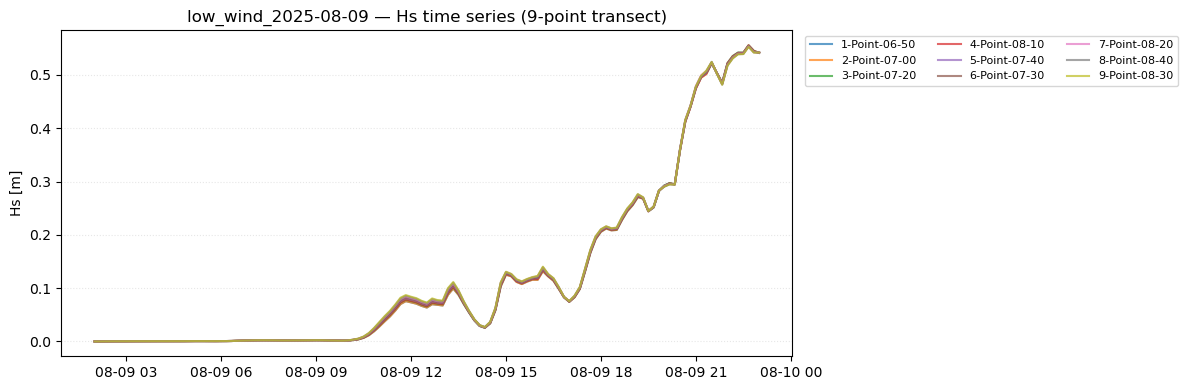

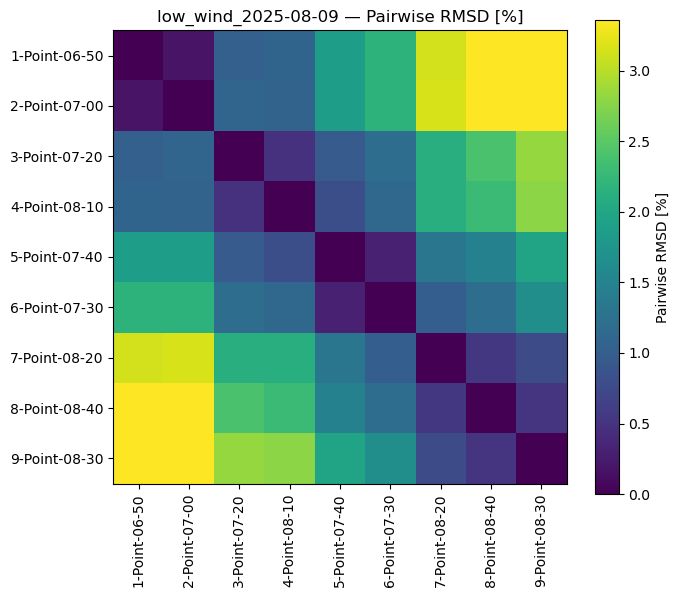

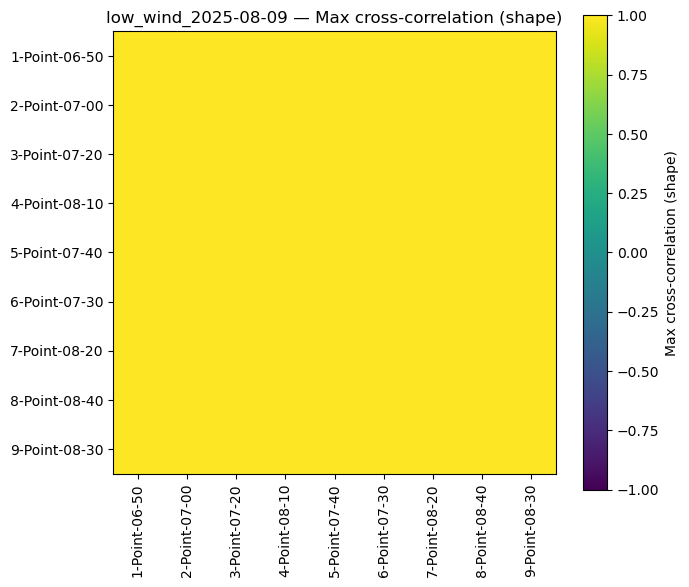

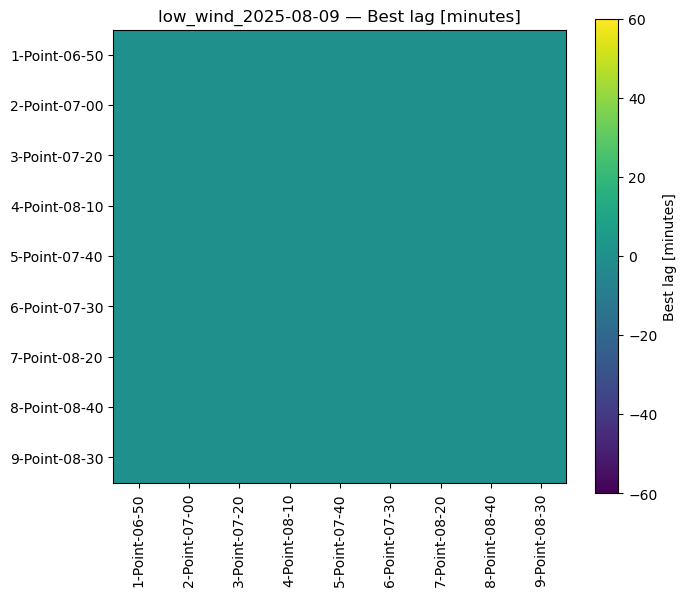

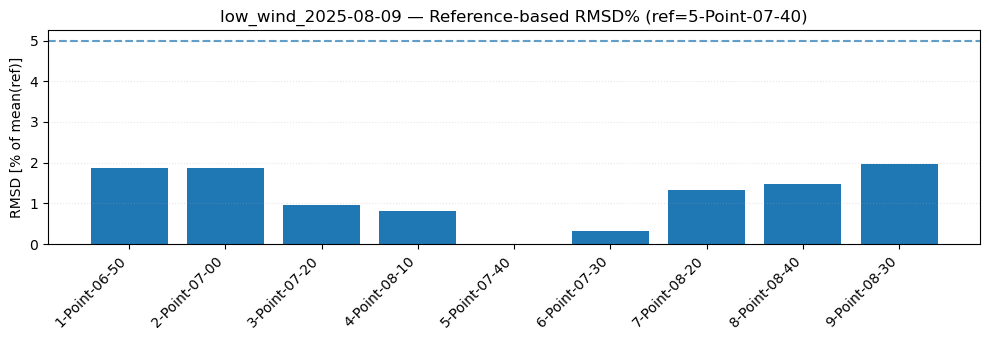


Phase 2 — moderate_2025-08-24
File: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\08_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0
Window: 2025-08-24 02:00 → 2025-08-24 23:00
Detected points: 9
Time step ~ 10.0 min; max lag = ±6 steps (~±60 min)

Reference point (median-energy): 5-Point-07-40
Reference-based RMSD%: min=0.45%, mean=1.71%, max=2.58%
Homogeneity criterion: max RMSD% ≤ 5.0%  ->  True

Representative snapshot near 06:50:
  timestamp used: 2025-08-24 06:50:00
  mean(Hs across 9 points) = 0.001 m (std = 0.000 m)


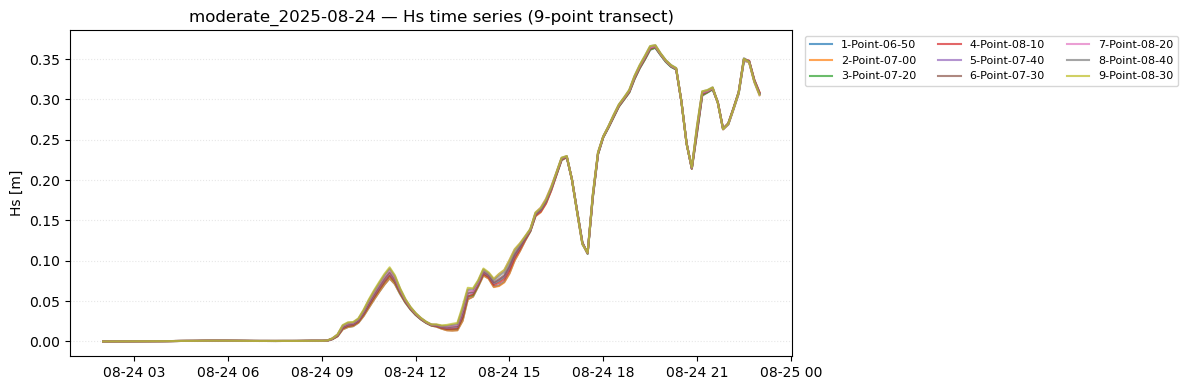

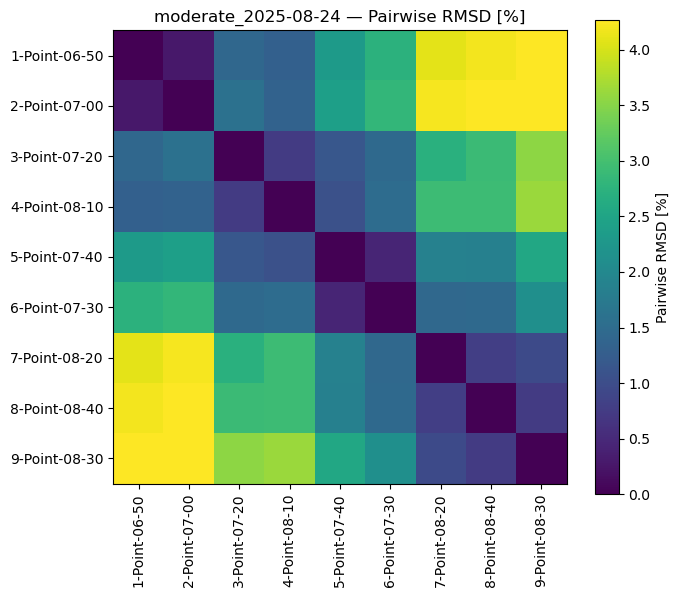

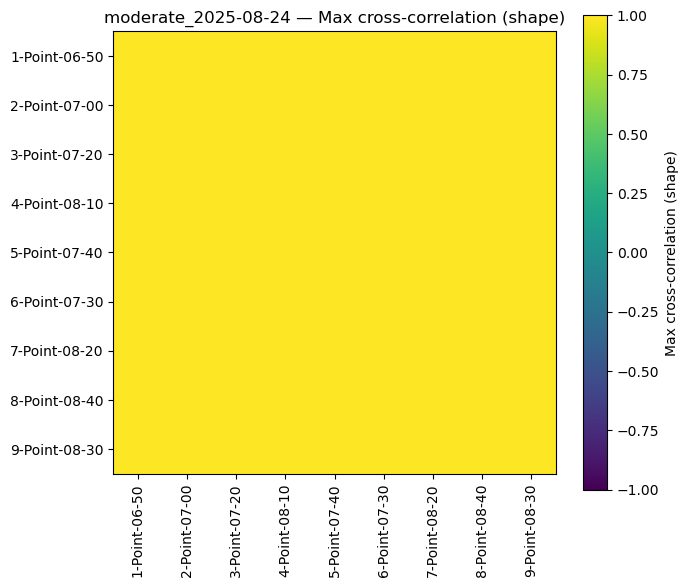

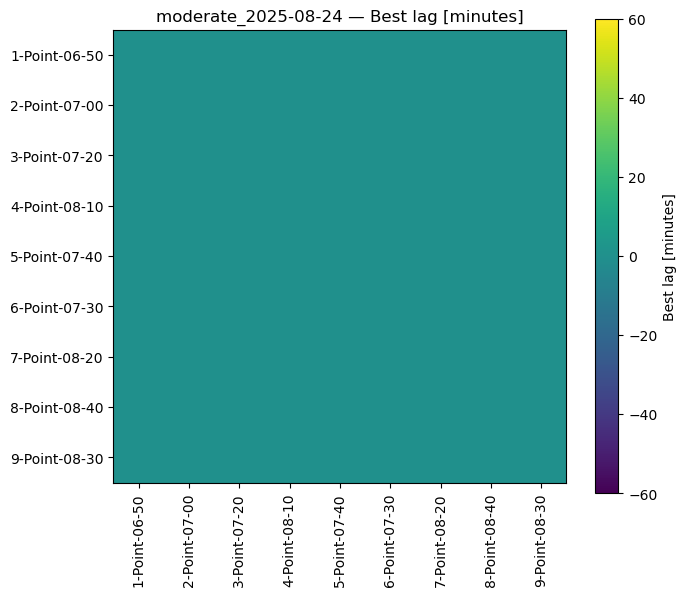

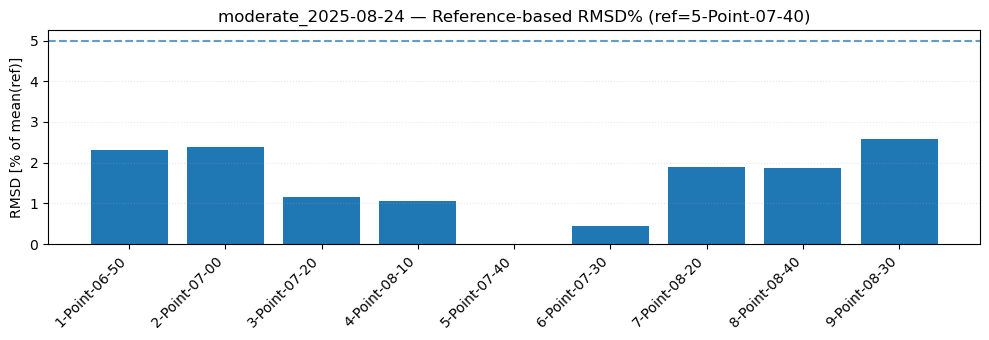


Phase 2 — high_wind_2025-10-23
File: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\02_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0
Window: 2025-10-23 02:00 → 2025-10-23 23:00
Detected points: 9
Time step ~ 10.0 min; max lag = ±6 steps (~±60 min)

Reference point (median-energy): 5-Point-07-40
Reference-based RMSD%: min=0.26%, mean=1.25%, max=1.84%
Homogeneity criterion: max RMSD% ≤ 5.0%  ->  True

Representative snapshot near 06:50:
  timestamp used: 2025-10-23 06:50:00
  mean(Hs across 9 points) = 0.160 m (std = 0.006 m)


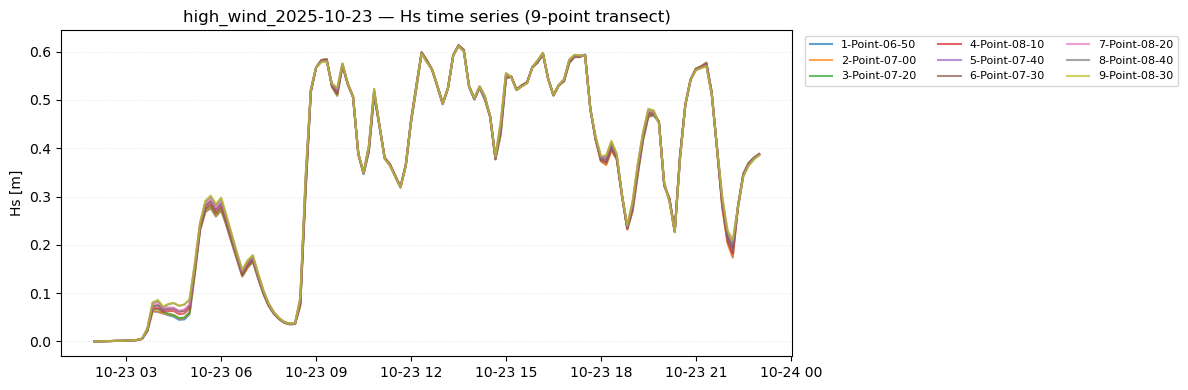

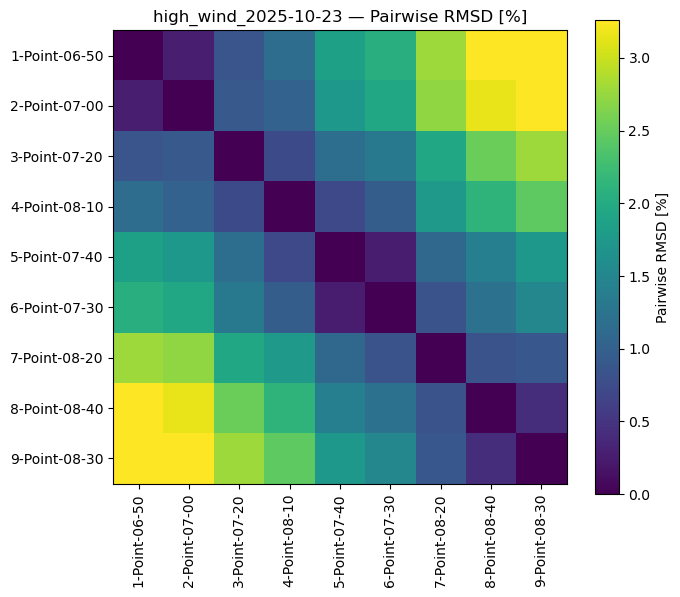

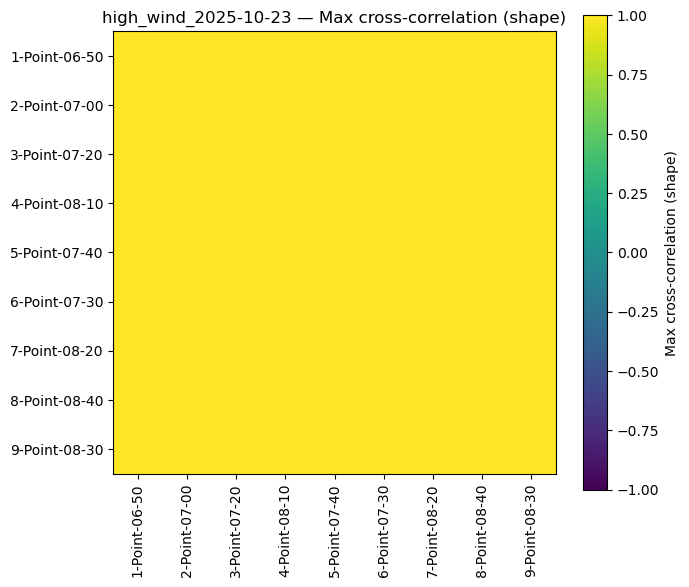

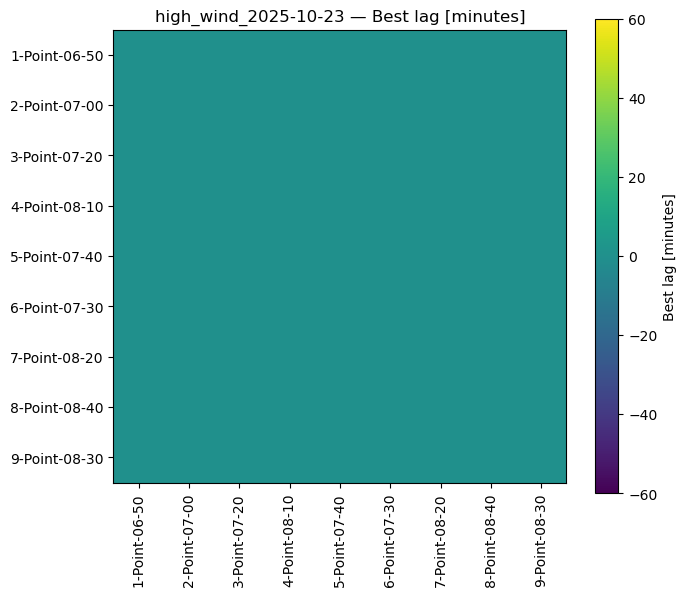

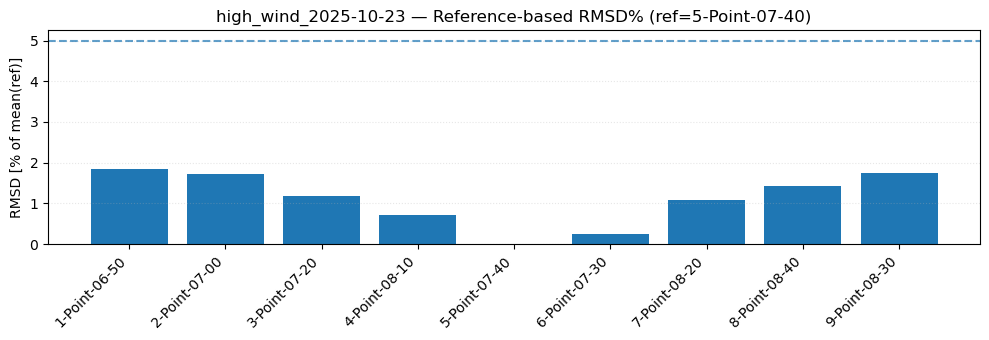

In [31]:
# =========================================================
# RUN ALL 3 SCENARIOS
# =========================================================
all_results = {}

for scen_name, cfg in SCENARIOS.items():
    path = os.path.join(source_folder_mike21sw, cfg["file"])
    res = analyze_transect_variability(
        dfs0_path=path,
        window=cfg["window"],
        scenario_name=scen_name,
    )
    all_results[scen_name] = res

In [33]:
# =========================================================
# OPTIONAL: COMPACT SUMMARY TABLE ACROSS SCENARIOS
# =========================================================
rows = []
for scen_name, res in all_results.items():
    rows.append({
        "scenario": scen_name,
        "homogeneous": res["homogeneous"],
        "ref_point": res["ref_point"],
        "min_ref_rmsd_pct": res["homogeneity_min_rmsd_pct"],
        "mean_ref_rmsd_pct": res["homogeneity_mean_rmsd_pct"],
        "max_ref_rmsd_pct": res["homogeneity_max_rmsd_pct"],
        "rep_time": (res["representative_snapshot"]["time"] if res["representative_snapshot"] else pd.NaT),
        "rep_Hs_mean": (res["representative_snapshot"]["Hs_mean_across_points"] if res["representative_snapshot"] else np.nan),
        "rep_Hs_std": (res["representative_snapshot"]["Hs_std_across_points"] if res["representative_snapshot"] else np.nan),
    })

df_phase2_summary = pd.DataFrame(rows)
print("\n=== Phase 2 summary across scenarios ===")
display(df_phase2_summary)


=== Phase 2 summary across scenarios ===


scenario  homogeneous      ref_point  min_ref_rmsd_pct  \
0   low_wind_2025-08-09         True  5-Point-07-40          0.314108   
1   moderate_2025-08-24         True  5-Point-07-40          0.447443   
2  high_wind_2025-10-23         True  5-Point-07-40          0.260113   

   mean_ref_rmsd_pct  max_ref_rmsd_pct            rep_time  rep_Hs_mean  \
0           1.324917          1.968691 2025-08-09 06:50:00     0.001776   
1           1.714322          2.576867 2025-08-24 06:50:00     0.000648   
2           1.247901          1.840172 2025-10-23 06:50:00     0.159947   

   rep_Hs_std  
0    0.000035  
1    0.000008  
2    0.005521

# MIKE21 SW vs YOLOv8 (Model 4) QUANTITATIVE COMPARISON

In [661]:
# 1. READ WEBCAM SUMMARY CSV (per-image Hs + wave counts)
# -------------------------------------------------------------------

#2025-08-09
#Yolo8S - 5000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_5000_wave_stat\summary_04_waves_yolov8s-5000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#Yolo8S - 1000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_1000_wave_stat\summary_03_waves_yolov8s-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8S_wave_stat\waves_03_waves_yolov8s-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#Yolo8N - 150
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-150_wave_stat\summary_02_waves_yolov8n-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-150_wave_stat\waves_02_waves_yolov8n-1000_150e_2025-08-09_02-00_2025-08-09_23-50.csv")
#Yolo8N - 50
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-50_wave_stat\summary_02_waves_yolov8n-1000_50e_2025-08-09_02-00_2025-08-09_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-09_YOLO8N_1000-50_wave_stat\waves_02_waves_yolov8n-1000_50e_2025-08-09_02-00_2025-08-09_23-50.csv")

#2025-08-24
#Yolo8S - 5000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_5000_wave_stat\summary_04_waves_yolov8s-5000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#Yolo8S - 1000
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_1000_wave_stat\summary_03_waves_yolov8s-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8S_1000_wave_stat\waves_03_waves_yolov8s-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#Yolo8N - 150
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-150_wave_stat\summary_02_waves_yolov8n-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-150_wave_stat\waves_02_waves_yolov8n-1000_150e_2025-08-24_02-00_2025-08-24_23-50.csv")
#Yolo8N - 50
#summary_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-50_wave_stat\summary_02_waves_yolov8n-1000_50e_2025-08-24_02-00_2025-08-24_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-08-24_YOLO8N_1000-50_wave_stat\waves_02_waves_yolov8n-1000_50e_2025-08-24_02-00_2025-08-24_23-50.csv")


#2025-10-23
#Yolo8S - 5000
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_5000_wave_stat\summary_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#Yolo8S - 1000
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_1000_wave_stat\summary_03_waves_yolov8s-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8S_1000_wave_stat\waves_03_waves_yolov8s-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#Yolo8N - 150
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-150_wave_stat\summary_02_waves_yolov8n-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-150_wave_stat\waves_02_waves_yolov8n-1000_150e_2025-10-23_02-00_2025-10-23_23-50.csv")
#Yolo8N - 50
#summary_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-50_wave_stat\summary_02_waves_yolov8n-1000_50e_2025-10-23_02-00_2025-10-23_23-50.csv")
#waves_csv = os.path.join(source_folder_deepL, r"2025-10-23_YOLO8N_1000-50_wave_stat\waves_02_waves_yolov8n-1000_50e_2025-10-23_02-00_2025-10-23_23-50.csv")

summary = pd.read_csv(summary_csv)
waves_df = pd.read_csv(waves_csv)





In [666]:
import os
import re
import numpy as np
import pandas as pd
import mikeio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr

# =========================================================
# PHASE 3 — LOOPED: MIKE21 SW (UV–0.25 Hz) vs YOLOv8 (Model 4)
# For LOW / MODERATE / HIGH wind days
# =========================================================
# (1) Significant wave height inter-comparison:
#     - MIKE: Hm0 ("Sign. Wave Height")
#     - YOLO: H(1/3) per time bin from detected wave heights (height_m)
#     - Metrics: MAD, Bias, Correlation
# (2) Extreme value comparison:
#     - MIKE: Hmax ("Max. Wave Height")
#     - YOLO: Hmax_observed per time bin
#     - Compare ratios: Hmax/Hs (MIKE: Hmax/Hm0, YOLO: Hmax_obs/H(1/3))
#
# Outputs per scenario:
#   - aligned CSV
#   - metrics CSV
#   - plots (timeseries, scatters, ratio box)
# And one combined summary CSV across scenarios.
# =========================================================


# ----------------------------
# USER CONFIG
# ----------------------------
source_folder_mike21sw = r"C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results"
source_folder_deepL    = r"C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results"

# Representative point (must match DFS0 column prefix before ":")
REP_POINT_NAME = "1-Point-06-50"

# Time aggregation bin (should match MIKE output step)
BIN_FREQ = "10min"

# Optional analysis window override (None = full)
TIME_START = None
TIME_END   = None

# Output root folder
out_dir_root = os.path.join(source_folder_deepL, "final_evaluation_mike_vs_yolo")
os.makedirs(out_dir_root, exist_ok=True)


# ----------------------------
# SCENARIO FILES (EDIT IF NEEDED)
# ----------------------------
SCENARIOS = [
    {
        "name": "low_wind_2025-08-09",
        "date": "2025-08-09",
        "yolo_csv": os.path.join(
            source_folder_deepL,
            r"2025-08-09_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-09_02-00_2025-08-09_23-50.csv"
        ),
        "mike_dfs0": os.path.join(
            source_folder_mike21sw,
            r"10_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0"
        ),
    },
    {
        "name": "moderate_2025-08-24",
        "date": "2025-08-24",
        "yolo_csv": os.path.join(
            source_folder_deepL,
            r"2025-08-24_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-24_02-00_2025-08-24_23-50.csv"
        ),
        "mike_dfs0": os.path.join(
            source_folder_mike21sw,
            r"08_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0"
        ),
    },
    {
        "name": "high_wind_2025-10-23",
        "date": "2025-10-23",
        "yolo_csv": os.path.join(
            source_folder_deepL,
            r"2025-10-23_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv"
        ),
        "mike_dfs0": os.path.join(
            source_folder_mike21sw,
            r"02_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0"
        ),
    },
]


# ----------------------------
# HELPERS: MIKE reading
# ----------------------------
def _find_item_name(ds, keywords_any):
    for it in ds.items:
        lc = it.name.lower()
        if any(k.lower() in lc for k in keywords_any):
            return it.name
    return None

def read_mike_timeseries(dfs0_path, rep_point):
    """
    Returns DataFrame indexed by time with columns: Hm0, Hmax for given rep_point.
    """
    if not os.path.exists(dfs0_path):
        raise FileNotFoundError(dfs0_path)

    ds = mikeio.read(dfs0_path)

    hm0_item = _find_item_name(ds, ["sign. wave height", "hm0", "hs"])
    hmax_item = _find_item_name(ds, ["max. wave height", "hmax", "max wave height"])

    if hm0_item is None:
        raise ValueError(f"Could not find Hm0/Sign. Wave Height in items: {[it.name for it in ds.items]}")
    if hmax_item is None:
        raise ValueError(f"Could not find Hmax/Max. Wave Height in items: {[it.name for it in ds.items]}")

    df = mikeio.read(dfs0_path, items=[hm0_item, hmax_item]).to_dataframe()
    df.index = pd.to_datetime(df.index)

    cols = df.columns.tolist()

    def pick_col(item_contains, point):
        cands = [c for c in cols if item_contains in c.lower()]
        if not cands:
            raise ValueError(f"No columns contain '{item_contains}'. Columns: {cols}")

        for c in cands:
            prefix = c.split(":")[0].strip()
            if prefix == point:
                return c

        raise ValueError(
            f"Could not find point '{point}' for '{item_contains}'.\nCandidates:\n{cands}"
        )

    hm0_col = pick_col("sign. wave height", rep_point)
    hmax_col = pick_col("max. wave height", rep_point)

    out = pd.DataFrame(
        {"Hm0": df[hm0_col].astype(float), "Hmax": df[hmax_col].astype(float)},
        index=df.index
    ).sort_index()

    return out, hm0_item, hmax_item


# ----------------------------
# HELPERS: YOLO CSV -> bins
# ----------------------------
def add_time_from_image_filename(waves_df, image_col="image"):
    """
    Extract datetime from filenames like img_YYYY_MM_DD_HH_MM_SS.png and add df['time'].
    """
    df = waves_df.copy()
    ts = df[image_col].astype(str).str.extract(
        r"img_(\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2})", expand=False
    )
    if ts.isna().all():
        raise ValueError("Could not parse time from 'image'. Expected img_YYYY_MM_DD_HH_MM_SS.png")
    df["time"] = pd.to_datetime(ts, format="%Y_%m_%d_%H_%M_%S", errors="coerce")
    df = df.dropna(subset=["time"])
    return df

def compute_h13_and_hmax_by_bin_from_waves_df(waves_df, bin_freq="10min", height_col="height_m"):
    """
    Per bin:
      - H13 = mean of highest 1/3 heights
      - Hmax_obs = max height
      - n_waves = number of detections
    """
    df = add_time_from_image_filename(waves_df)

    if height_col not in df.columns:
        raise ValueError(f"'{height_col}' not found. Columns: {list(df.columns)}")

    df[height_col] = pd.to_numeric(df[height_col], errors="coerce")
    df = df.dropna(subset=[height_col])
    df = df.set_index("time").sort_index()

    rows = []
    for tbin, g in df.groupby(pd.Grouper(freq=bin_freq)):
        if g.empty:
            continue
        heights = g[height_col].values
        n = len(heights)
        if n == 0:
            continue

        hmax = float(np.max(heights))
        k = max(int(np.ceil(n / 3.0)), 1)
        top = np.sort(heights)[-k:]
        h13 = float(np.mean(top))

        rows.append({"time": tbin, "H13": h13, "Hmax_obs": hmax, "n_waves": n})

    return pd.DataFrame(rows).set_index("time").sort_index()


# ----------------------------
# METRICS
# ----------------------------
def mad(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    return float(np.mean(np.abs(x[m] - y[m]))) if m.sum() else np.nan

def bias(model, obs):
    model = np.asarray(model, float); obs = np.asarray(obs, float)
    m = np.isfinite(model) & np.isfinite(obs)
    return float(np.mean(obs[m] - model[m])) if m.sum() else np.nan  # YOLO - MIKE

def corrcoef(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3:
        return np.nan
    return float(np.corrcoef(x[m], y[m])[0, 1])


# ----------------------------
# PLOTTING
# ----------------------------
def format_time_axis(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def plot_timeseries(df_aligned, title, save_path):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df_aligned.index, df_aligned["Hm0"], label="MIKE Hm0 (spectral Hs)")
    ax.plot(df_aligned.index, df_aligned["H13"], label="YOLO H(1/3) (detections)")
    ax.set_title(title)
    ax.set_ylabel("Significant wave height [m]")
    ax.grid(axis="y", alpha=0.3, linestyle=":")
    format_time_axis(ax)
    ax.legend()
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.close(fig)

def plot_scatter(df_aligned, xcol, ycol, title, xlabel, ylabel, save_path):
    fig, ax = plt.subplots(figsize=(5.5, 5))
    ax.scatter(df_aligned[xcol], df_aligned[ycol], alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3, linestyle=":")
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.close(fig)

def plot_ratio_box(df_aligned, title, save_path):
    fig, ax = plt.subplots(figsize=(6, 4))
    rm = df_aligned["ratio_mike"].replace([np.inf, -np.inf], np.nan).dropna().values
    ry = df_aligned["ratio_yolo"].replace([np.inf, -np.inf], np.nan).dropna().values
    ax.boxplot([rm, ry], labels=["MIKE Hmax/Hm0", "YOLO Hmax/H(1/3)"])
    ax.set_title(title)
    ax.set_ylabel("Maximum-to-significant ratio")
    ax.grid(axis="y", alpha=0.3, linestyle=":")
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.close(fig)


# =========================================================
# RUN LOOP
# =========================================================
all_metrics = []

for sc in SCENARIOS:
    name = sc["name"]
    yolo_csv = sc["yolo_csv"]
    mike_path = sc["mike_dfs0"]

    scenario_dir = os.path.join(out_dir_root, name)
    os.makedirs(scenario_dir, exist_ok=True)

    print("\n" + "=" * 70)
    print(f"PHASE 3 — {name}")
    print("YOLO:", yolo_csv)
    print("MIKE:", mike_path)
    print("=" * 70)

    if not os.path.exists(yolo_csv):
        print(f"SKIP: YOLO CSV not found: {yolo_csv}")
        continue
    if not os.path.exists(mike_path):
        print(f"SKIP: MIKE DFS0 not found: {mike_path}")
        continue

    # 1) Load YOLO CSV
    waves_df = pd.read_csv(yolo_csv)

    # 2) Read MIKE (Hm0, Hmax) for rep point
    mike_ts, hm0_item_name, hmax_item_name = read_mike_timeseries(mike_path, rep_point=REP_POINT_NAME)

    # Optional trim (global)
    if TIME_START is not None or TIME_END is not None:
        t0 = pd.Timestamp(TIME_START) if TIME_START else mike_ts.index.min()
        t1 = pd.Timestamp(TIME_END) if TIME_END else mike_ts.index.max()
        mike_ts = mike_ts.loc[t0:t1]

    # 3) YOLO bins
    yolo_bins = compute_h13_and_hmax_by_bin_from_waves_df(waves_df, bin_freq=BIN_FREQ, height_col="height_m")
    yolo_bins = yolo_bins.loc[mike_ts.index.min():mike_ts.index.max()]

    # 4) Align
    df_aligned = mike_ts.join(yolo_bins, how="inner")
    if df_aligned.empty:
        print("SKIP: no overlapping timestamps after join (check BIN_FREQ / timestamps).")
        continue

    # 5) Ratios
    df_aligned["ratio_mike"] = df_aligned["Hmax"] / df_aligned["Hm0"]
    df_aligned["ratio_yolo"] = df_aligned["Hmax_obs"] / df_aligned["H13"]

    # 6) Metrics
    m = {
        "scenario": name,
        "date": sc.get("date"),
        "rep_point": REP_POINT_NAME,
        "n_bins": int(len(df_aligned)),
        "MAD_Hm0_vs_H13_m": mad(df_aligned["Hm0"].values, df_aligned["H13"].values),
        "Bias_(YOLO-Hm0)_m": bias(df_aligned["Hm0"].values, df_aligned["H13"].values),  # YOLO - MIKE
        "Corr_Hm0_H13": corrcoef(df_aligned["Hm0"].values, df_aligned["H13"].values),
        "MAD_Hmax_m": mad(df_aligned["Hmax"].values, df_aligned["Hmax_obs"].values),
        "Bias_(YOLO-Hmax)_m": bias(df_aligned["Hmax"].values, df_aligned["Hmax_obs"].values),
        "Mean_ratio_mike": float(np.nanmean(df_aligned["ratio_mike"].replace([np.inf, -np.inf], np.nan).values)),
        "Mean_ratio_yolo": float(np.nanmean(df_aligned["ratio_yolo"].replace([np.inf, -np.inf], np.nan).values)),
        "Median_ratio_mike": float(np.nanmedian(df_aligned["ratio_mike"].replace([np.inf, -np.inf], np.nan).values)),
        "Median_ratio_yolo": float(np.nanmedian(df_aligned["ratio_yolo"].replace([np.inf, -np.inf], np.nan).values)),
    }
    all_metrics.append(m)

    # 7) Save aligned + scenario metrics
    aligned_csv = os.path.join(scenario_dir, "aligned_mike_vs_yolo.csv")
    metrics_csv = os.path.join(scenario_dir, "phase3_metrics_summary.csv")
    df_aligned.to_csv(aligned_csv)
    pd.DataFrame([m]).to_csv(metrics_csv, index=False)

    print("Saved:")
    print(" -", aligned_csv)
    print(" -", metrics_csv)

    # 8) Plots
    plot_timeseries(
        df_aligned,
        title=f"{name}: MIKE Hm0 vs YOLO H(1/3)\n{os.path.basename(mike_path)} | Rep point: {REP_POINT_NAME}",
        save_path=os.path.join(scenario_dir, "timeseries_Hm0_vs_H13.png"),
    )

    plot_scatter(
        df_aligned,
        xcol="Hm0", ycol="H13",
        title=f"{name}: Hm0 vs H(1/3) (r={m['Corr_Hm0_H13']:.2f})",
        xlabel="MIKE Hm0 [m]",
        ylabel="YOLO H(1/3) [m]",
        save_path=os.path.join(scenario_dir, "scatter_Hm0_vs_H13.png"),
    )

    plot_scatter(
        df_aligned,
        xcol="Hmax", ycol="Hmax_obs",
        title=f"{name}: Hmax MIKE vs YOLO (r={corrcoef(df_aligned['Hmax'].values, df_aligned['Hmax_obs'].values):.2f})",
        xlabel="MIKE Hmax [m]",
        ylabel="YOLO Hmax_observed [m]",
        save_path=os.path.join(scenario_dir, "scatter_Hmax_vs_Hmaxobs.png"),
    )

    plot_ratio_box(
        df_aligned,
        title=f"{name}: Maximum-to-significant ratio (MIKE vs YOLO)",
        save_path=os.path.join(scenario_dir, "ratio_box.png"),
    )

# 9) Combined summary across scenarios
final_summary_df = pd.DataFrame(all_metrics)
if final_summary_df.empty:
    print("\nNo scenario produced metrics → all_metrics is empty.")
    print("Common causes:")
    print(" - One or more YOLO CSV paths not found")
    print(" - One or more MIKE DFS0 paths not found")
    print(" - No overlapping timestamps after join (check BIN_FREQ and YOLO timestamp parsing)")
    print(" - 'image' column name or filename pattern mismatch (img_YYYY_MM_DD_HH_MM_SS)")
    print("\nNothing to write for combined summary.")
else:
    # sort only if the column exists
    if "scenario" in final_summary_df.columns:
        final_summary_df = final_summary_df.sort_values("scenario")

    final_summary_csv = os.path.join(out_dir_root, "phase3_metrics_summary_ALL_SCENARIOS.csv")
    final_summary_df.to_csv(final_summary_csv, index=False)

    print("\n" + "=" * 70)
    print("PHASE 3 — SUMMARY ACROSS SCENARIOS")
    print("=" * 70)
    print(final_summary_df.to_string(index=False))
    print("\nSaved combined summary CSV:")
    print(" -", final_summary_csv)


final_summary_csv = os.path.join(out_dir_root, "phase3_metrics_summary_ALL_SCENARIOS.csv")
final_summary_df.to_csv(final_summary_csv, index=False)

print("\n" + "=" * 70)
print("PHASE 3 — SUMMARY ACROSS SCENARIOS")
print("=" * 70)
print(final_summary_df.to_string(index=False))
print("\nSaved combined summary CSV:")
print(" -", final_summary_csv)


PHASE 3 — low_wind_2025-08-09
YOLO: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\2025-08-09_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-09_02-00_2025-08-09_23-50.csv
MIKE: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\10_SW-point-parameters - 2025-08-09-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0
Saved:
 - C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\final_evaluation_mike_vs_yolo\low_wind_2025-08-09\aligned_mike_vs_yolo.csv
 - C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\final_evaluation_mike_vs_yolo\low_wind_2025-08-09\phase3_metrics_summary.csv


C:\Users\A\AppData\Local\Temp\ipykernel_13556\2041943938.py:261: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([rm, ry], labels=["MIKE Hmax/Hm0", "YOLO Hmax/H(1/3)"])



PHASE 3 — moderate_2025-08-24
YOLO: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\2025-08-24_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-08-24_02-00_2025-08-24_23-50.csv
MIKE: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\08_SW-point-parameters - 2025-08-24-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0
Saved:
 - C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\final_evaluation_mike_vs_yolo\moderate_2025-08-24\aligned_mike_vs_yolo.csv
 - C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\final_evaluation_mike_vs_yolo\moderate_2025-08-24\phase3_metrics_summary.csv


C:\Users\A\AppData\Local\Temp\ipykernel_13556\2041943938.py:261: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([rm, ry], labels=["MIKE Hmax/Hm0", "YOLO Hmax/H(1/3)"])



PHASE 3 — high_wind_2025-10-23
YOLO: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\2025-10-23_YOLO8S_5000_wave_stat\waves_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv
MIKE: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\MIKE21\SW_results\02_SW-point-parameters - 2025-10-23-0200-2300-uv-wind_10min_multip_0.25Hz.dfs0
Saved:
 - C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\final_evaluation_mike_vs_yolo\high_wind_2025-10-23\aligned_mike_vs_yolo.csv
 - C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\final_evaluation_mike_vs_yolo\high_wind_2025-10-23\phase3_metrics_summary.csv

PHASE 3 — SUMMARY ACROSS SCENARIOS
            scenario       date     rep_point  n_bins  MAD_Hm0_vs_H13_m  Bias_(YOLO-Hm0)_m  Corr_Hm0_H13  MAD_Hmax_m  Bias_(YOLO-Hmax)_m  Mean_ratio_mike  Mean_ratio_yolo  Median_ratio_mike  Median_ratio_yolo
high_wind_2025-10-23 2025-10-23 1-Point-06-50      74          0.264717          -0.219965      0.484076    0.657361           -0.6

C:\Users\A\AppData\Local\Temp\ipykernel_13556\2041943938.py:261: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([rm, ry], labels=["MIKE Hmax/Hm0", "YOLO Hmax/H(1/3)"])
